<a href="https://colab.research.google.com/github/rmunoz78/ProyectoIntegrador_MNA_Equipo23/blob/main/Proyecto_Integrador_TFL_Equipo23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

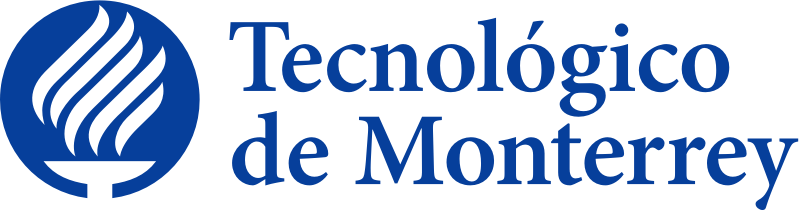

# Instituto Tecnológico de Estudios Superiores de Monterrey




 #### Alumnos Equipo 23:
- **[A01330566]**  Ramon Ariel Ivan Muñoz Corona


### Proyecto Integrador
## Modelo de sistema de Recomendación Vehículo / Conductor para transporte de mercancía por vía terrestre






#### Profesores titulares:
- Grettel Barceló Alonso
- Luis Eduardo Falcón Morales

#### Asesor:
- Guillermo Mota Medina



### Fecha: 16/06/2024

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Jun  2 04:00:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              50W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Importación de Librerías

In [2]:
!pip install geopy
!pip install yellowbrick

In [3]:
%matplotlib inline
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import precision_recall_curve, auc
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings; warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


________________
# Avance 1 - Análisis exploratorio de datos
## Importación de Datos

In [4]:
# Lectura de los datos desde el archivo CSV
df = pd.read_excel('/content/drive/MyDrive/Maestria/Proyecto Integrador/DATOS_TFL_052924.xlsx')

In [5]:
# Para revisar que se importó de manera correcta el dataframe, imprimimos los
# primeros 5 renglones. Esto, a su vez, nos permite visualizar la estructura de
# la tabla
df.head()

# ORDEN          ID CLIENTE  PICKUP_LAT  PICKUP_LON  DELIVERY_LAT  \
0     NaN  PENINSULA_ORIENTAL      19.479     -99.196        19.630   
1     NaN  PENINSULA_ORIENTAL      19.479     -99.196        19.696   
2     NaN  PENINSULA_ORIENTAL      19.479     -99.196        19.696   
3     NaN  PENINSULA_ORIENTAL      19.479     -99.196        19.720   
4     NaN  PENINSULA_ORIENTAL      19.479     -99.196        19.630   

   DELIVERY_LON  DIA  MES   AÑO  DIA DE LA SEMANA  ...  \
0       -99.183    6    5  2019                 2  ...   
1       -99.200   11    5  2019                 7  ...   
2       -99.200   11    5  2019                 7  ...   
3       -99.192   11    5  2019                 7  ...   
4       -99.183   11    5  2019                 7  ...   

   CAPACIDAD UNIDAD ASIGNADA MODELO  UNIDAD ASIGNADA          ID CAJA  \
0                     12.000                    1997    Integrada_T02   
1                     12.000                    1997   EXTERNO_TORTON   
2                     12.000                    1997   EXTERNO_TORTON   
3                     12.000                    1997   EXTERNO_TORTON   
4                     25.000                    1997  EXTERNO_TRAILER   

         TIPO DE ARTICULO # PALLETS   PESO STATUS DE LA ORDEN  \
0  ARTÍCULOS DE TEMPORADA    12.000 12.000         COMPLETADA   
1  ARTÍCULOS DE TEMPORADA    12.000 12.000         COMPLETADA   
2  ARTÍCULOS DE TEMPORADA    12.000 12.000         COMPLETADA   
3  ARTÍCULOS DE TEMPORADA    12.000 12.000         COMPLETADA   
4  ARTÍCULOS DE TEMPORADA    20.000 20.000         COMPLETADA   

  NECESIDADES CARGA   PACKAGING  PRECIO  
0         CAJA SECA  ENTARIMADO    2016  
1         CAJA SECA  ENTARIMADO    3920  
2         CAJA SECA  ENTARIMADO    2016  
3         CAJA SECA  ENTARIMADO    2016  
4         CAJA SECA  ENTARIMADO    3136  

[5 rows x 29 columns]

## Estructura de los datos

In [6]:
# Empezaremos revisando la forma de la tabla para saber con cuantas columnas
# (características de los viajes) y filas (órdenes) tenemos disponibles

df.shape

(7294, 29)

Tenemos 28 features o características de cada viaje y tenemos 7294 viajes registrados.

Con base en esto procedemos a analizar las características de cada columna.

In [7]:
# Con esta función obtenemos la información acerca de cada columna, como por
# ejemplo, tipo de dato, nombre de la columna y el total de los valores nulos
# en la tabla

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   # ORDEN                      7099 non-null   object 
 1   ID CLIENTE                   7294 non-null   object 
 2   PICKUP_LAT                   7294 non-null   float64
 3   PICKUP_LON                   7294 non-null   float64
 4   DELIVERY_LAT                 7294 non-null   float64
 5   DELIVERY_LON                 7294 non-null   float64
 6   DIA                          7294 non-null   int64  
 7   MES                          7294 non-null   int64  
 8   AÑO                          7294 non-null   int64  
 9   DIA DE LA SEMANA             7294 non-null   int64  
 10  SEMANA CALENDARIO            7294 non-null   int64  
 11  OPERADOR                     7294 non-null   object 
 12  XP OPERADOR                  7294 non-null   int64  
 13  STATUS OPERADOR   

Podemos ver que la única columna que contiene datos nulos es la del Número de Orden, con un total de 196 valores nulos o faltantes.

Sin embargo, esta columna al ser únicamente un identificador, no nos provee ningún elemento estadístico, por lo que podemos removerla.

In [8]:
# Removemos la columna del Número de Orden
df.drop('# ORDEN', axis=1, inplace=True)

Verificaremos si existen filas duplicadas, si es asi, las removeremos para evitar tener ruido.

In [9]:
print("Total de filas duplicadas:", len(df[df.duplicated()]))

Total de filas duplicadas: 594


In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(6700, 28)

Con base en esta información podemos comenzar a revisar las variables númericas y categóricas para empezar a extraer información.

## Resumen de los Datos

### Variables Numéricas
Comenzaremos con las variables numéricas. Para empezar, realizaremos un análisis estadístico para revisar que las variables cuenten con valores posibles y que podamos revisar si las variables muestran alguna tendencia relevante.

Para realizar el análisis estadístico, utilizaremos la función de "describe" para obtener los valores estadísticos (cuenta, promedio, desviación estandar, mínimo, Q25, Q50, Q75 y máximo).

In [12]:
# La función de describe muestra los valores estadísticos de cada variable
# numérica. Por otra lado, la función T, nos da la transpuesta de la matriz,
# mejorando la visualización de los datos.
df.describe().T

count     mean      std      min      25%  \
PICKUP_LAT                  6700.000   19.531    0.209   19.284   19.467   
PICKUP_LON                  6700.000  -99.242    0.372 -104.645  -99.233   
DELIVERY_LAT                6700.000   19.783    0.839   17.983   19.467   
DELIVERY_LON                6700.000  -99.278    0.961 -107.406  -99.233   
DIA                         6700.000   15.925    8.651    1.000    9.000   
MES                         6700.000    7.211    3.272    1.000    4.000   
AÑO                         6700.000 2021.751    0.942 2019.000 2021.000   
DIA DE LA SEMANA            6700.000    4.156    1.597    1.000    3.000   
SEMANA CALENDARIO           6700.000   30.135   14.249    1.000   18.000   
XP OPERADOR                 6700.000    6.276    2.608    1.000    5.000   
RENDIMIENTO UNIDAD ASIGNADA 6700.000    2.951    0.804    2.000    2.000   
CAPACIDAD UNIDAD ASIGNADA   6700.000   15.963    5.776    3.500   12.000   
MODELO  UNIDAD ASIGNADA     6700.000 1994.464    7.074 1981.000 1992.000   
# PALLETS                   6700.000   13.785    5.448    1.000   10.000   
PESO                        6700.000   13.783    5.471    1.000   10.000   
PRECIO                      6700.000 3759.024 5293.717  147.000 1615.000   

                                 50%      75%       max  
PICKUP_LAT                    19.474   19.499    23.998  
PICKUP_LON                   -99.228  -99.175   -89.593  
DELIVERY_LAT                  19.690   19.708    28.629  
DELIVERY_LON                 -99.201  -99.153   -86.949  
DIA                           16.000   23.000    31.000  
MES                            8.000   10.000    12.000  
AÑO                         2022.000 2022.000  2023.000  
DIA DE LA SEMANA               4.000    6.000     7.000  
SEMANA CALENDARIO             32.000   42.000    53.000  
XP OPERADOR                    5.000    8.000    11.000  
RENDIMIENTO UNIDAD ASIGNADA    3.300    3.300     5.100  
CAPACIDAD UNIDAD ASIGNADA     12.000   22.000    25.000  
MODELO  UNIDAD ASIGNADA     1997.000 1997.000  2015.000  
# PALLETS                     12.000   20.000    24.000  
PESO                          12.000   20.000    24.000  
PRECIO                      3000.000 4278.000 67200.000

#### Insights:
* Coordenadas de Longitud y Latitud:
  * La latitud promedio tanto de recolección, como de entrega esta al rededor de 19.531 con una desviación estandar de aproximadamente 0.209, mostrando que la mayoría de las locaciones están agrupadas alrededor del promedio, con una dispersión muy baja.
  * La longitud promedio para la recolección y entrega está aproximadamente en -99.24, con una desviación muy baja (aproximadamente 0.372). Lo que sugiere que las locaciones están bastante juntas.
  * Si obtuvieramos una locación promedio sería a un lado del Campo Militar  1-A de SEDENA en la CDMX.
  * Con estas columnas es facil obtener el la distancia que se recorrió para el viaje.
* Información sobre las fechas:
  * El día del mes promedio es aproximadamente 16, con una desviación estandar de 8.65, mostrando que se distribuyen los viajes de manera equitativa a lo largo del mes.
  * El mes promedio es Julio (mes 7), con una desviación estandar de 3.27. Si vemos los cuantiles, podemos ver que los meses más cargados son de agosto a diciembre.
  * El año promedio es 2021. Basado en los cuantiles podemos decir que la mayoría de los datos son de entre 2019 y 2023.
  * El día promedio es el miercoles, con una desviación estandar de aproximadamente 1.6, mostrando que estan distribuiods equitativamente los viajes a lo largo de la semana.
* Información sobre Conductores y Vehículos
  * El nivel de experiencia promedio de los conductores es de 6.3 años, sin embargo su desviación estandar es bastante elevada, con 2.6 años, mostrando que los un rango bastante amplio en el nivel de experiencia. Esto nos habla de una posible falta de retención de personal.
  * El año promedio de los vehículos es 1994. Si vemos los cuantiles, podemos ver que la gran mayoría de los vehiculos son anticuados, siendo en su mayoría de entre el año 1981 y 1997.
  * El peso máximo soportado por las unidades es de 15 Toneladas, sin embargo tienen una desviación estandar alta, de aproximadamente 6 toneladas, mostrando que hay una amplia diversidad en la foltilla para diferentes capacidades.
  * El rendimiento promedio es de aproximadamente 3 km por litro, lo que nos habla de un rendimiento bajo, probablemente por el nivel de carga.
* Información del cargamento:
  * El peso promedio por viaje es de 13.8 Toneladas, con una desviación de 5.6 toneladas aproximadamente. Esto nos dice que existe una buena variedad de pesos en cada viaje.
  * Podemos ver una correlación fuerte entre el número de pellets y el peso del viaje. Con un número de pellets de aproximadamente 14, igualmente con una desviación estandar elevada de 6 pellets, mostrando una buena variedad de número de pellets por viaje.
  * El precio promedio por viaje es de \$3787.24 MXN, con una desviación estandar elevada, de \$5197.03 MXN, sugiriendo que los precios varian mucho entre clientes. Probablemente valdría la pena estandarizarlos.

## Variables de Tipo Objeto
Una vez analizadas las variables de tipo numéricas, podemos pasar con las de tipo objeto. Para este análisis revisaremos con qué valores cuenta cada variable para revisar que no existan valores erroneos o inválidos. De igual manera nos brindará un insight sobre las variables.

In [13]:
# Esta función está diseñada para imprimir cada variable de tipo objeto y que
# a su vez se impriman los valores de cada variable, junto con el conteo de
# cada valor.

for i in df.describe(include=['object']).columns:
    print('Unique values in',i, 'are :')
    print(df[i].value_counts())
    print('*'*50)

Unique values in ID CLIENTE are :
ID CLIENTE
NOVELTY                   1852
PLAYERAS_SOURCE           1542
JASAK                     1446
JESSY                     1263
PENINSULA_ORIENTAL         350
APLIN                      113
MUEBLES_TRICK               72
MULTIBOLSAS                 55
COLECCIONES_DEPORTIVAS       7
Name: count, dtype: int64
**************************************************
Unique values in OPERADOR are :
OPERADOR
Externo                  1172
Martin Regino             771
Jose Luis Jmz             657
Mardonio Montaño          641
Gabriel Reyes             577
Ernesto Hdz               575
Miguel Perez              549
Daniel Hdz                381
Edgar Arreola             314
Nazario Cruz              293
Ivan Montero              292
Alan Gil Chavez           118
Angel                      95
Yair Flores                88
Agustin                    72
Arturo David Martinez      51
Apolinar                   45
Benito Parangueo            5
Miguel Cueto      

#### Insights:
* Clientes
  * Los clientes con mayor número de viajes son NOVELTY (1852 viajes), JASAK (1542 viajes)y PLAYERAS_SOURCE (1446 viajes)
  * Existe una diferencia significativa entre los clientes principales y el resto de los clientes, lo que nos habla de una concentración del negocio en sus clientes más grandes.
* Conductor
  * Los viajes son mayormente realizados por Jose Martin Regino Lopez, Maradonio Tirso Montaño y Jose Luis Jimenez de la Cruz.
  * Existe una concentración importante de los viajes realizados por conductores externos. 1172 de 6700 Viajes (17%). Lo que nos habla de una posible falta de capacidad de la empresa. Probablemte requiera más conductores o conductores con más experiencia.
  * Existe una distribución inicuo de los viajes entre conductores. Probablemente por sus status dentro de la empresa o por sus años de experiencia.
  * 5178 de los viajes fueron realizados por choferes aún activos en la empresa y 1522 por choferes que no continuan en la empresa.
* Tipos de Servicios Solicitado:
  * El servicio más solicitado es el manejo y transporte de mercancía. Valdría la pena revisar si estos también son los más redituables.
  * Existe una gran diferencia entre los servicios solicitados para torton y trailer, que para camioneta.
  * Existe una gran similitud entre los vehículos solicitados y los vehículos asignados. Sin embargo, podemos ver la existencia de externos en los vehículos asignados. Estos son debido a que por falta de capacidad operacional, se asignan camiones de empresas hermanas para cubrir la necesidad del viaje.
* Información de la carga:
  * El tipo de carga más transportada son eletrónicos y juegos de mesa.
  * La mayor parte de las mercancias están empaquetadas utilizando pallets.
* Estatus de Orden:
  * El 96% de los viajes se completaron, lo que nos indica un buen nivel de servicio por parte de TFL.

Ya analizados estos datos y revisar que estén correctos, podemos proceder al análisis univariable. Pero antes, valdría la pena agregar una variable; la distancia del viaje. Esta nueva variable nos da un mayor insight sobre una posible correlación entre distancia y precio.

In [14]:
# Esta función calcula la distancia entre los puntos de recolección y entrega
# utilizando la librería de geodesic
def calculate_distance(row):
    origin = (row['PICKUP_LAT'], row['PICKUP_LON'])
    delivery = (row['DELIVERY_LAT'], row['DELIVERY_LON'])
    return geodesic(origin, delivery).kilometers

# Se aplica la función a cada fila de la tabla
df["distancia_km"] = df.apply(calculate_distance, axis=1)

Una agregada la nueva variable y terminar de revisar que los datos estén correctos, podemos proceder al análisis univariable. Esto nos va a dar un mayor nivel de insight sobre cómo se comporta cada variable y si es que existe algún patrón o comportamiento.

## Análisis Univariable
### Variables Numéricas
Para revisar las variables numéricas generaremos un histograma, junto con un diagrama de caja, resaltando su promedio y la mediana. Esto nos permitirá ver la distribución de los datos, visualizar si tenemos outliers y ver si tenemos alguna tendencia.

In [15]:
# Esta función, como se explicó, nos permite visualizar la distribución de los
# datos numéricos, si es que existen outliers y donde se encuentra su valor
# medio y su mediana

def plot_histogram_boxplot(data, col_name, figsize = (5,5), bins = None):
  feature = data[col_name]
  f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2,
                                         gridspec_kw = {"height_ratios": (.25, .75)},
                                         figsize = figsize)

  ax_box2.set_title(col_name).set_position([0.5, -3])
  sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet', orient="h")
  ax_box2.set_xlabel('')
  sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
  ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--')
  ax_hist2.axvline(np.median(feature), color='black', linestyle='-')
  ax_hist2.set_ylabel('Total de Viajes')

# Esta función funciona con el mismo principio que plot_histogram_boxplot,
# sin embargo está diseñada para poder tener más de una gráfica en el mismo
# bloque. Visualizando de mejor manera las gráficas.
def multi_histogram_boxplot(feature, ax, ax2, bins=None):
    sns.boxplot(feature, ax=ax, showmeans=True, color='violet', orient="h")
    if bins:
        sns.distplot(feature, kde=False, ax=ax2, bins=bins, color='tab:cyan')
    else:
        sns.distplot(feature, kde=False, ax=ax2, color='tab:cyan')
    ax2.set_xlabel('')
    ax2.axvline(np.mean(feature), color='purple', linestyle='--')
    ax2.axvline(np.median(feature), color='blue', linestyle='-')

# Esta funcion crea un mapa alrededor con los data series de coordenads
def plot_location(data, lat_col, lon_col):
  fig = px.scatter_mapbox(data, lat=lat_col, lon=lon_col, hover_name="ID CLIENTE", hover_data=["DIA", "MES", "AÑO"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()

# Esta función permite poner varias gráficas del mismo tipo en una matriz
# permitiendo visualizarlas todas en un sólo bloque
def create_grid_of_plots(data, cols, figsize=(15, 5), bins=None):
  full_rows = math.floor(len(cols)/3)
  last_row_elems = len(cols) % 3
  for i in range(0,full_rows*3,3):
    pltcols = cols[i:i+3]
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=figsize, gridspec_kw={"height_ratios": (0.25, 0.75)})
    fig.subplots_adjust(hspace=0.18)
    for j in range(3):
      col = pltcols[j]
      ax = axes[0, j%3]
      ax2 = axes[1, j%3]
      feature = df[col]
      multi_histogram_boxplot(feature, ax, ax2, bins)
      ax.set_title(col).set_position([0.5, -3])
    plt.show()
  if (last_row_elems > 0):
    pltcols = cols[len(cols)-last_row_elems:]
    if len(pltcols) == 1:
      plot_histogram_boxplot(df,pltcols[0])
    else:
      fig, axes = plt.subplots(nrows = 2, ncols = len(pltcols), figsize = (len(pltcols)*5, 5), gridspec_kw={"height_ratios": (0.25, 0.75)})
      print(axes)
      fig.subplots_adjust(hspace=0.15)
      for j in range(len(pltcols)):
        col = pltcols[j]
        ax = axes[0, j%len(pltcols)]
        ax2 = axes[1, j%len(pltcols)]
        feature = df[col]
        multi_histogram_boxplot(feature, ax, ax2, bins)
        ax.set_title(col).set_position([0.5, -3])
      plt.show()

#### Puntos de Recolección

In [16]:
plot_location(df, "PICKUP_LAT","PICKUP_LON")

- Este análisis a pesar de ser multivariable puede ser tomado como uno sólo debido a que estas dos variables nos muestran la locación de los puntos de recolección
- Podemos notar que la mayoría de las recolecciones son realizadas dentro del area metropolitana (EDOMEX y CDMX)
- Existen algunos "Outliers" de recolecciones realizdos en Querétaro, Mérida, Durango y Jalisco. Sin embargo, son viajes posibles.

#### Puntos de Entrega

In [17]:
plot_location(df, "DELIVERY_LAT","DELIVERY_LON")

- Estas dos variables (Latitud de Entrega y Longitud de Entrega) sufren del mismo problema que el de los puntos de recolección; pueden ser tomados como una sola variable.
- En este caso, las entregas podemos ver que están más repartidas a lo largo de toda la republica
- A pesar de verse una dispersion mayor, podemos ver que existe de cualquier manera una concentración fuerte alrededor del area metropolitana y sus estados colindantes

#### Fechas de los viajes


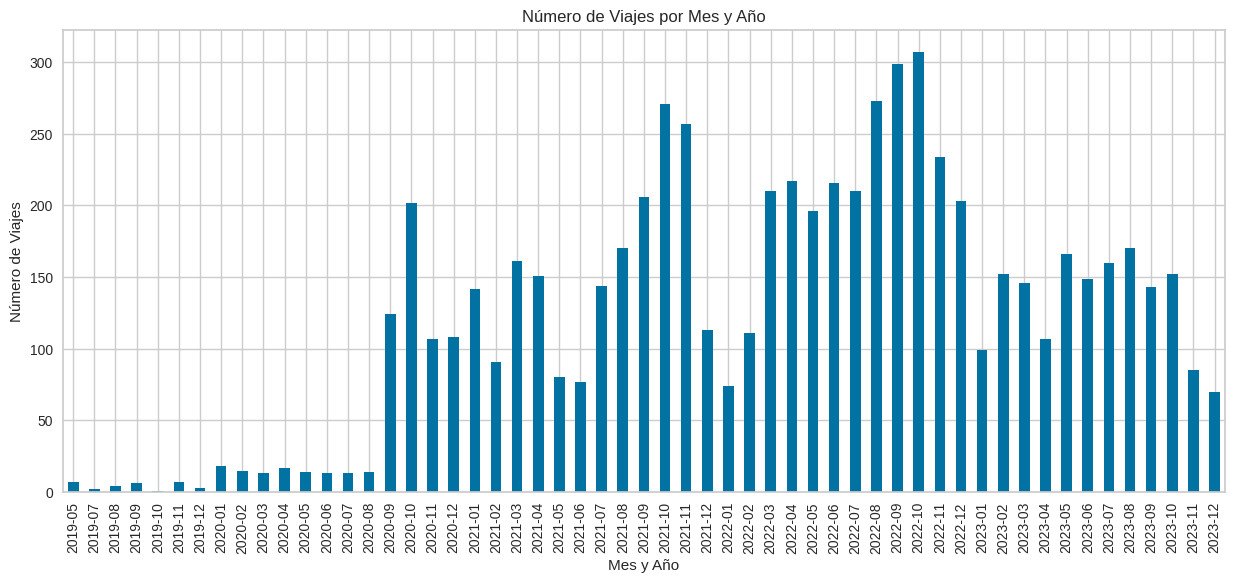

In [18]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["AÑO","MES","DIA",]].copy()
df_fechas['Fecha'] = df_fechas['AÑO'].astype(str) + '-' + df_fechas['MES'].astype(str) + '-' + df_fechas['DIA'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y contamos los viajes. Esto para facilitar
# la visualización de los datos
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')
conteo_viajes = df_fechas.groupby('Mes y Año').size()
conteo_viajes.head()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
conteo_viajes.plot(kind='bar')
plt.xlabel('Mes y Año')
plt.ylabel('Número de Viajes')
plt.title('Número de Viajes por Mes y Año')
plt.show()

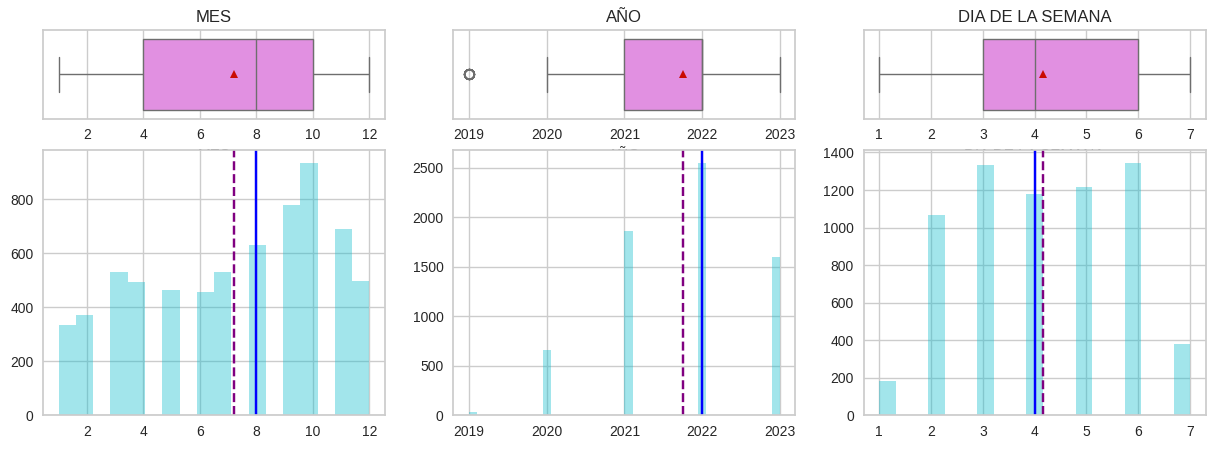

In [19]:
create_grid_of_plots(df, ["MES","AÑO","DIA DE LA SEMANA"])

- Con base en estas gráficas podemos ver que 2019 y 2020 tuvo una baja importante en viajes. Esto es debido a que anteriormente los registros eran en carpetas físicas, las cuales se perdieron debido a un incendio en la oficina.
- Podemos notar que entre Agosto y Noviembre, existe un patrón de una alza de viajes, lo que puede estar relacionado por la preparación de las empresas al fin de año. Esto puede significar una ventaja para TFL ya que puede prepararse para la carga de trabajo para estas fechas.
- El año con una mayor concentración de viajes fue 2022. Valdría la pena revisar las posibles causas de la baja para 2023. Ya sea por fuga de clientes o algún otro factor como alza de precios.
- Los días entre semana (lunes a viernes) son los días con mayor nivel de trabajo. Sábados y Domingos son los más bajos. El martes es el día con mayor nivel de viajes, seguido del Viernes.

#### Experiencia del Conductor

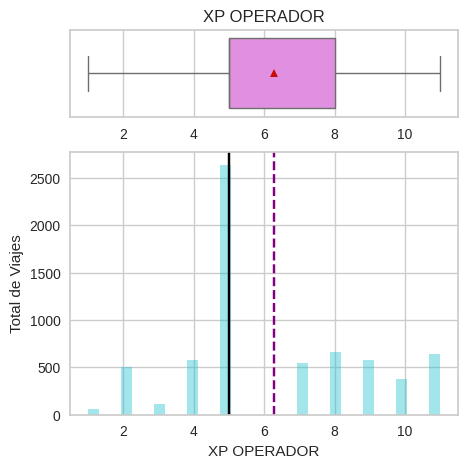

In [20]:
plot_histogram_boxplot(df, "XP OPERADOR")

- La mayor parte de los viajes son realizados por operadores con 5 años de experiencia. Esto va muy de acuerdo a lo visto en el análisis estadístico

#### Rendimiento Promedio del Vehículo

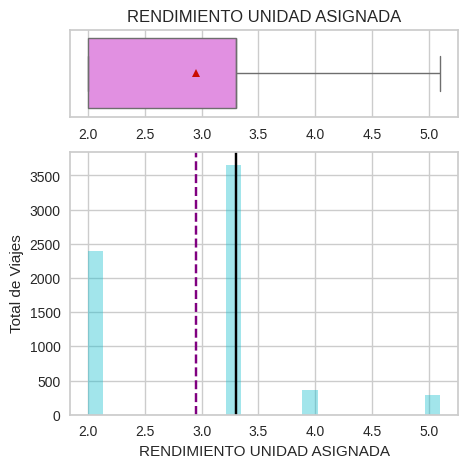

In [21]:
plot_histogram_boxplot(df, "RENDIMIENTO UNIDAD ASIGNADA")

- Podemos ver que existe una mayor concentración de viajes con bajo y medio rendimiento (2.0 y 3.3 respectivamente). Lo que nos habla de posibles problemas, como malos hábitos de manejo, robo de diesel, falta de mantenimiento de las unidades, unidades viejas, etc.
- Valdría la pena explorar en el análisis multivariable si existe alguna correlación entre la experiencia del conductor y el rendimiento, al igual que el rendimiento y el peso de la carga, o incluso el rendimiento y el vehículo seleccionado.

#### Capacidades Máximas del Vehículo

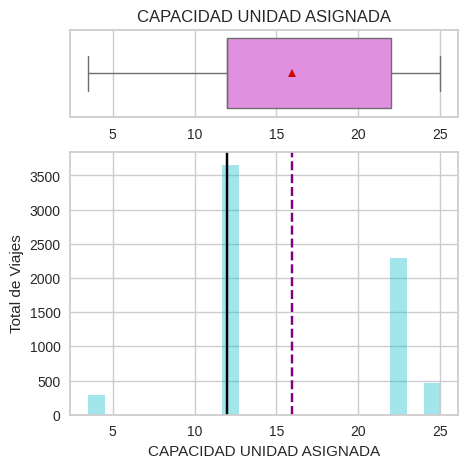

In [22]:
plot_histogram_boxplot(df, "CAPACIDAD UNIDAD ASIGNADA")

- La mayoría de los viajes realizados son con unidades de 11 toneladas, siendo los torton capaces de cubrir estas necesidades, consumiendo el menor combustible posible.
- En segundo lugar tenemos viajes de 22 o 23 toneladas, siendo cubiertos por los trailers.
- Sería importante buscar clientes que requieran los servicios de la camioneta para aumentar el porcentaje de viajes realizados para ese tonelaje.
#### Número de Pellets y Peso de la Carga

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


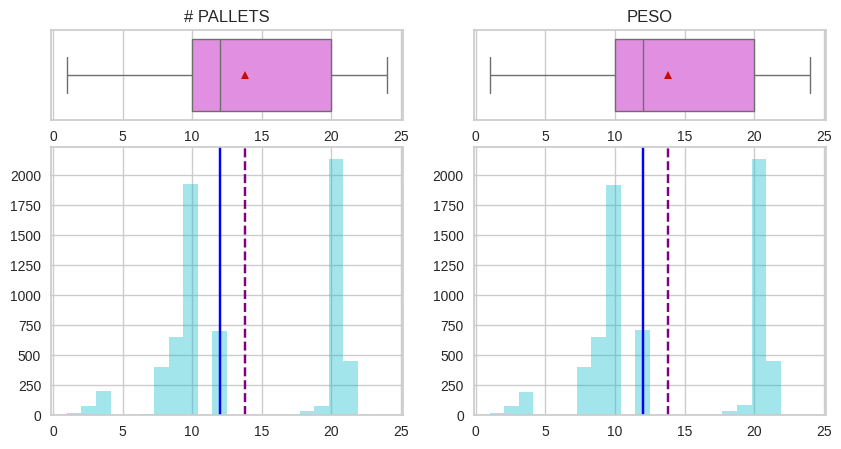

In [23]:
create_grid_of_plots(df, ["# PALLETS","PESO"])

- Podemos ver que de igual manera, estas dos variables son prácticamente idénticas, por lo que podemos precindir de una de ellas para reducir la complejidad del modelo. En este caso desecharemos el No. de Pellets.
- Podemos ver que la mayoría de los viajes llevan cargas de 20 y 13 toneladas.
- El promedio de peso por viaje es de 13 toneladas, lo que hace match con el promedio de carga máxima soportada.

In [24]:
# Removemos la columna con datos identicos
df.drop('# PALLETS', axis=1, inplace=True)

### Precio del Viaje

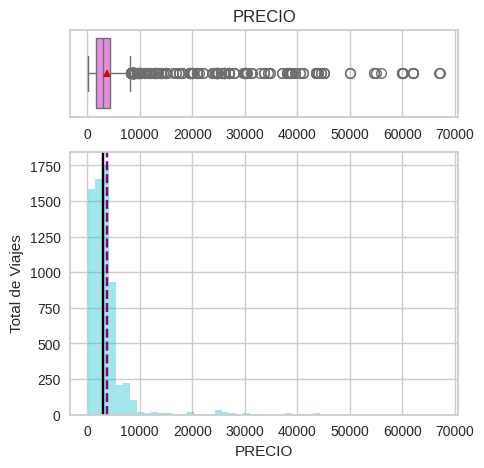

In [25]:
plot_histogram_boxplot(df, "PRECIO")

- Podemos ver que la mayoría de los viajes tienen un precio máximo de \$10,000
- Muy pocos viajes son de más de \$10,000.
- Los precios parecieran no estar estandarizados, por lo que valdría la pena revisar los motivos para esto.
- El precio promedio por viaje es de aproximadamente de \$3,500

#### Distancia de los viajes

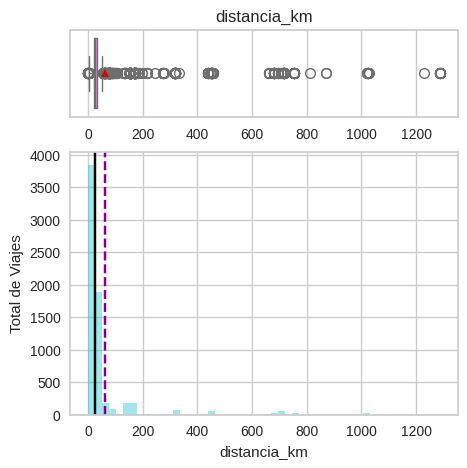

In [26]:
plot_histogram_boxplot(df, "distancia_km")

- Podemos ver que existe una forma muy similar entre la distancia viajada vs. el precio de cada viaje. Valdría la pena revisitar esto con mayor detalle en el análisis multivariable.
- La mayor parte de los viajes son de menos de 250km


Hecho este análisis, procederemos a hacer lo mismo para las variables categóricas o tipo objeto.

### Variables Tipo Objeto

In [27]:
# Esta función nos permite generar la gráfica de barras para una variable
# categórica, mostrando su porcentaje en la parte superior de la gráfica
def perc_on_bar(data,z, ax2 = None, size =(15, 6)):
    total = len(data[z])
    if ax2 == None:
      plt.figure(figsize=size)
      ax = sns.countplot(data= data, x = z,palette='Paired')
    else:
      ax = sns.countplot(data= data, x = z,ax = ax2,palette='Paired')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()
        y = p.get_y() + p.get_height()+15
        ax.set_title(z)
        ax.set_ylabel('Total de Viajes')
        ax.annotate(percentage, (x, y), size = 10)

# Esta función genera una matriz de gráficas de barras
def create_grid_of_perc_on_bar(data, cols, figsize=(30, 10)):
    num_rows = int(np.ceil(len(cols) / 3))
    if len(cols) < 3:
      num_cols = len(cols)
    else:
      num_cols = 3

    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(nrows = num_rows, ncols=num_cols, figsize=figsize)
    if num_rows == 1:
      for i, col in enumerate(cols):
        ax2 = axes[i]
        perc_on_bar(data, col, ax2)

    else:
      row = -1
      for i, col in enumerate(cols):
          if i%3==0:
            row+=1
          print(row,i%3)
          ax2 = axes[row,i%3]
          perc_on_bar(data, col, ax2)

    plt.tight_layout()
    plt.show()

### Cliente

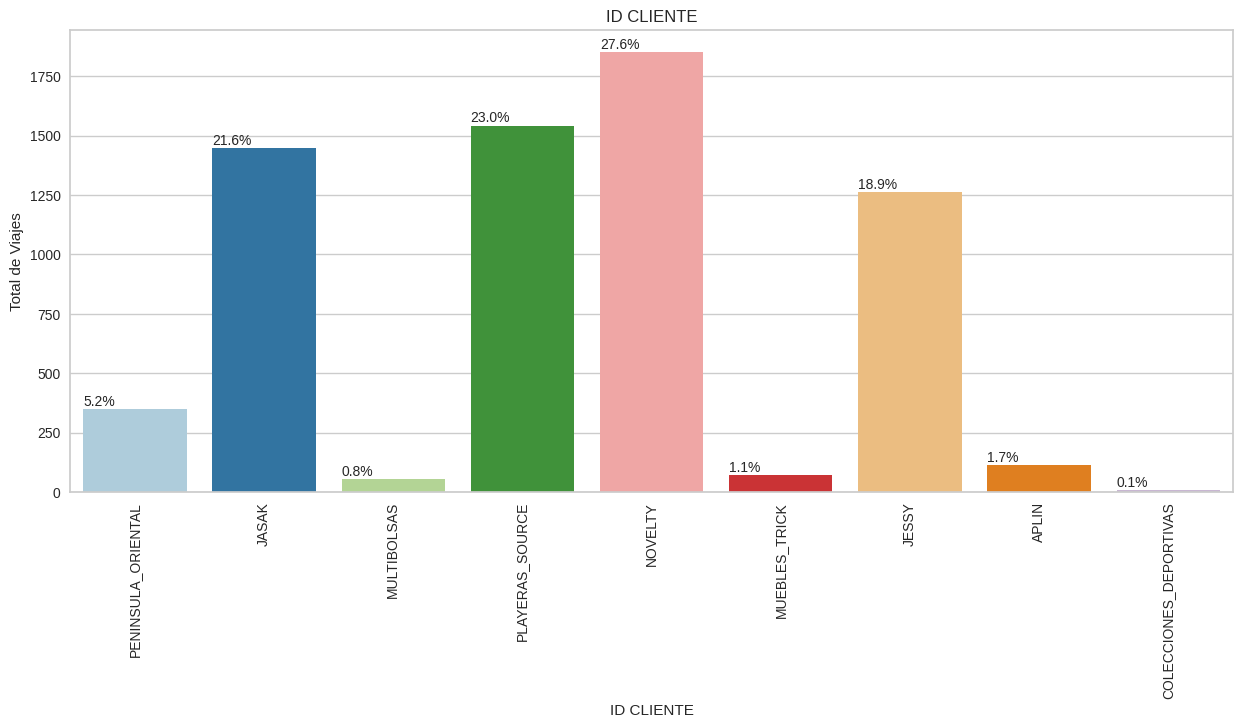

In [28]:
perc_on_bar(df, "ID CLIENTE")

- Como se mencionaba en puntos anteriores, existe una diferencia significativa en el porcentaje de viajes de los clientes prioritarios y los secundarios.
- NOVELTY cuenta con el 26.2% del total de viajes
- Su cliente con menos viajes es colecciones deportivas con el 0.1%

#### Conductor

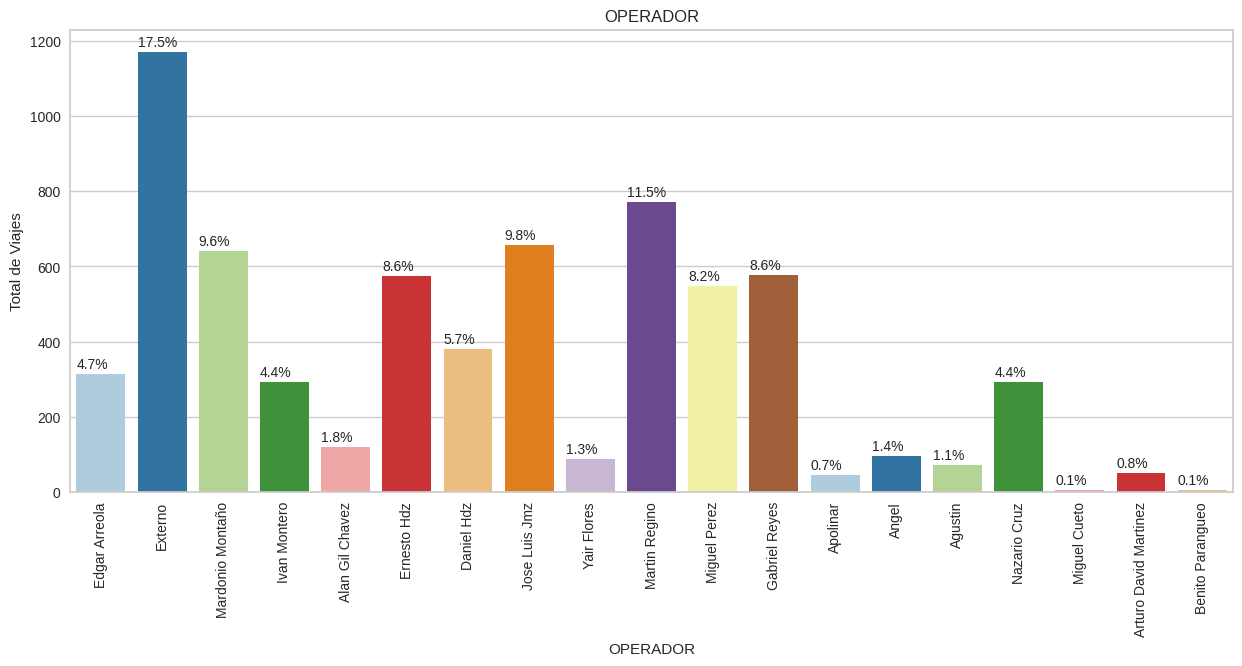

In [29]:
perc_on_bar(df, "OPERADOR")

- En esta gráfica podemos ver que el 17.5% de los viajes son realizados por conductores externos, lo que nos habla de una falta de capacidad para completar las operaciones. Esto puede ser por fuga de personal o por un crecimiento estancado de la empresa.
- El conductor con mayor porentaje de viajes es Martin Regino con el 11.5%
- El conductor con menor porcentaje de viajes es Benito Parangueo con 0.1%
- Hay que revisar el status de cada conductor a ver si existe alguna correlación entre con su porcentaje de viajes.

#### Status de Conductor

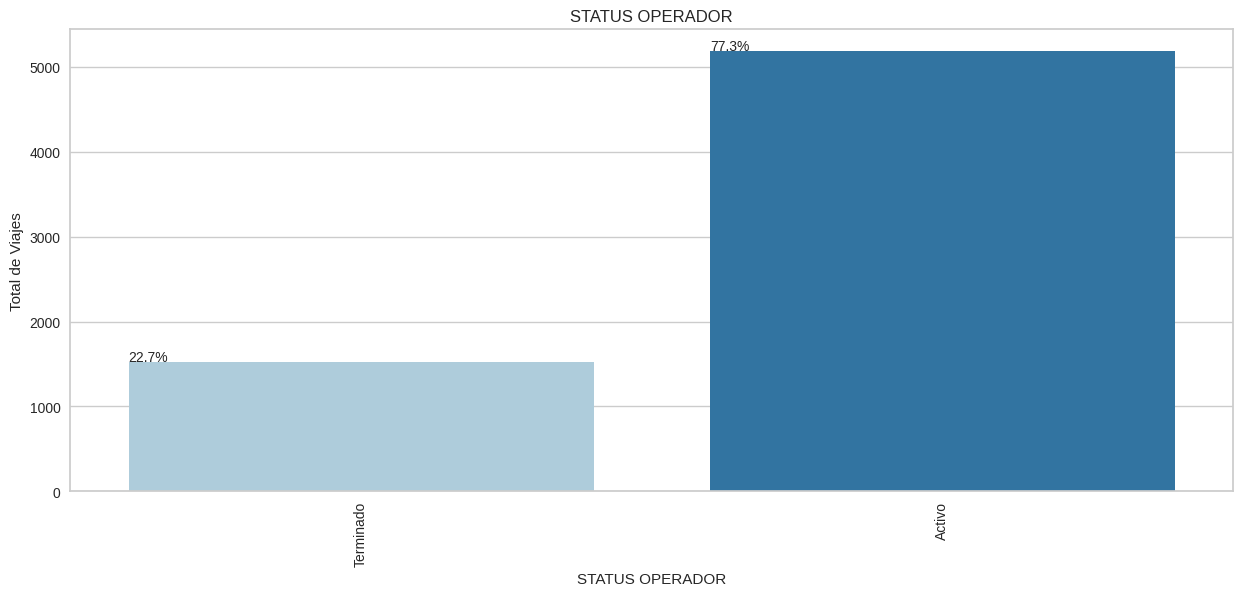

In [30]:
perc_on_bar(df, "STATUS OPERADOR")

- El 77.3% de los viajes realizados fueron hechos por conductores aún activos
- Valdría la pena revisar si existe alguna correlación entre los conductores terminados y los viajes incompletos.

#### Tipo de Servicio Solicitado

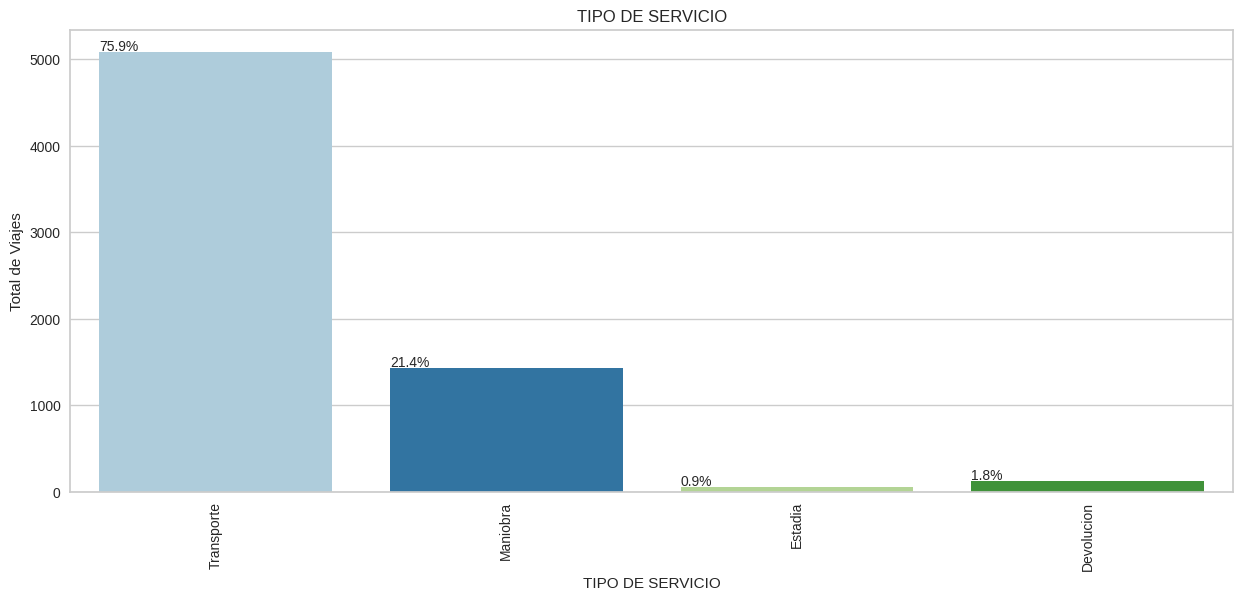

In [31]:
perc_on_bar(df, "TIPO DE SERVICIO")

- Podemos ver que los principales servicios de TFL son el transporte de mercancías (75.9%) y las maniobras (21.4%)
- La estadía y el rechazo tienen un diferencia abismal comparado con el resto de los servicios. Esto es debido a que estos son complementos de los servicios de Transporte y Maniobra

#### Tipo de Vehiculo Solicitado

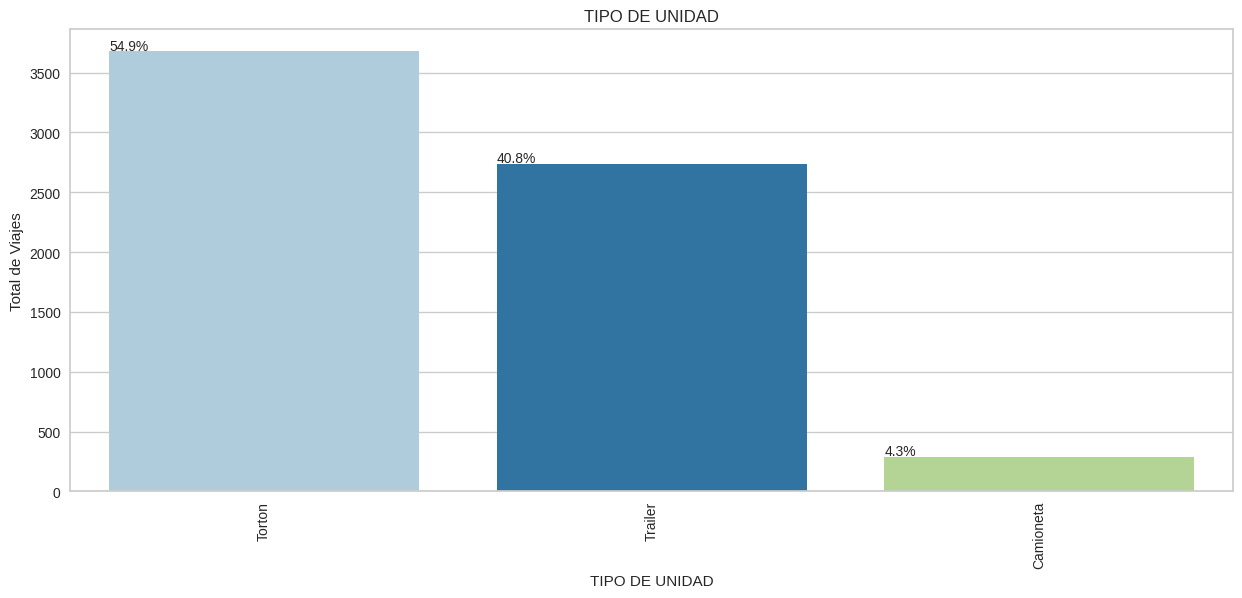

In [32]:
perc_on_bar(df, "TIPO DE UNIDAD")

- El tipo de vehículo que más se solicita son los torton (54.9%) y trailer con 40.8%, esto puede ser por el tipo de cargamento y el peso de este, que manejan los clientes con mayor frecuencia.
- Esto puede ser un indicador sobre qué tipo de vehículos son los que más unidades deben existir en la flotilla
- En el caso de la camioneta, valdría la pena revisar si el bajo porcentaje de viajes puede provenir de una falta de conocimiento de la existencia del servicio por parte de los clientes o si se debe buscar otro tipo de clientes más afines a usar este tipo de vehículo.

#### Tipo de Vehículo Asignado

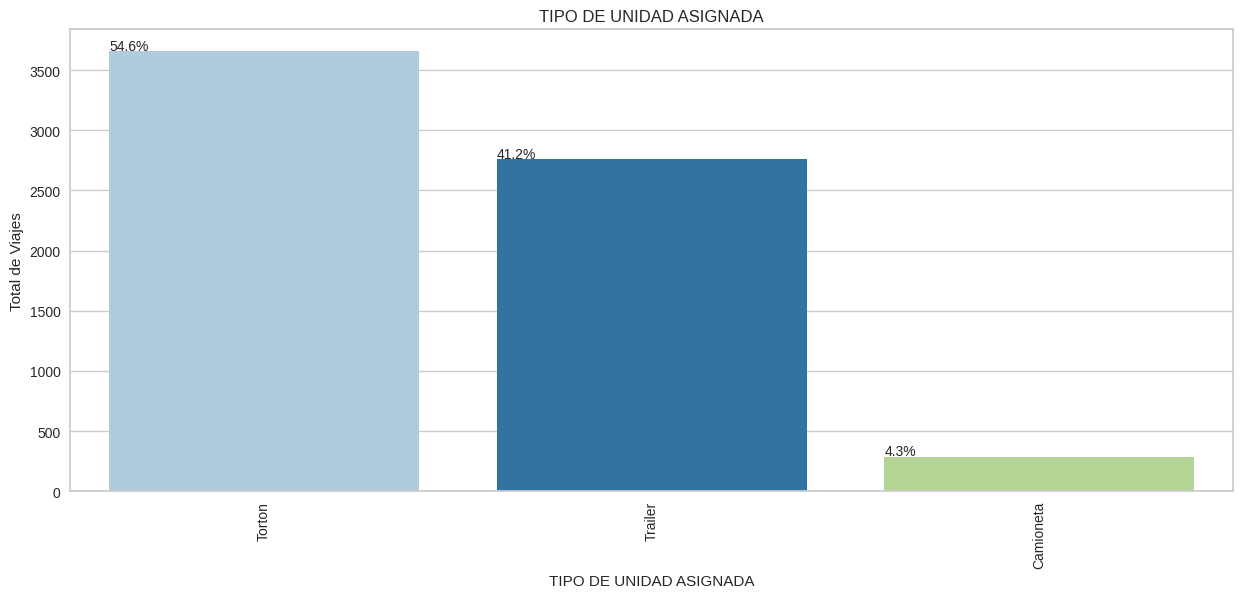

In [33]:
perc_on_bar(df, "TIPO DE UNIDAD ASIGNADA")

- Podemos ver que existe una gran similitud en la forma de cada categoría, mostrando que se cubren las necesidades del cliente en la mayoría de los casos.

#### ID de las cajas y de los vehículos asignados

<Figure size 3000x1000 with 0 Axes>

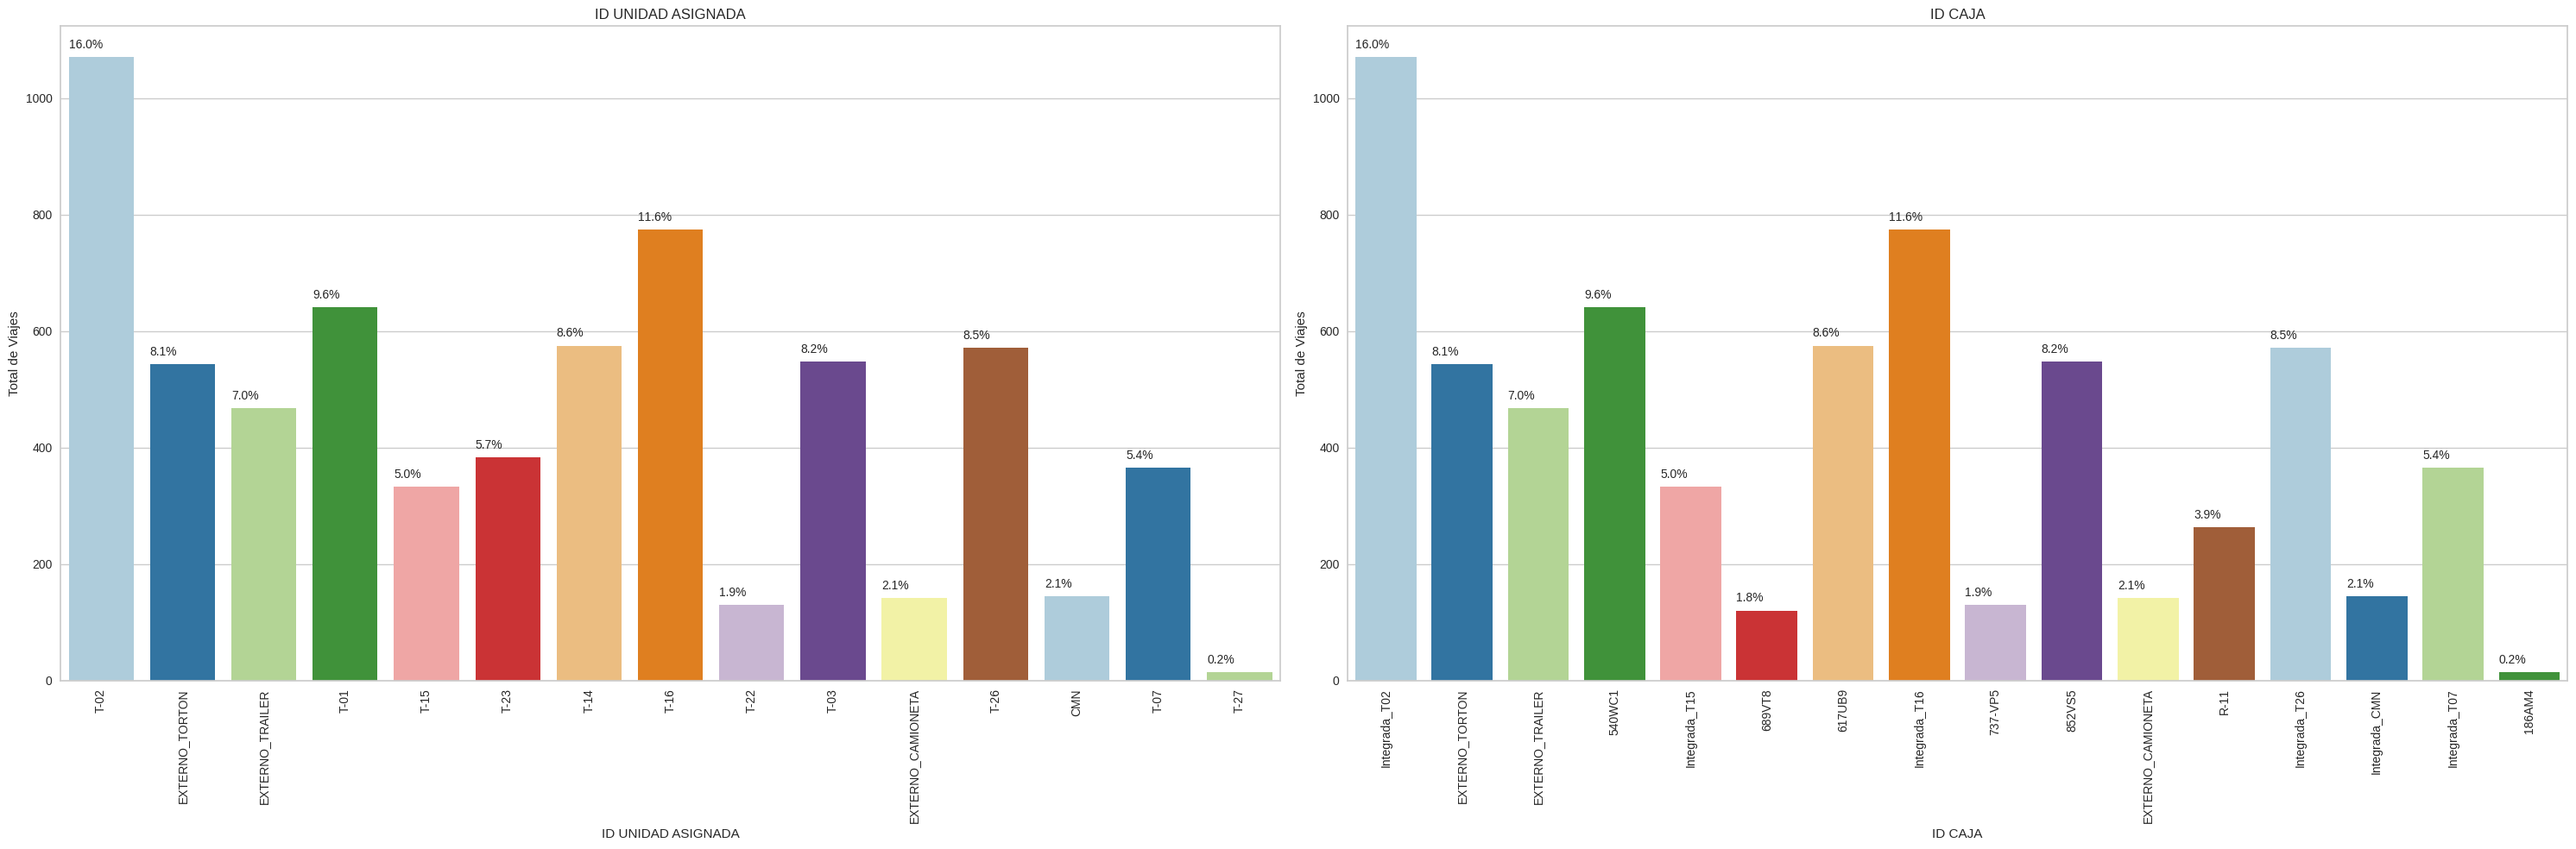

In [34]:
create_grid_of_perc_on_bar(df, ["ID UNIDAD ASIGNADA", "ID CAJA"])

- Podemos ver que son prácticamente idénticos ambos features, por lo que podemos eliminar uno para evitar redundancia y reducir la complejidad del modelo. En este caso removeremos el ID de la caja seca.
- Podemos ver que el vehículo disonible más asignado es el T-02, siendo un Torton Freightliner 1997, con una capacidad de 12 Toneladas
- Igual podemos ver la tendencia de asignar vehículos externos para cubrir la demanda de los clientes

In [35]:
# Removemos la columna con datos identicos
df.drop('ID CAJA', axis=1, inplace=True)

#### Tipo de Cargamento

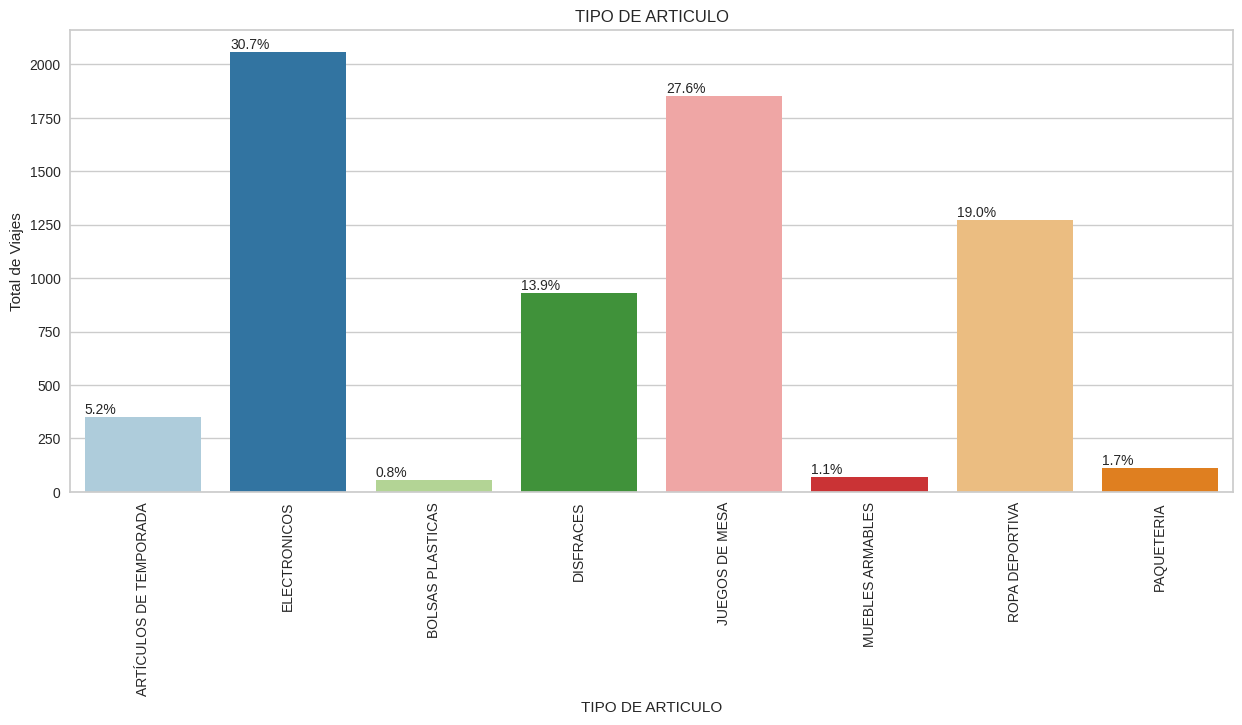

In [36]:
perc_on_bar(df, "TIPO DE ARTICULO")

- El tipo de cargamento con mayor cantidad de viajes son Electrónicos y en segundo lugar son los juegos de mesa

#### Tipo de Empaquetado de la Mercancía


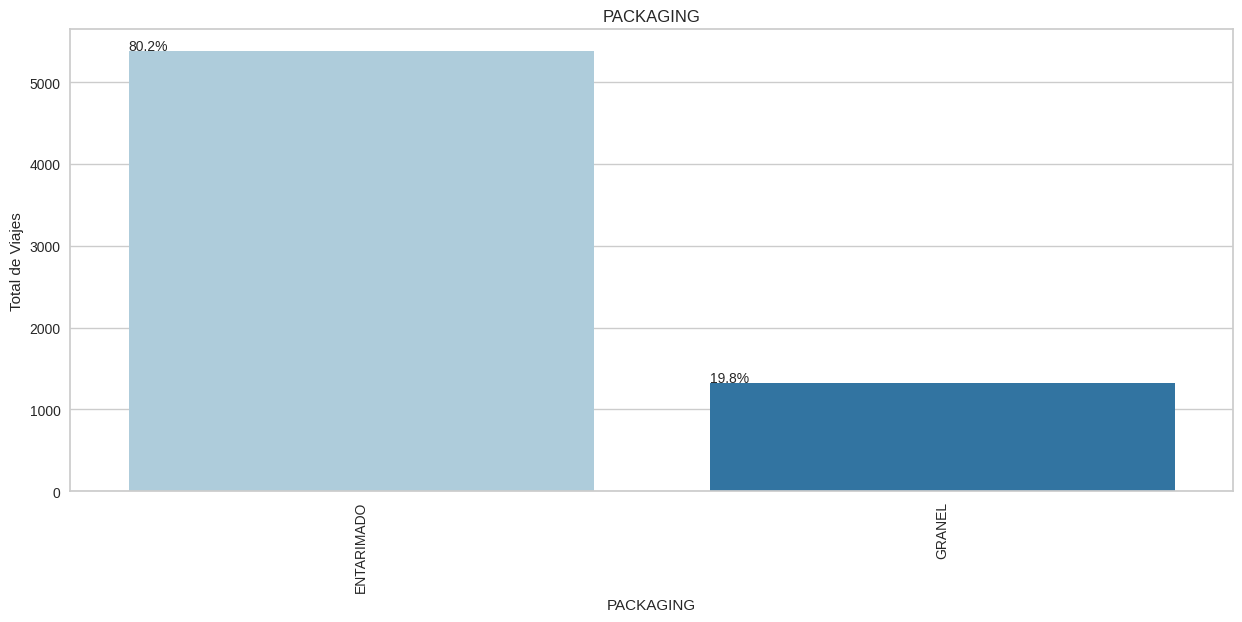

In [37]:
perc_on_bar(df, "PACKAGING")

- El 80% de sus mercancias son entarimadas, mientras que el 19.4% están a Granel
- Valdría la pena revisar si existe alguna correlación entre el tipo de empaquetado y el status del viaje para descartar que esto pueda ser un factor que afecte la seguridad de la carga

#### Status de Orden

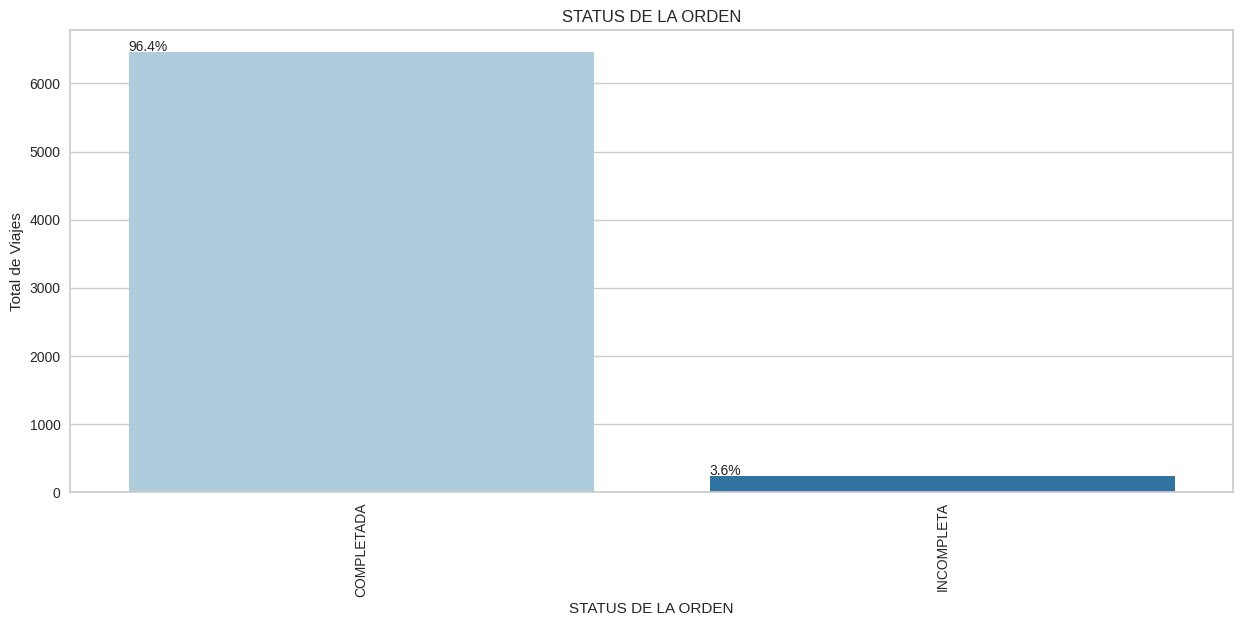

In [38]:
perc_on_bar(df, "STATUS DE LA ORDEN")

- Podemos ver que TFL cumple con el 96% de sus viajes
- Este desbalance del feature podría causar problemas al momento de entrenar el modelo, por lo que se tendrá que balancear la clase para evitar algún sesgo


Ya terminado el análisis univariable podemos proceder al análisis multivariable. En este análisis podemos ver la correlación de los datos, patrones, etc.

## Análisis Multivariable

### Correlación de los datos numéricos

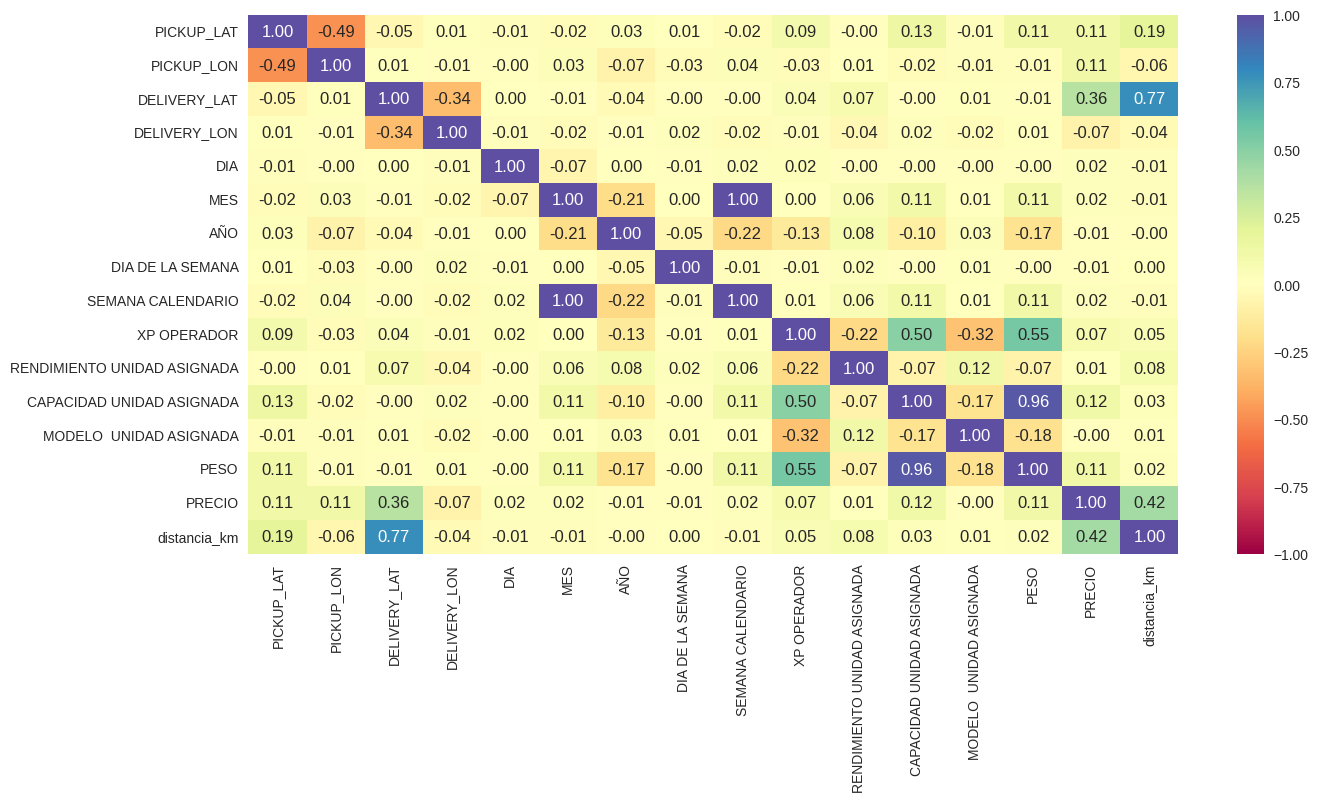

In [39]:
plt.figure(figsize=(15,7))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

- Podemos ver que existe una correlación positiva entre el precio del viaje y la distancia en Km de este. Esto suena lógico porque a más distancia, mayor el consumo de combustible, ergo, costos mas elevados. Sin embargo, esta es medianamente fuerte, por lo que sugiere que no hay una estandarización de precios.
- Existe una correlación fuerte entre las cargas más pesadas y los conductores más experimentados. Esto parece ser correcto por la necesidad de un mejor manejo de la unidad y un mejor conocimiento del camino
- De igual manera existe una correlación fuerte entre el peso de la carga y la capacidad de máxima de la carga, lo que suena lógico debido a que dependiendo la carga, se seleccionará que vehículo puede soportar el peso.
- Existe una ligera correlación negativa entre el peso de la carga y el año del vehículo, mostrando que se le asigan los viajes más pesados a las unidades más antiguas, probablemente debido a su capacidad. Esto puede presentar un posible riesgo de fallas durante el trayecto.
- No existe una correlación relevante entre la experiencia del conductor y el rendimiento del combustible.
- Existe una ligera correlación positiva entre el año del vehículo y el rendimiento, mostrando que las unidades más nuevas tienen un rendimiento mejor.
- Existen 2 correlaciones que son básicamente 1: Semana Calendario vs. Mes y Capacidad Unidad vs. Peso. Por lo que podemos eliminar 1 variable de cada par.

In [40]:
# Removemos la columna con datos identicos
df.drop('CAPACIDAD UNIDAD ASIGNADA', axis=1, inplace=True)
df.drop('SEMANA CALENDARIO', axis=1, inplace=True)

### Análisis Multivariable

#### Fecha de Viaje vs. Precio del Viaje

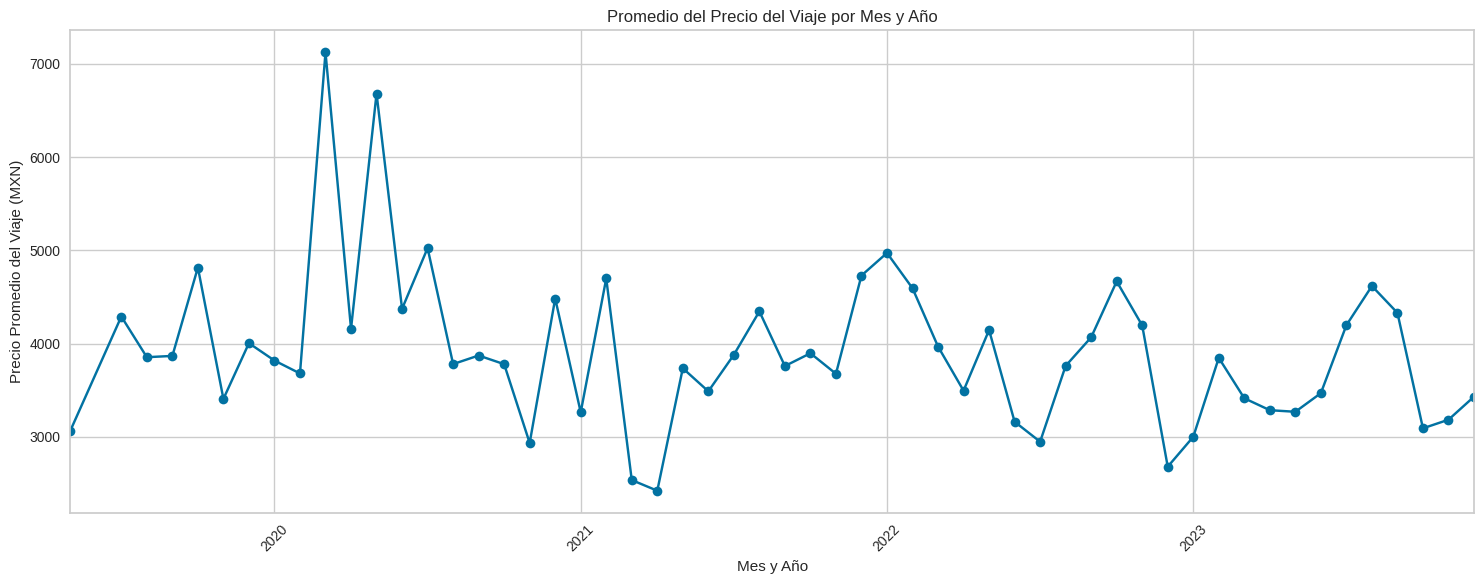

In [41]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["AÑO","MES","DIA","PRECIO"]].copy()
df_fechas['Fecha'] = df_fechas['AÑO'].astype(str) + '-' + df_fechas['MES'].astype(str) + '-' + df_fechas['DIA'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

promedio_precios = df_fechas.groupby('Mes y Año')['PRECIO'].mean()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
promedio_precios.plot(kind='line', marker='o')
plt.title('Promedio del Precio del Viaje por Mes y Año')
plt.xlabel('Mes y Año')
plt.ylabel('Precio Promedio del Viaje (MXN)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- Podemos ver que los precios más elevados se tuvieron entre el 2019 y 2020, llegando a un promedio entre \$7,500 MXN.
- En los siguientes años se estabilizó entre los \$3,000 y $5,000
- La alza de precios puede significar algún cambio dentro de la empresa o en los clientes. De igual manera la Pandemia pudo haber sido factor.

#### Fecha vs. Status de Orden

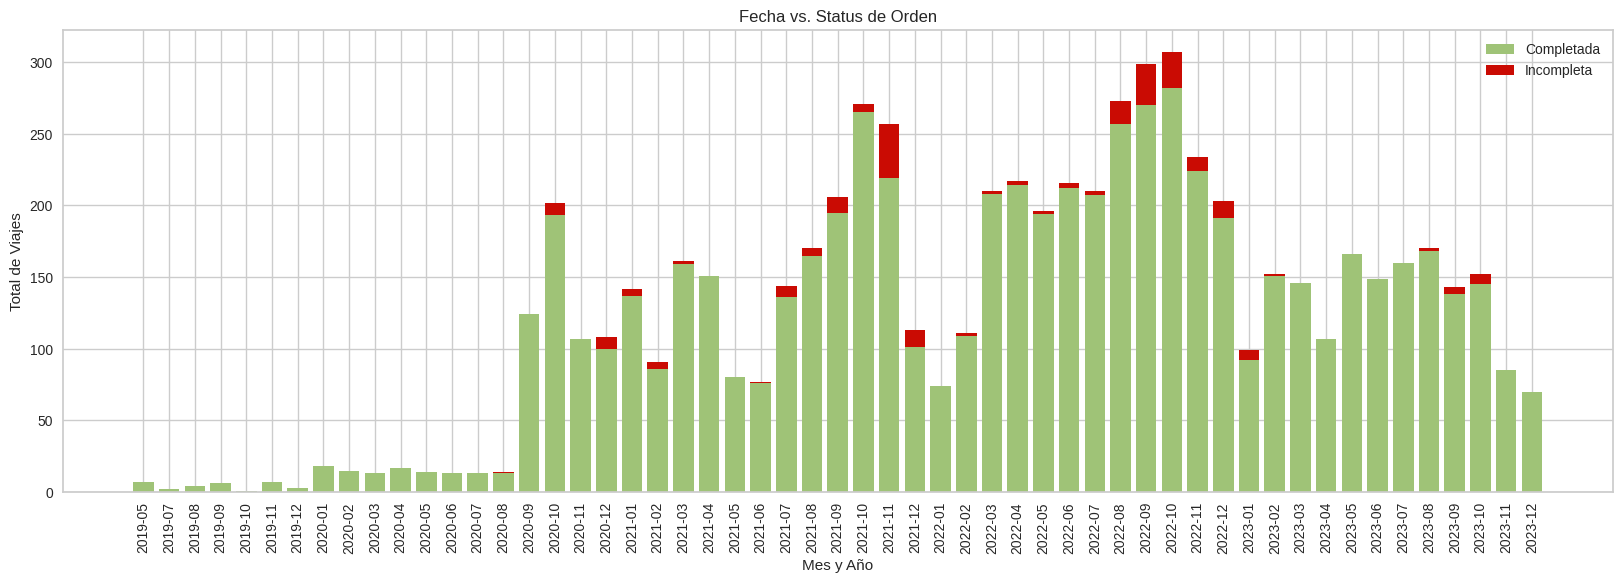

In [42]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["AÑO","MES","DIA","STATUS DE LA ORDEN"]].copy()
df_fechas['Fecha'] = df_fechas['AÑO'].astype(str) + '-' + df_fechas['MES'].astype(str) + '-' + df_fechas['DIA'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

stacked_data = df_fechas.groupby(['Mes y Año', 'STATUS DE LA ORDEN']).size().unstack(fill_value=0)
stacked_data.index = stacked_data.index.astype(str)
plt.figure(figsize=(20, 6))
plt.bar(stacked_data.index, stacked_data['COMPLETADA'], color='g')
plt.bar(stacked_data.index, stacked_data['INCOMPLETA'], bottom=stacked_data['COMPLETADA'], color='r')
plt.xlabel("Mes y Año")
plt.ylabel("Total de Viajes")
plt.legend(["Completada", "Incompleta"])
plt.title("Fecha vs. Status de Orden")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

- Existe un patrón entre el periodo agosto-noviembre y el ratio de ordenes incompletas. Probablemente esto es debido a que es temporada alta para las empresas y hay problemas de logistica.
- Noviembre de 2021 fue el mes con mayor nivel de ordenes incompletas

#### Conductor vs. Status de Orden


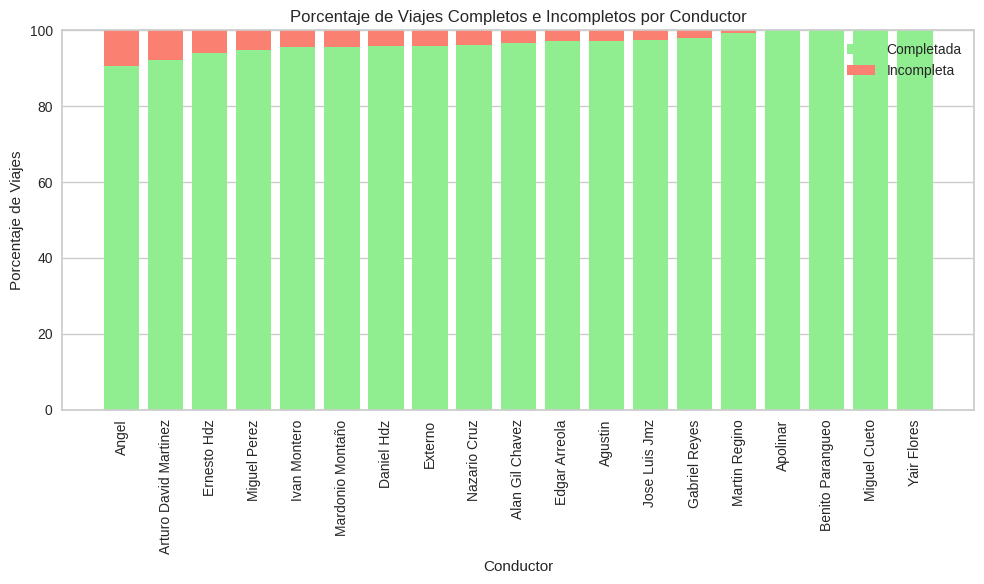

In [43]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_conductor = df.groupby('OPERADOR')['STATUS DE LA ORDEN'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_conductor['Total'] = viajes_por_conductor.sum(axis=1)
viajes_por_conductor['Porcentaje_Completado'] = viajes_por_conductor['COMPLETADA'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor['Porcentaje_Incompleto'] = viajes_por_conductor['INCOMPLETA'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor = viajes_por_conductor.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_conductor['Porcentaje_Completado'], color='salmon')
plt.xlabel('Conductor')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Conductor')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


- Angel es el chofer con mayor número de viajes incompletos, seguido de Arturo, Ernesto Hernandez y Miguel Perez
- El porcentaje de viajes completos es bastante bueno de cualquier manera. Es mayor a 90% en todos
####  Conductor vs. Experiencia vs. Status del Conductor

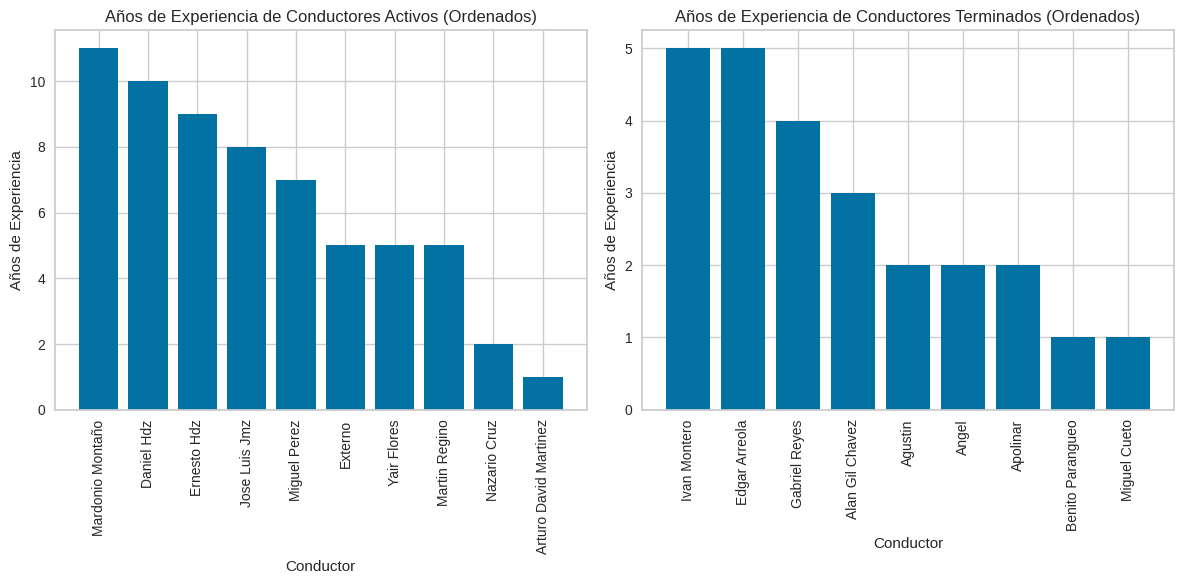

In [44]:
# Filtramos el DataFrame para conductores con estado "Activo" y "Terminado"
df_activo = df[df["STATUS OPERADOR"] == "Activo"].copy()
df_terminado = df[df["STATUS OPERADOR"] == "Terminado"].copy()

# Calculamos los años de experiencia para cada conductor
años_de_experiencia_activo = df_activo.groupby('OPERADOR')['XP OPERADOR'].mean()
años_de_experiencia_terminado = df_terminado.groupby('OPERADOR')['XP OPERADOR'].mean()

# Ordenamos los conductores por años de experiencia de mayor a menor
años_de_experiencia_activo = años_de_experiencia_activo.sort_values(ascending=False)
años_de_experiencia_terminado = años_de_experiencia_terminado.sort_values(ascending=False)

# Creamos una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficamos para conductores "Activo"
axs[0].bar(años_de_experiencia_activo.index, años_de_experiencia_activo)
axs[0].set_xlabel('Conductor')
axs[0].set_ylabel('Años de Experiencia')
axs[0].set_title('Años de Experiencia de Conductores Activos (Ordenados)')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)
# Graficamos para conductores "Terminado"
axs[1].bar(años_de_experiencia_terminado.index, años_de_experiencia_terminado)
axs[1].set_xlabel('Conductor')
axs[1].set_ylabel('Años de Experiencia')
axs[1].set_title('Años de Experiencia de Conductores Terminados (Ordenados)')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

# Ajustamos el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Podemos ver que 8 de sus 10 choferes cuentan con más de 4 años de experiencia por lo que podemos decir que tienen la mayor parte de sus conductores son experimentados.
- Sus choferes más experimentados son Maradonio Tirso y Jose Daniel Hernandez

#### Conductor vs. ID del Vehiculo Asignado

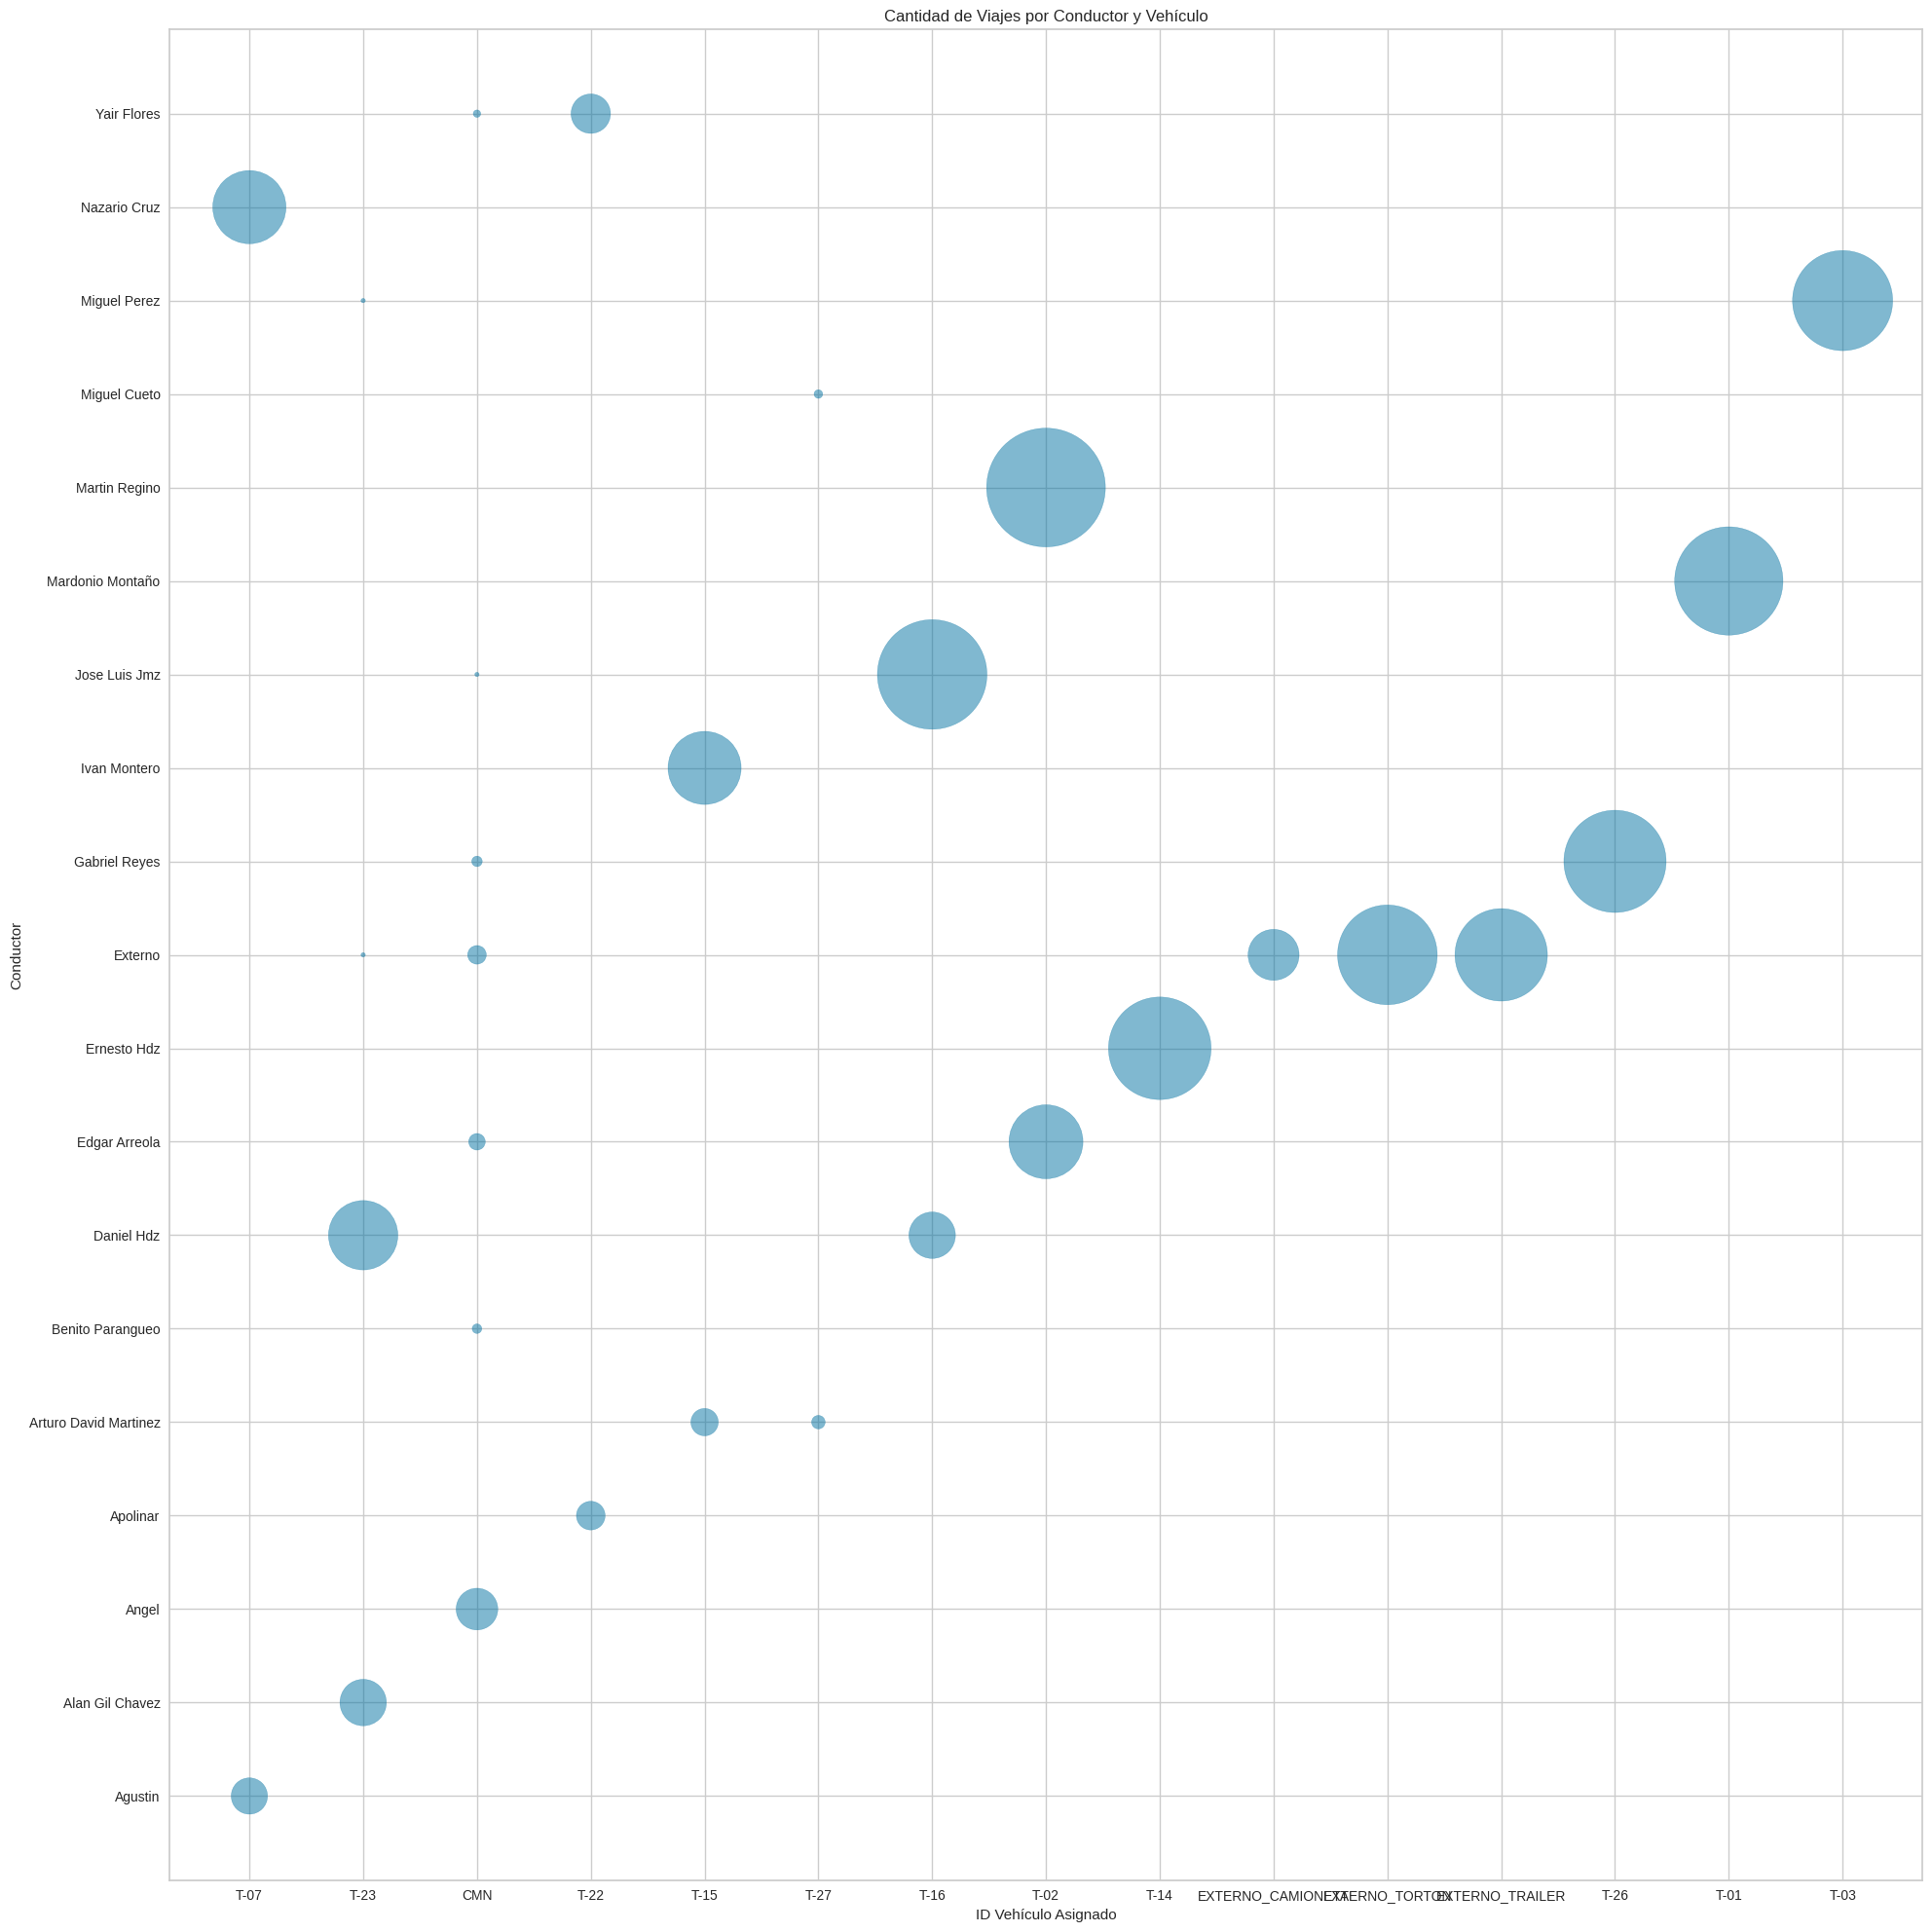

In [45]:
# Contar cuántas veces aparece cada combinación de conductor y vehículo asignado
conteo_conductor_vehiculo = df.groupby(['OPERADOR', 'ID UNIDAD ASIGNADA']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_vehiculo['ID UNIDAD ASIGNADA'], conteo_conductor_vehiculo['OPERADOR'], s=conteo_conductor_vehiculo['Count']*10, alpha=0.5)
plt.xlabel('ID Vehículo Asignado')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Vehículo')
plt.tight_layout()
plt.show()

- Esta gráfica es bastante interesante porque nos permite ver la concentración de viajes por cada combinación.
- Aquí podemos ver que incluso conductores locales han utilizado vehículos externos y viceversa, conductores externos han usado vehículos locales.
- Las combinaciones más prominentes son:
  * Jose Martin Regino Lopez con el vehículo T-02
  * Maradonio Tirso Montano con el vehículo T-01
  * Miguel Perez Santarosa con el vehículo T-03
  * Jose Luis Jimenez con el T-16
  * Gabriel Reyes con el T-26


#### Conductor vs Rendimiento Promedio del Vehículo Asignado

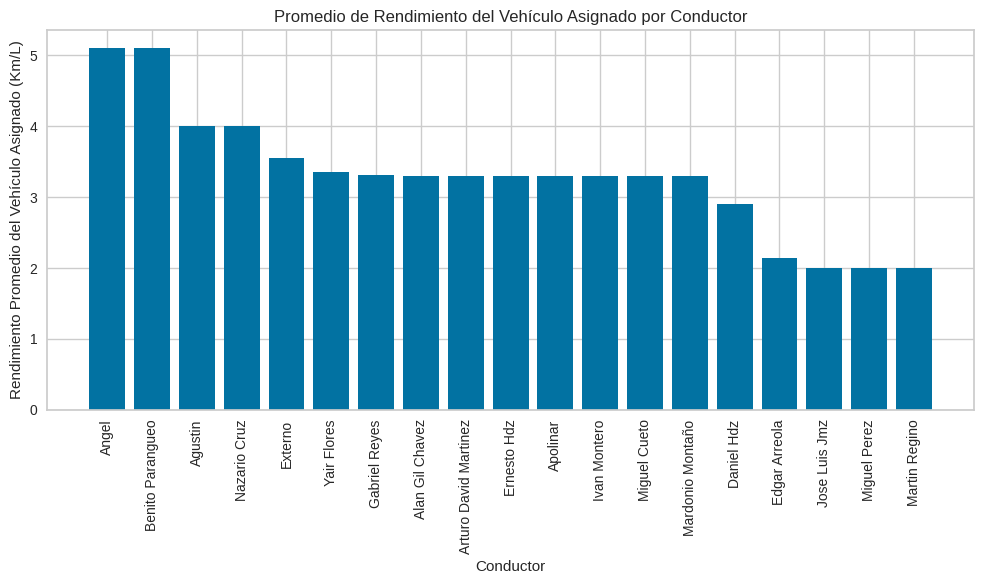

In [46]:
# Agrupar por conductor y calcular el promedio de los rendimientos promedio de los vehículos asignados
rendimiento_promedio_por_conductor = df.groupby('OPERADOR')['RENDIMIENTO UNIDAD ASIGNADA'].mean()
rendimiento_promedio_por_conductor = rendimiento_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(rendimiento_promedio_por_conductor.index, rendimiento_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Rendimiento Promedio del Vehículo Asignado (Km/L)')
plt.title('Promedio de Rendimiento del Vehículo Asignado por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- Podemos ver que los conductores con mayor rendimiento son Benito Parangueo, Angel, Agustin y Nazario
-  El promedio esta alrededor de los 3Km/L
- Los conductores con menor rendimiento promedio son Jose Luis Jimenez, Miguel Perez Santarosa y Jose Martin Regino

#### Conductor vs. Precio del Viaje

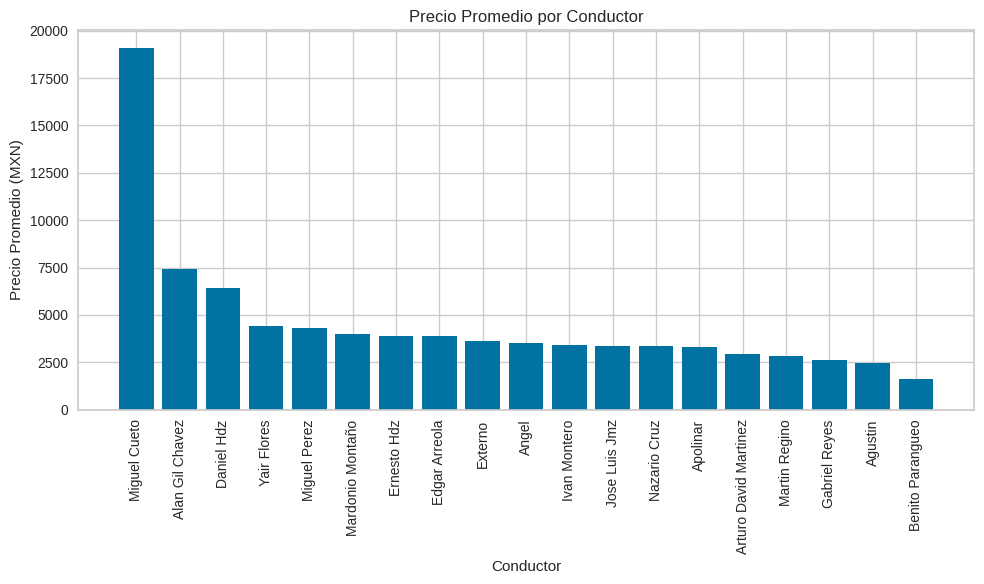

In [47]:
# Agrupar por conductor y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_conductor = df.groupby('OPERADOR')['PRECIO'].mean()
precio_promedio_por_conductor = precio_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_conductor.index, precio_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto por mucho se ha llevado los viajes más caros (más de \$17,500 en promedio)
- El resto de los conductores están dentro del rango de entre \$7,500 y \$2,500 en promedio.

#### Conductor vs. Peso de la Carga vs. Tipo de Vehiculo Asignado

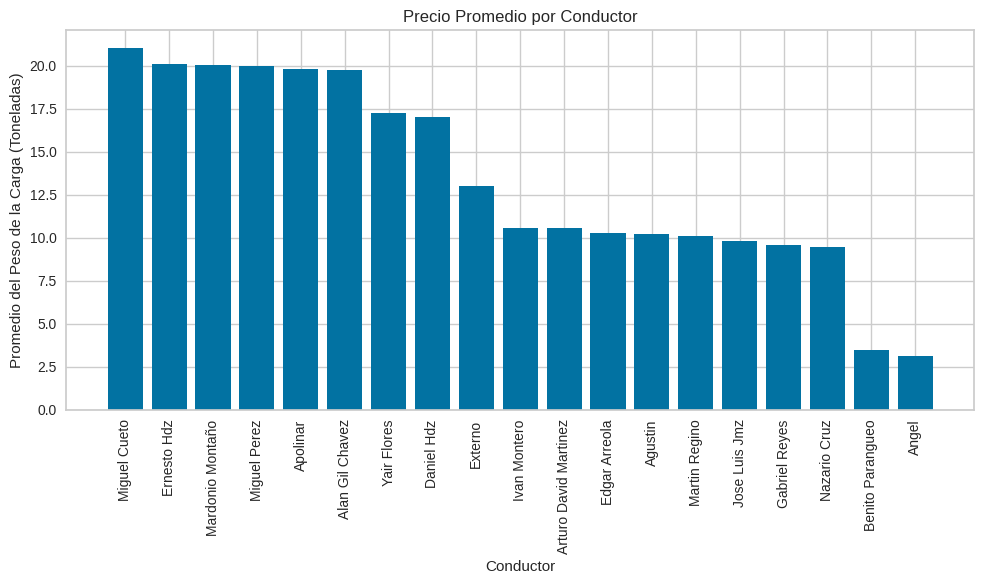

In [48]:
# Agrupar por conductor y calcular el promedio del peso de la carga
Peso_de_la_carga_por_conductor = df.groupby('OPERADOR')['PESO'].mean()
Peso_de_la_carga_por_conductor = Peso_de_la_carga_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(Peso_de_la_carga_por_conductor.index, Peso_de_la_carga_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Promedio del Peso de la Carga (Toneladas)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto, Ernesto Hernandez, Miguel Perez Satnarosa, Maradonio Tirso, Apolinar y Alan Gil Chavez son los coductores que mayor peso manejan en promedio en sus viajes.
- Angel y Benito Parangueo son los que menos peso cargan en sus viajes

#### Cliente vs. Precio del Viaje

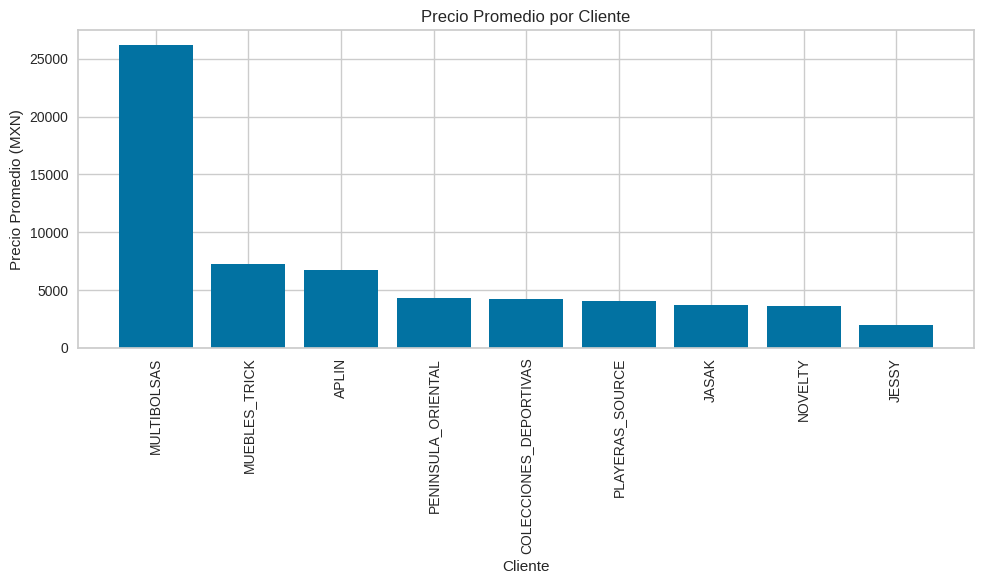

In [49]:
# Agrupar por cliente y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_cliente = df.groupby('ID CLIENTE')['PRECIO'].mean()
precio_promedio_por_cliente = precio_promedio_por_cliente.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_cliente.index, precio_promedio_por_cliente)
plt.xlabel('Cliente')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Cliente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Multibolsas tiene en promedio el precio más elevado por mucha diferencia con el resto de los clientes (arriba de \$25,000)
- Jessy es el cliente con menor precio (Debajo de los \$2,500)

#### Cliente vs. Status de Orden

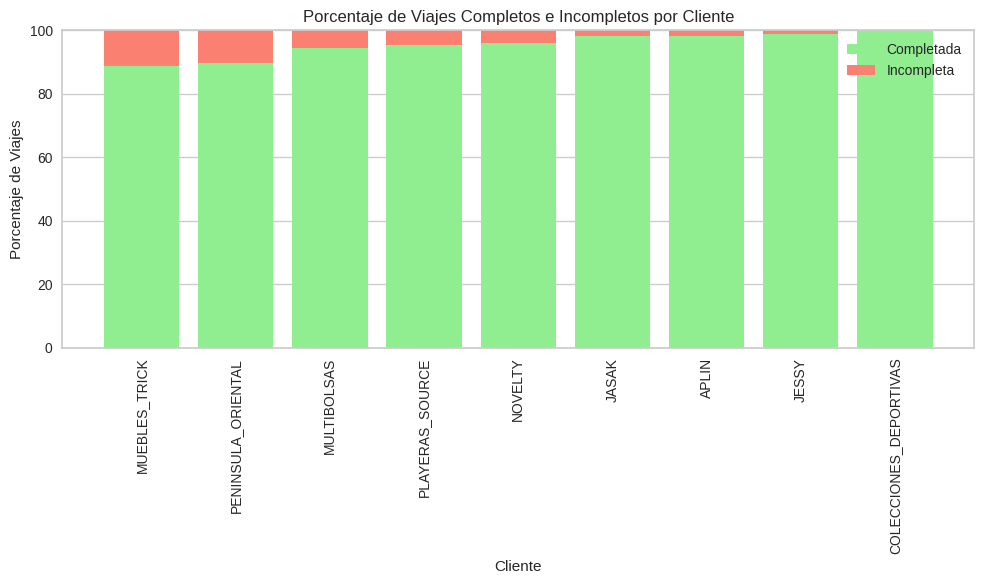

In [50]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_cliente = df.groupby('ID CLIENTE')['STATUS DE LA ORDEN'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_cliente['Total'] = viajes_por_cliente.sum(axis=1)
viajes_por_cliente['Porcentaje_Completado'] = viajes_por_cliente['COMPLETADA'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente['Porcentaje_Incompleto'] = viajes_por_cliente['INCOMPLETA'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente = viajes_por_cliente.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_cliente['Porcentaje_Completado'], color='salmon')
plt.xlabel('Cliente')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Cliente')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


- Muebles Trick tiene el porcentaje más bajo de entregas completadas, con un 90% de viajes completados aproximadamente. Aún así es un buen porcentaje de viajes completados.
- Colecciones deportivas es el único cliente con el 100% de sus viajes completados

#### Cliente vs. Conductor

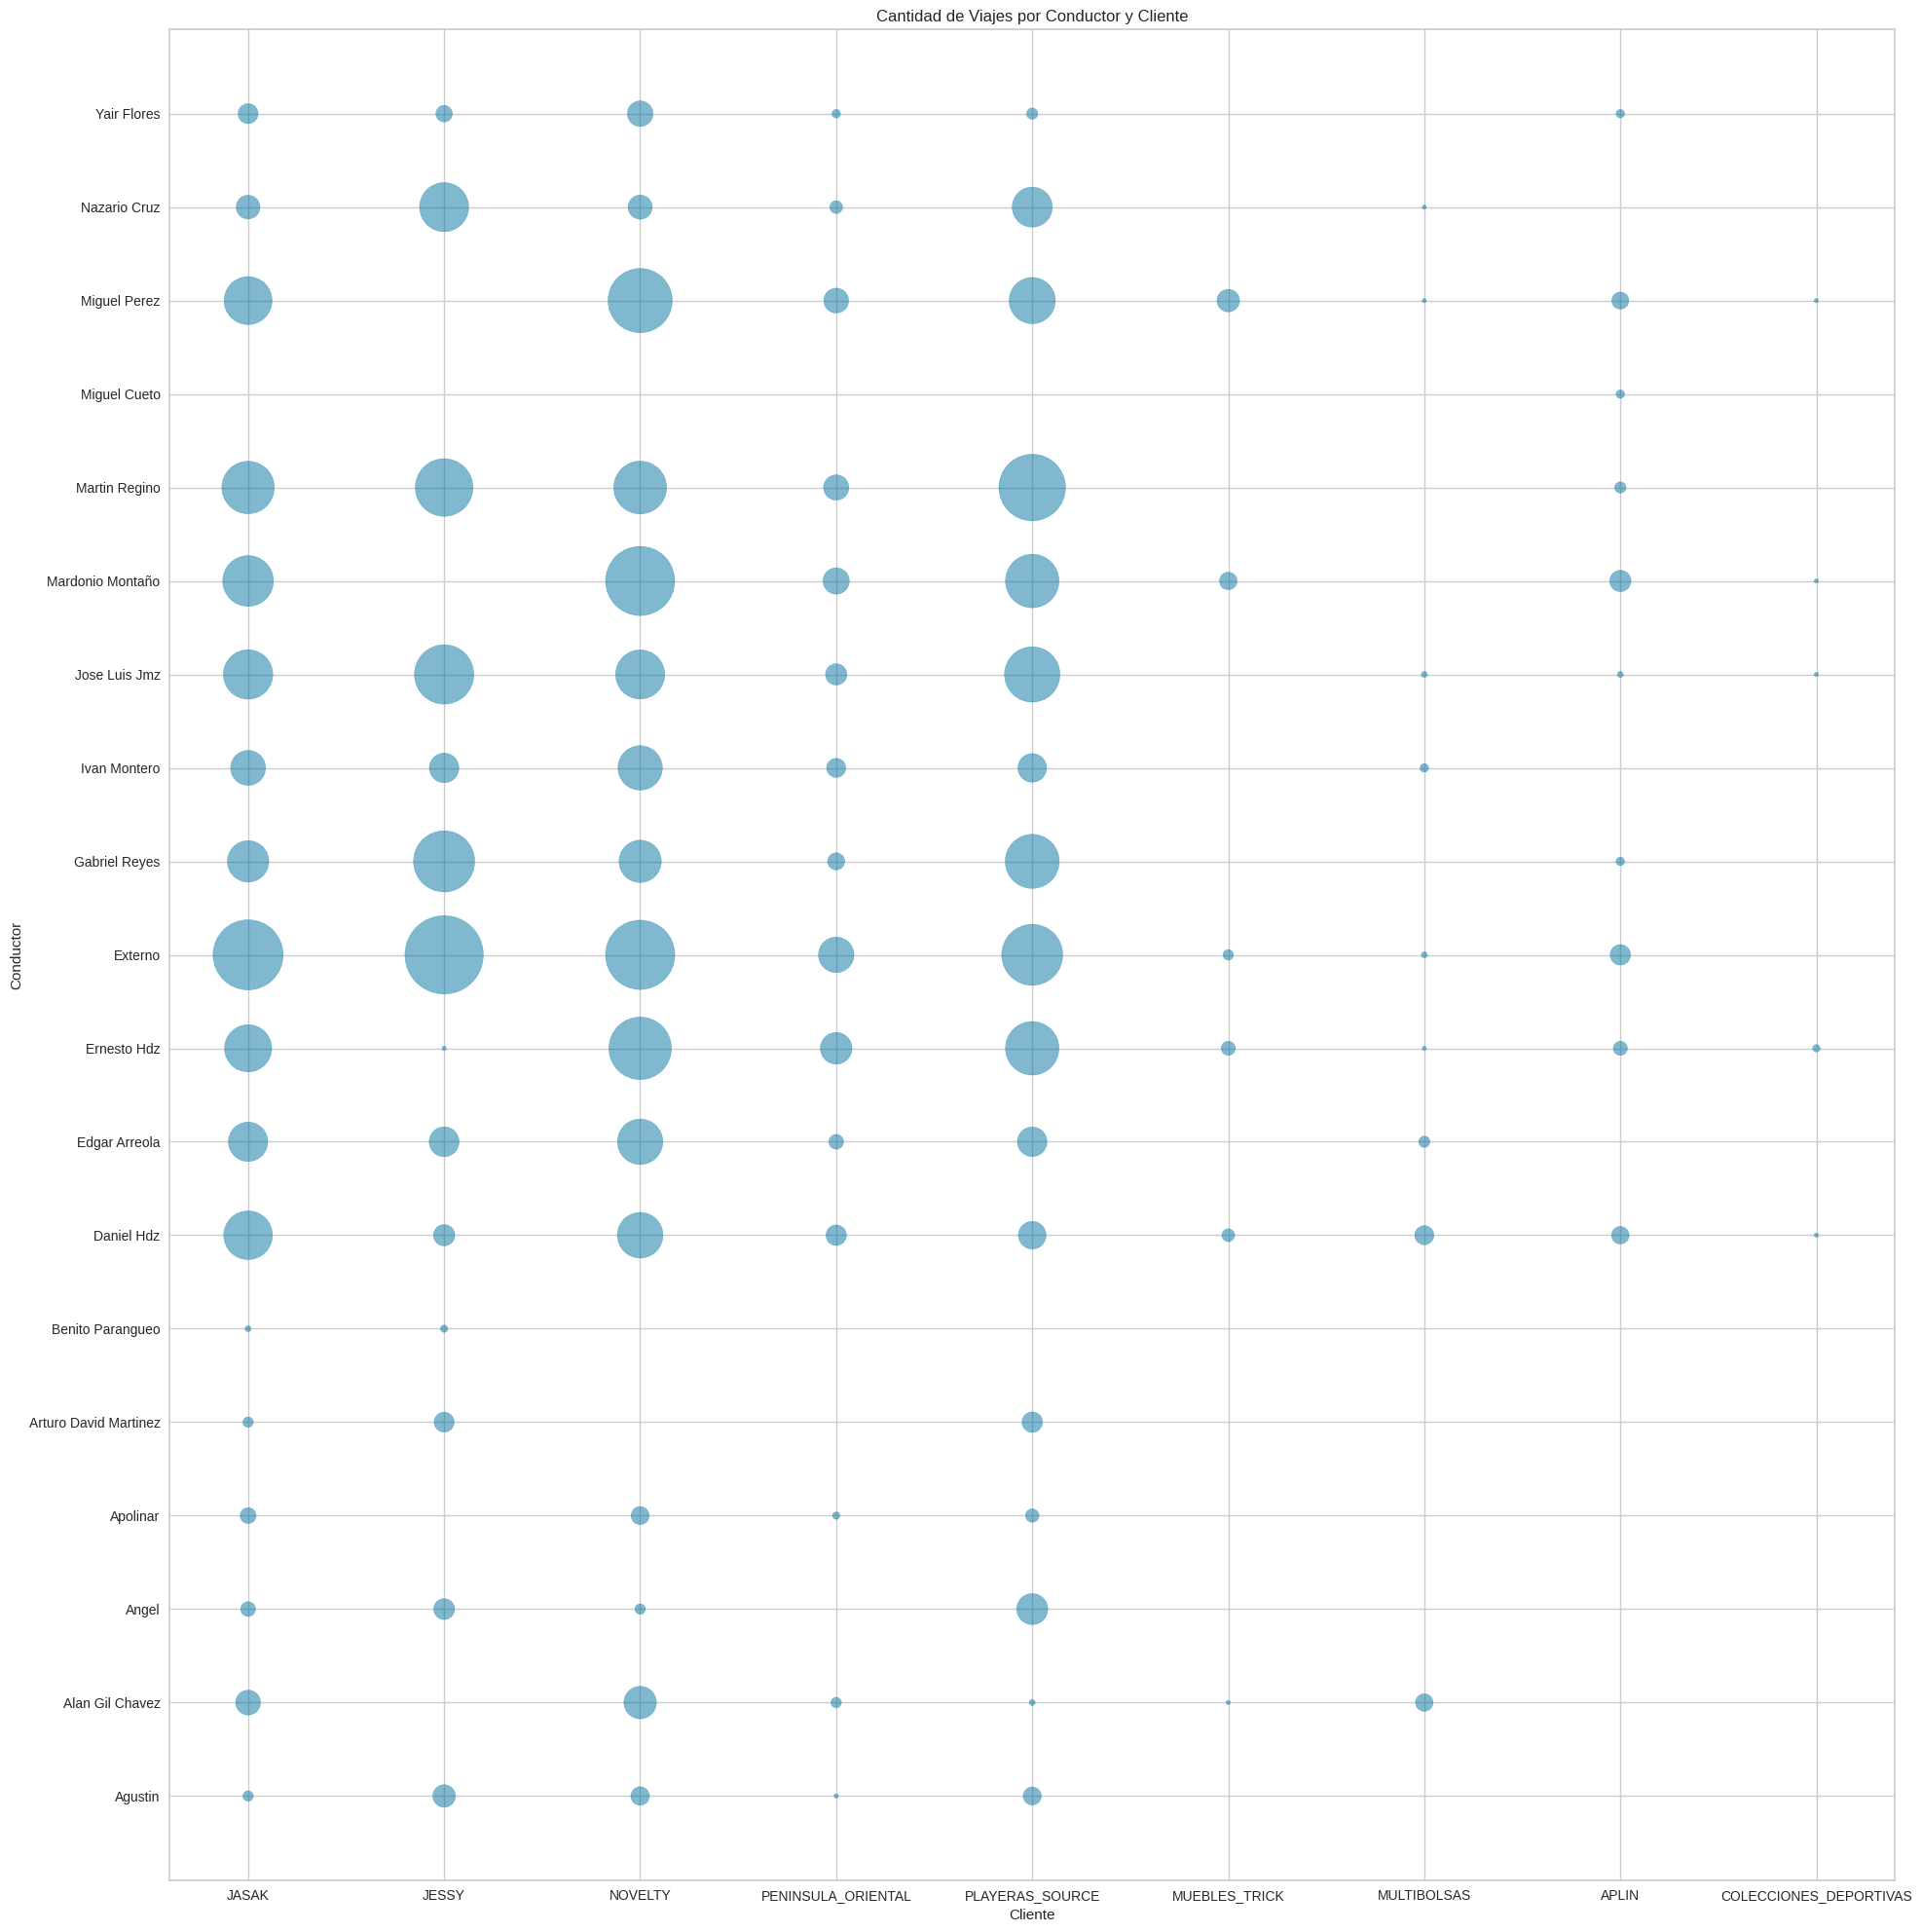

In [51]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_conductor_cliente = df.groupby(['OPERADOR', 'ID CLIENTE']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_cliente['ID CLIENTE'], conteo_conductor_cliente['OPERADOR'], s=conteo_conductor_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Cliente')
plt.tight_layout()
plt.show()

- Podemos ver que no existe una correlación fuerte entre clientes y conductores
- La correlación más fuerte es de los conductores externos y los clientes Jessy y Novelty
- Los clientes que tienen menor concentración podría ser porque son clientes relativamente nuevos

#### Vehículo Asignado vs. Cliente

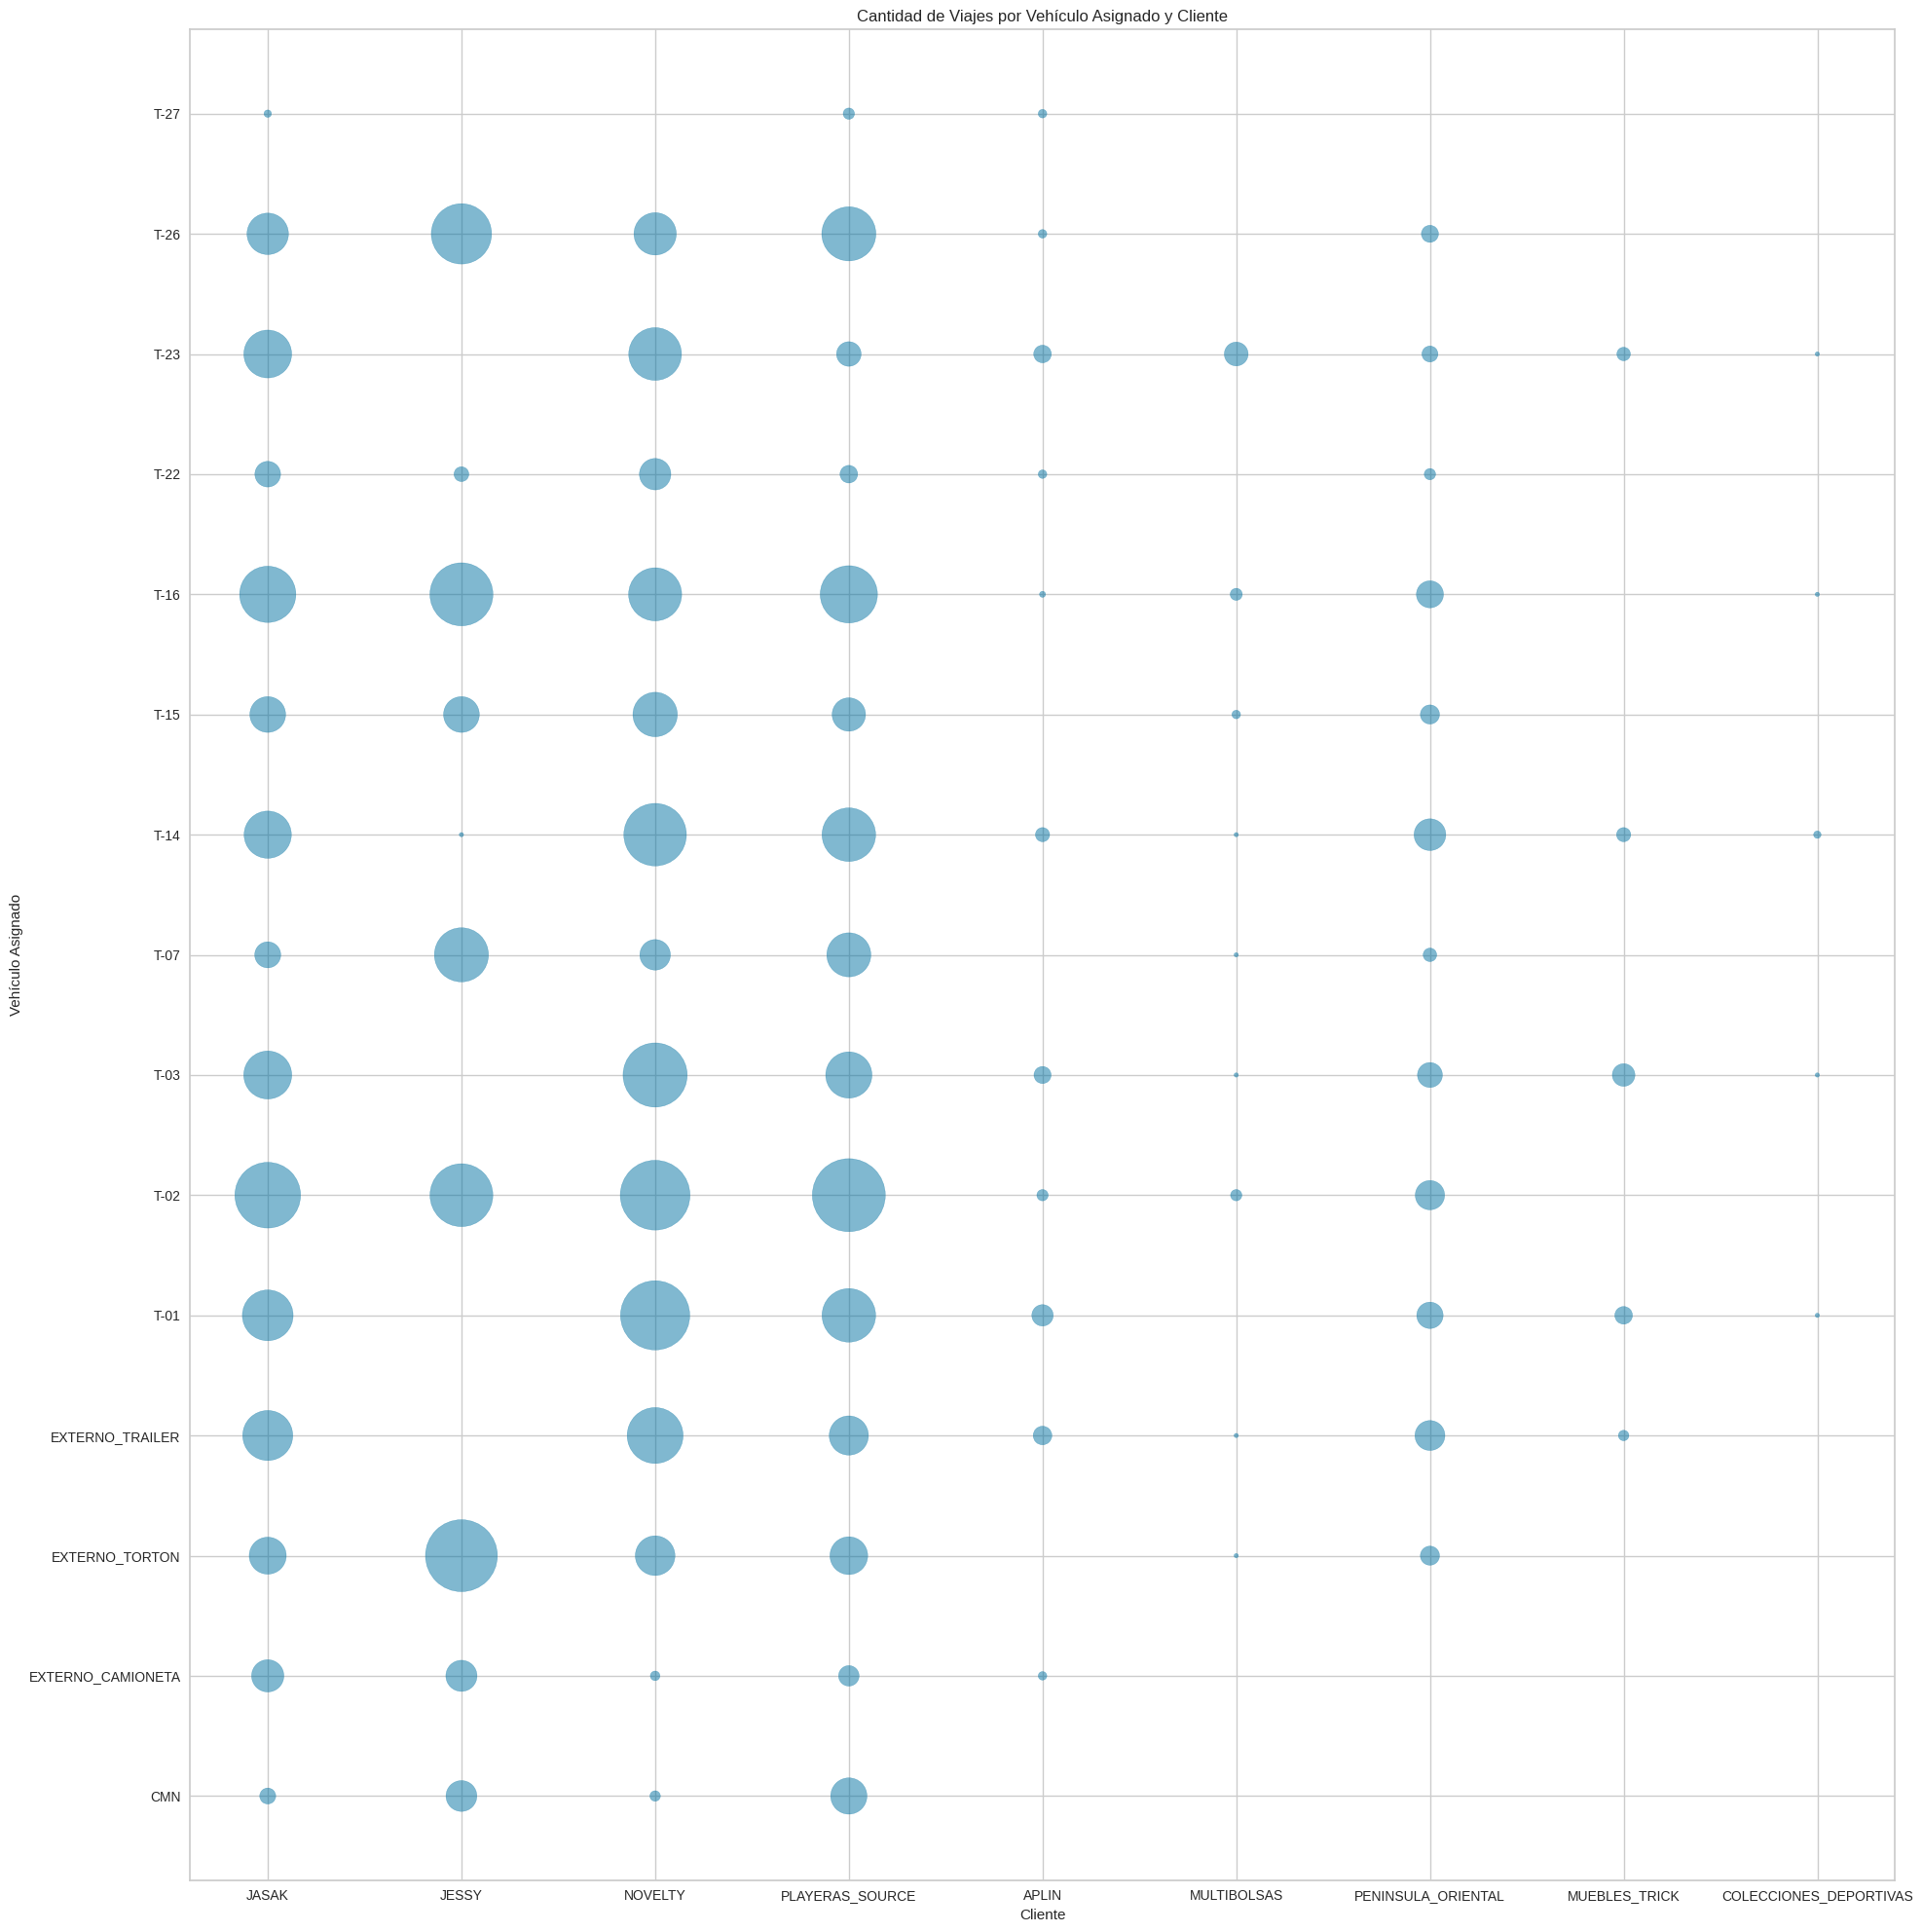

In [52]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_vehiculo_cliente = df.groupby(['ID UNIDAD ASIGNADA', 'ID CLIENTE']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_vehiculo_cliente['ID CLIENTE'], conteo_vehiculo_cliente['ID UNIDAD ASIGNADA'], s=conteo_vehiculo_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Vehículo Asignado')
plt.title('Cantidad de Viajes por Vehículo Asignado y Cliente')
plt.tight_layout()
plt.show()

- Existe una concentración de los clientes Jasak, Jessy, Novelty y Playeras Source con las unidades T-03, T-02, T-01 y Vehículos Externos

#### Rendimiento Promedio por Vehículo


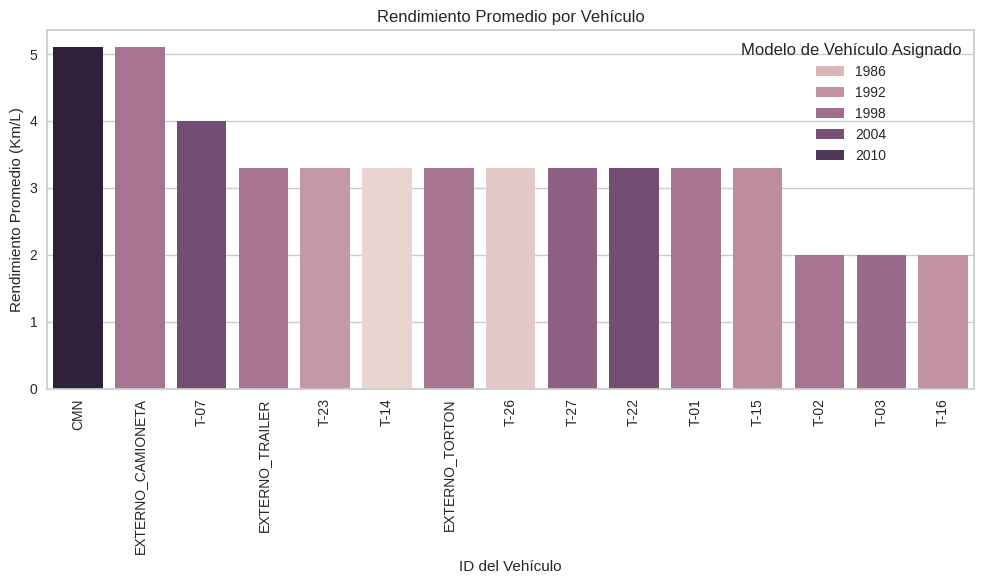

In [53]:
# Agrupar por vehículo y calcular el rendimiento promedio por vehículo
rendimiento_por_vehiculo = df.groupby('ID UNIDAD ASIGNADA')['RENDIMIENTO UNIDAD ASIGNADA'].mean()
rendimiento_por_vehiculo = rendimiento_por_vehiculo.sort_values(ascending=False)

# Fusionar los datos de rendimiento por vehículo con los datos de modelo de vehículo
df_rendimiento_modelo = pd.merge(rendimiento_por_vehiculo, df[['ID UNIDAD ASIGNADA', 'MODELO  UNIDAD ASIGNADA']], on='ID UNIDAD ASIGNADA', how='left')

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='ID UNIDAD ASIGNADA', y='RENDIMIENTO UNIDAD ASIGNADA', hue='MODELO  UNIDAD ASIGNADA', data=df_rendimiento_modelo)
plt.xlabel('ID del Vehículo')
plt.ylabel('Rendimiento Promedio (Km/L)')
plt.title('Rendimiento Promedio por Vehículo')
plt.xticks(rotation=90)
plt.legend(title='Modelo de Vehículo Asignado')
plt.tight_layout()
plt.show()


- La camioneta CMN es el vehículo con mayor rendimiento (5km/L), siendo el vehículo más nuevo
- El T-16 es el vehículo con menor rendimiento (2km/L), siendo uno de los vehículos más viejos de la flotilla.

#### Vehículo Asignado vs. Status de Orden

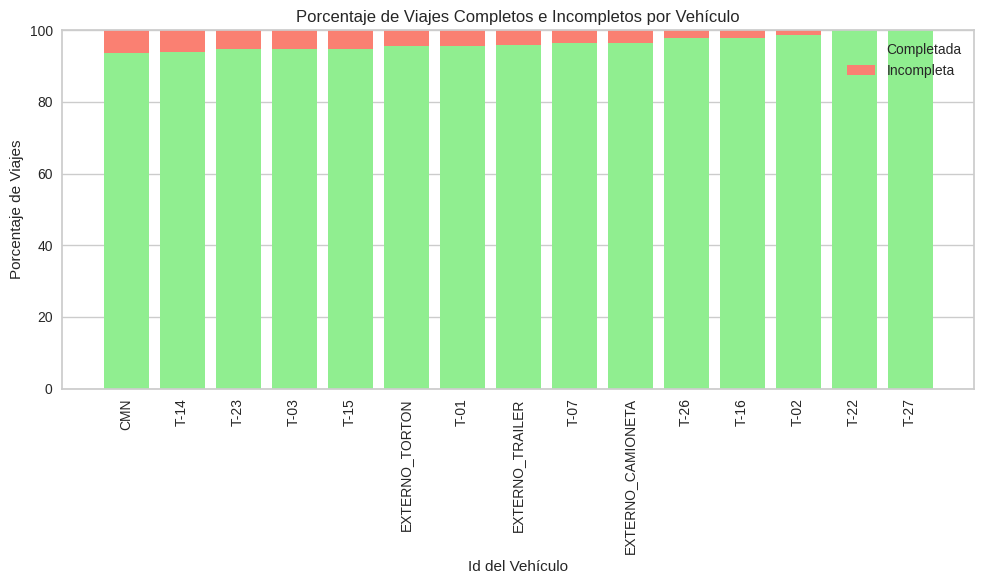

In [54]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_vehiculo = df.groupby('ID UNIDAD ASIGNADA')['STATUS DE LA ORDEN'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_vehiculo['Total'] = viajes_por_vehiculo.sum(axis=1)
viajes_por_vehiculo['Porcentaje_Completado'] = viajes_por_vehiculo['COMPLETADA'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo['Porcentaje_Incompleto'] = viajes_por_vehiculo['INCOMPLETA'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo = viajes_por_vehiculo.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_vehiculo['Porcentaje_Completado'], color='salmon')
plt.xlabel('Id del Vehículo')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Vehículo')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

- El T-14 es el vehículo con el menor porcentaje de viajes completados. El T-14 es uno de los modelos más viejos de los vehículos de la flotilla, siendo de 1986. Podría existir una correlación entre su antigüedad y su porcentaje bajo de viajes completos.
- El T-22 y el T-27 tienen un 100% de viajes completados

#### Tipo de Vehículo Solicitado vs Tipo de Vehículo Asignado

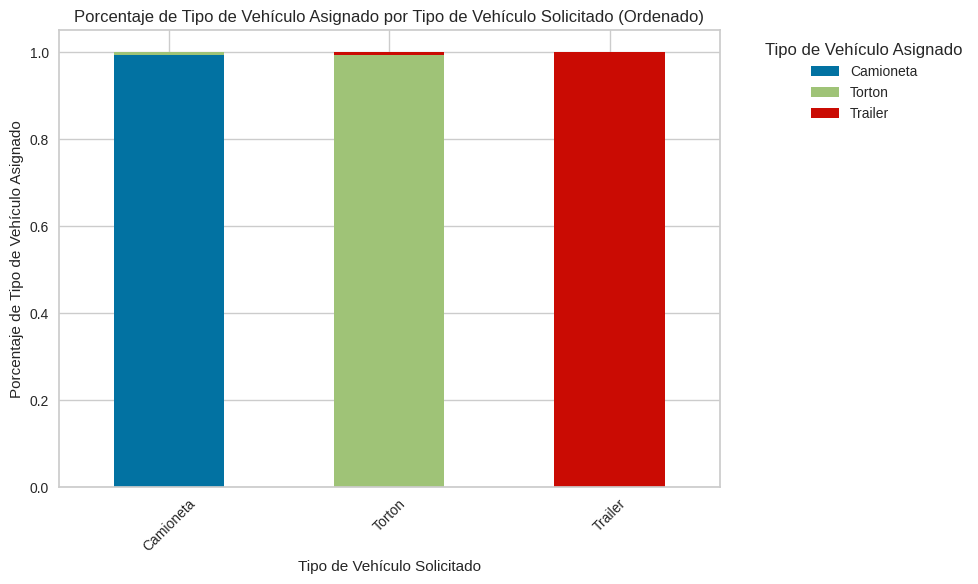

In [55]:
# Calcular el número de ocurrencias de cada combinación de tipo de vehículo solicitado y tipo de vehículo asignado
conteo_combinaciones = df.groupby(['TIPO DE UNIDAD', 'TIPO DE UNIDAD ASIGNADA']).size().unstack(fill_value=0)

# Calcular el porcentaje de cada tipo de vehículo asignado para cada tipo de vehículo solicitado
porcentaje_por_tipo_solicitado = conteo_combinaciones.apply(lambda row: row / row.sum(), axis=1)

# Ordenar las columnas de cada fila de mayor a menor porcentaje
porcentaje_por_tipo_solicitado = porcentaje_por_tipo_solicitado.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Graficar
porcentaje_por_tipo_solicitado.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Tipo de Vehículo Solicitado')
plt.ylabel('Porcentaje de Tipo de Vehículo Asignado')
plt.title('Porcentaje de Tipo de Vehículo Asignado por Tipo de Vehículo Solicitado (Ordenado)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Vehículo Asignado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Podemos ver que el vehiculo solicitado con menor disponibilidad es la camioneta.
- Seguimos viendo un porcentaje alto de solicitudes que se mandan a vehículos externos. Esto reafirma la necesidad del negocio por crecer su flotilla o administrar diferentes sus recursos.

### Peso de la Carga vs. Precio del Viaje

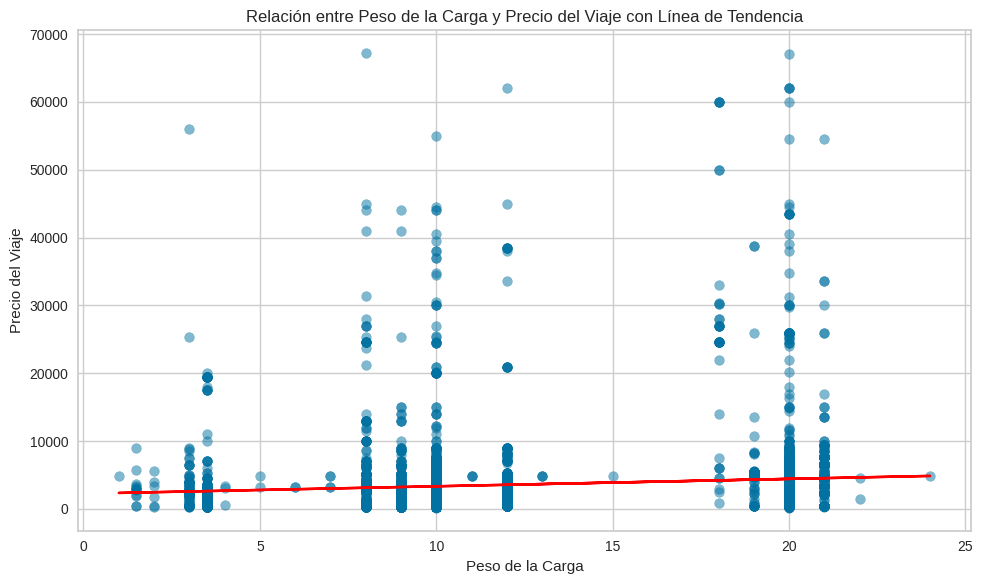

In [56]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['PESO'], df['PRECIO'], 1)

# Graficar el diagrama de dispersión con la línea de tendencia
plt.figure(figsize=(10, 6))
plt.scatter(df['PESO'], df['PRECIO'], alpha=0.5)
plt.plot(df['PESO'], m * df['PESO'] + b, color='red')
plt.xlabel('Peso de la Carga')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Peso de la Carga y Precio del Viaje con Línea de Tendencia')
plt.grid(True)
plt.tight_layout()
plt.show()

- Casi no existe correlación entre el peso de la carga y el precio dado a los clientes. Esto no hace mucho sentido debido a que debería haber una alza dependiendo el peso del trailer, ya que esto va a afectar directamente el rendimiento del vehículo.
#### Distancia del Viaje vs. Precio del Viaje

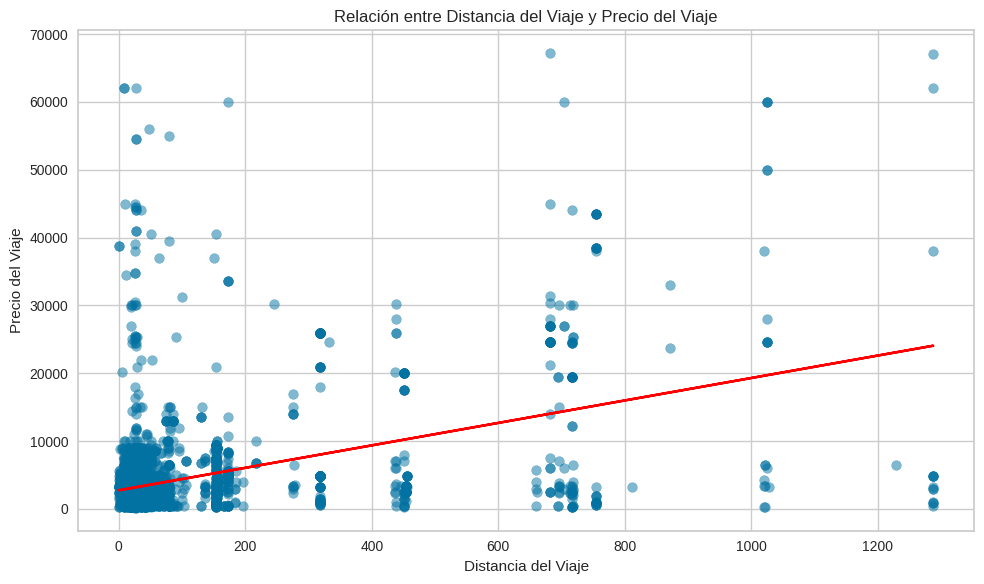

In [57]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['distancia_km'], df['PRECIO'], 1)

# Graficar el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['distancia_km'], df['PRECIO'], alpha=0.5)
plt.plot(df['distancia_km'], m * df['distancia_km'] + b, color='red')
plt.xlabel('Distancia del Viaje')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Distancia del Viaje y Precio del Viaje')
plt.grid(True)
plt.tight_layout()
plt.show()

- Vemos que aquí si existe una correlación positiva entre distancia y viaje, lo cual suena correcto por el consumo de combustible


Ya terminado el Exploratory Data Analysis podemos proceder a la preparación de los datos para el modelo.

__________
# Avance 2
## Preparación de Datos
Vamos a volver a visualizar los datos que tenemos disponibles para no omitir nada

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6700 entries, 0 to 7292
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID CLIENTE                   6700 non-null   object 
 1   PICKUP_LAT                   6700 non-null   float64
 2   PICKUP_LON                   6700 non-null   float64
 3   DELIVERY_LAT                 6700 non-null   float64
 4   DELIVERY_LON                 6700 non-null   float64
 5   DIA                          6700 non-null   int64  
 6   MES                          6700 non-null   int64  
 7   AÑO                          6700 non-null   int64  
 8   DIA DE LA SEMANA             6700 non-null   int64  
 9   OPERADOR                     6700 non-null   object 
 10  XP OPERADOR                  6700 non-null   int64  
 11  STATUS OPERADOR              6700 non-null   object 
 12  TIPO DE SERVICIO             6700 non-null   object 
 13  TIPO DE UNIDAD         

Como parte de mi preparación de datos, realizaré la división en 2 dataframes distintos, uno para predecir el vehículo (y su caja seca) y otro para predecir el conductor. Esto a pesar de ser poco intuitivo, tiene una razón de ser, la separación de datos para cada caso, preservar de manera independiente las características indispensables para cada variable; la combinación de ambas variables puede resultar en un modelo con poco entendimiento de las relaciones para cada variable.

Para la preparación de datos realizaremos distintos procesos como:
1. Construcción: Crearemos nuevas características, eliminaremos algunas otras y codificaremos las variables categóricas

2. Normalización de los datos: Escalaremos las variables para garantizar que todas tengan un impacto equitativo

3. Selección y Extracción: Se aplican métodos de filtrado y extracción alineados a los resultados.

### 1. Construcción
En esta primera parte, seleccionaremos las variables que nos son útiles para cada dataframe. Basado en información disponible para cada caso.

1. Vehículo: En el caso del vehículo reducimos de 24 features a 15.
  * Variables a Eliminar:
    - Cliente: Este no aporta ningún elemento estadístico al modelo, además de que evita que pueda escalarse el modelo en caso de añadir un nuevo cliente a la cartera.
    - Día y Año: Estos dos features son absorbidas por mes y día de la semana, ya que estas mantienen la escencia de las variables.
    - Conductor, Experiencia del Conductor, Status del Conductor: En este primer dataframe, primero buscaremos el vehículo requerido. Si dejáramos el conductor, caeríamos en una paradoja donde para escoger vehículo requerimos el conductor y para elegir conductor requerimos el vehículo.
    - Tipo de Vehículo Asignado, Capacidad_Max_Caja_Seca: Aún no sabemos que vehículo se elegirá, ergo, no sabemos el tipo del vehículo, ni el modelo, ni el rendimiento promedio.
  * Variables a Mantener:
    - Distancia y Latitud y Longitud de recolección y entrega: Es necesario saber los puntos de interés del viaje.
    - Mes y día de la semana: nos permite tomar en cuenta las temporadas con alta demanda.
    - Tipo de Servicio y Vehiculo Solicitado: Influye la decisión del cliente en la selección del vehículo.
    - Peso y Tipo de carga y packaging: Es importante conocer los requerimientos de la carga para elegir el vehículo.
    - Precio del viaje: puede darnos una idea del presupuesto del viaje
    - Status de la Orden: Lo utilizaremos más adelante para hacer un filtrado de los datos con los que entrenaremos el modelo.

2. Conductor:
  * Variables a Eliminar:
    - Cliente: Este no aporta ningún elemento estadístico al modelo, además de que evita que pueda escalarse el modelo en caso de añadir un nuevo cliente a la cartera.
    - Día y Año: Estos dos features son absorbidas por mes y día de la semana, ya que estas mantienen la escencia de las variables.
    - Experiencia del Conductor: Al no saber el conductor, es imposible saber su experiencia.
  * Variables a mantener:
    - Distancia y Latitud y Longitud de recolección y entrega: Es necesario saber los puntos de interés del viaje.
    - Mes y día de la semana: nos permite tomar en cuenta las temporadas con alta demanda.
    - Tipo de Servicio y Vehiculo Solicitado: Influye la decisión del cliente en la selección del vehículo.
    - ID Vehiculo asignado, Tipo de Vehiculo Asignado, Rendimiento Promedio, capacidad caja seca: Estos datos los obtendremos una vez que el modelo para el vehiculo estén entrenado.
    - Peso y Tipo de carga y packaging: Es importante conocer los requerimientos de la carga para elegir el vehículo.
    - Precio del viaje: puede darnos una idea del presupuesto del viaje
    - Status de Orden y Status Conductor: Estas variables las utilizaremos para filtrar los datos.
    

In [59]:
df_vehicle = df.copy()

# Mantenemos solo las variables deseadas en los nuevos dfs
df_vehicle = df_vehicle[['PICKUP_LAT',
'PICKUP_LON',
'DELIVERY_LAT',
'DELIVERY_LON',
'MES',
'DIA DE LA SEMANA',
'OPERADOR',
'XP OPERADOR',
'STATUS OPERADOR',
'TIPO DE SERVICIO',
'TIPO DE UNIDAD',
'ID UNIDAD ASIGNADA',
'TIPO DE ARTICULO',
'PESO',
'STATUS DE LA ORDEN',
'PACKAGING',
'PRECIO',
'distancia_km']]


df_driver = df.copy()
df_driver = df_driver[['PICKUP_LAT',
'PICKUP_LON',
'DELIVERY_LAT',
'DELIVERY_LON',
'MES',
'DIA DE LA SEMANA',
'OPERADOR',
'XP OPERADOR',
'STATUS OPERADOR',
'TIPO DE SERVICIO',
'TIPO DE UNIDAD',
'TIPO DE ARTICULO',
'PESO',
'STATUS DE LA ORDEN',
'PACKAGING',
'PRECIO',
'distancia_km']]



No deseamos que el modelo sea entrenado con información que no sea beneficiosa, por lo tanto necesitamos filtrar los dataframes:
1. Vehículo: Filtraremos los viajes incompletos con el fin de que no se entrene con esta información.

2. Conductor: De igual manera filtraremos los viajes incompletos y los conductores cuyo contrato ha sido terminado.

In [60]:
# Vehículo
df_vehicle = df_vehicle[df_vehicle['STATUS OPERADOR'] != 'Terminado']
df_vehicle = df_vehicle.drop(columns=['STATUS OPERADOR'])
df_vehicle.reset_index(drop=True, inplace=True)

df_vehicle = df_vehicle[df_vehicle['STATUS DE LA ORDEN'] != 'Incompleta']
df_vehicle = df_vehicle.drop(columns=['STATUS DE LA ORDEN'])
df_vehicle.reset_index(drop=True, inplace=True)

# Conductor
df_driver = df_driver[df_driver['STATUS OPERADOR'] != 'Terminado']
df_driver = df_driver.drop(columns=['STATUS OPERADOR'])
df_driver.reset_index(drop=True, inplace=True)

df_driver = df_driver[df_driver['STATUS DE LA ORDEN'] != 'Incompleta']
df_driver = df_driver.drop(columns=['STATUS DE LA ORDEN'])
df_driver.reset_index(drop=True, inplace=True)


Hecho esto, dividiremos los dataframes en X y Y.

In [61]:
x_driver = df_driver.drop('OPERADOR', axis=1)
y_driver = df_driver[['OPERADOR']]
x_vehicle = df_vehicle.drop('ID UNIDAD ASIGNADA', axis=1)
y_vehicle = df_vehicle[['ID UNIDAD ASIGNADA']]

Hecho esto, procederemos a obtener las nuevas columnas, ya que con esta información haremos el one hot encoding y más adelante el análisis PCA.

In [62]:
# Extraemos las columnas tipo objecto para las variables categoricas
cat_veh_cols = x_vehicle.select_dtypes(exclude='number').columns.tolist()
# Extraemos las columnas tipo numérico para las variables numéricos
num_veh_cols = x_vehicle.select_dtypes(include='number').columns.tolist()
print("Categorical Features for Vehicle DF:",cat_veh_cols)
print("Numerical Features for Vehicle DF:",num_veh_cols)

# Extraemos las columnas tipo objecto para las variables categoricas
cat_drv_cols = x_driver.select_dtypes(exclude='number').columns.tolist()
# Extraemos las columnas tipo numérico para las variables numéricos
num_drv_cols = x_driver.select_dtypes(include='number').columns.tolist()
print("Categorical Features for Driver DF:",cat_drv_cols)
print("Numerical Features for Driver DF:",num_drv_cols)

Categorical Features for Vehicle DF: ['OPERADOR', 'TIPO DE SERVICIO', 'TIPO DE UNIDAD', 'TIPO DE ARTICULO', 'PACKAGING']
Numerical Features for Vehicle DF: ['PICKUP_LAT', 'PICKUP_LON', 'DELIVERY_LAT', 'DELIVERY_LON', 'MES', 'DIA DE LA SEMANA', 'XP OPERADOR', 'PESO', 'PRECIO', 'distancia_km']
Categorical Features for Driver DF: ['TIPO DE SERVICIO', 'TIPO DE UNIDAD', 'TIPO DE ARTICULO', 'PACKAGING']
Numerical Features for Driver DF: ['PICKUP_LAT', 'PICKUP_LON', 'DELIVERY_LAT', 'DELIVERY_LON', 'MES', 'DIA DE LA SEMANA', 'XP OPERADOR', 'PESO', 'PRECIO', 'distancia_km']


Parte de la preparación de los datos es importante convertir las variables categóricas en variables numéricas para que la información sea entendible para el modelo de machine learning. Para realizar esto, se usa la codificación. Existen diferentes técnicas, pero en este caso utilizaremos la de One-Hot Encoding. Este tipo de codificación convierte los valores de las variables categoricas en nuevos features, donde los valores serán de 1 o 0 dependiendo si corresponde este nuevo feature a su valor o no (Kristianto, 2023).

In [63]:
x_vehicle = pd.get_dummies(x_vehicle, columns=cat_veh_cols)
x_driver = pd.get_dummies(x_driver, columns=cat_drv_cols)

Podemos ver el resultado de la codificación de variables en ambos dfs.

In [64]:
x_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5178 entries, 0 to 5177
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PICKUP_LAT                               5178 non-null   float64
 1   PICKUP_LON                               5178 non-null   float64
 2   DELIVERY_LAT                             5178 non-null   float64
 3   DELIVERY_LON                             5178 non-null   float64
 4   MES                                      5178 non-null   int64  
 5   DIA DE LA SEMANA                         5178 non-null   int64  
 6   XP OPERADOR                              5178 non-null   int64  
 7   PESO                                     5178 non-null   float64
 8   PRECIO                                   5178 non-null   int64  
 9   distancia_km                             5178 non-null   float64
 10  OPERADOR_Arturo David Martinez           5178 no

Para evitar multicolinearidad y para simplificar el modelo, removemos una de las dos columnas donde las variables originales solo contenia 2 valores. Estas son las variables a eliminar:
- Packaging a Granel: Se queda solo Packagin Entarimado

In [65]:
x_vehicle.drop(['PACKAGING_GRANEL'], axis=1, inplace=True)

In [66]:
x_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5178 entries, 0 to 5177
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PICKUP_LAT                               5178 non-null   float64
 1   PICKUP_LON                               5178 non-null   float64
 2   DELIVERY_LAT                             5178 non-null   float64
 3   DELIVERY_LON                             5178 non-null   float64
 4   MES                                      5178 non-null   int64  
 5   DIA DE LA SEMANA                         5178 non-null   int64  
 6   XP OPERADOR                              5178 non-null   int64  
 7   PESO                                     5178 non-null   float64
 8   PRECIO                                   5178 non-null   int64  
 9   distancia_km                             5178 non-null   float64
 10  TIPO DE SERVICIO_Devolucion              5178 no

In [67]:
x_driver.drop(['PACKAGING_GRANEL'], axis=1, inplace=True)

### 2. Normalización
La finalidad de escalar los datos numéricos es para evitar que exista un bias al momento de entrenar el modelo y que este piense que alguna de las variables tenga mayor peso basado en su escala (Khoong, 2023). El escalado de datos nos permite escalar los datos para que estos tengan una media de 0 y una desviación standard con valor de 1. (How to scale pandas DataFrame columns ? 2021)



In [68]:
scaler_driver = StandardScaler()
x_driver[num_drv_cols] = scaler_driver.fit_transform(x_driver[num_drv_cols])
scaler_vehicle = StandardScaler()
x_vehicle[num_veh_cols] = scaler_vehicle.fit_transform(x_vehicle[num_veh_cols])

Podemos ver que los datos numéricos ahora están escalados y tienen una desviación estandar de 1. Hecho esto podemos proceder al análisis de componentes principales (PCA).

In [69]:
x_driver.describe().T

count   mean   std     min    25%    50%    75%    max
PICKUP_LAT       5178.000  0.000 1.000  -1.130 -0.315 -0.285 -0.173 19.823
PICKUP_LON       5178.000  0.000 1.000 -15.001  0.044  0.057  0.225 26.843
DELIVERY_LAT     5178.000 -0.000 1.000  -2.214 -0.386 -0.112 -0.083 10.895
DELIVERY_LON     5178.000  0.000 1.000  -8.612  0.054  0.088  0.133 13.079
MES              5178.000  0.000 1.000  -1.920 -0.703  0.210  0.819  1.427
DIA DE LA SEMANA 5178.000  0.000 1.000  -1.975 -0.724 -0.098  1.153  1.779
XP OPERADOR      5178.000 -0.000 1.000  -2.321 -0.757  0.024  0.806  1.587
PESO             5178.000  0.000 1.000  -2.483 -0.854 -0.491  0.957  1.682
PRECIO           5178.000  0.000 1.000  -0.702 -0.387 -0.122  0.114 12.069
distancia_km     5178.000 -0.000 1.000  -0.460 -0.290 -0.264 -0.203  9.353

In [70]:
x_vehicle.describe().T

count   mean   std     min    25%    50%    75%    max
PICKUP_LAT       5178.000  0.000 1.000  -1.130 -0.315 -0.285 -0.173 19.823
PICKUP_LON       5178.000  0.000 1.000 -15.001  0.044  0.057  0.225 26.843
DELIVERY_LAT     5178.000 -0.000 1.000  -2.214 -0.386 -0.112 -0.083 10.895
DELIVERY_LON     5178.000  0.000 1.000  -8.612  0.054  0.088  0.133 13.079
MES              5178.000  0.000 1.000  -1.920 -0.703  0.210  0.819  1.427
DIA DE LA SEMANA 5178.000  0.000 1.000  -1.975 -0.724 -0.098  1.153  1.779
XP OPERADOR      5178.000 -0.000 1.000  -2.321 -0.757  0.024  0.806  1.587
PESO             5178.000  0.000 1.000  -2.483 -0.854 -0.491  0.957  1.682
PRECIO           5178.000  0.000 1.000  -0.702 -0.387 -0.122  0.114 12.069
distancia_km     5178.000 -0.000 1.000  -0.460 -0.290 -0.264 -0.203  9.353

### 3. Selección / Extracción

Para esta sección probaremos los efectos del PCA en el dataframe con el fin de saber si el modelo se beneficiaría de aplicarlo o no.

El modelo tiene un número mediano de features numéricos, lo que a primera instancia nos dice que probablemente no vaya a hacer gran efecto el PCA, pero de cualquier manera este número de features añade complejidad al modelo. Para contrarrestar esto, utilizaremos el análisis principal de componentes o PCA por sus siglas en inglés. El objetivo principal del PCA es reducir la dimensionalidad, mantieniendo sus patrones y tendencias (Ambika, 2023). Esto se hace transformando un conjunto de variables correlacionadas en nuevo conjunto de variables no correlacionadas, llamadas componentes principales, que mantienen en mayor parte la variabilidad posible de los datos originales. Para lograr esto, se hace mediante la identificación de una serie de ejes ortogonales. Este proceso está encapsulado en la función de PCA.

Como nota, este proceso lo realizamos después del escalado para que todas las características mantengan la misma escala. Además de que sólo se puede aplicar a variables numéricas.

In [71]:
# Aquí seleccionamos en la función de PCA mantener un 95% de la varianza de los
# datos originales
pca_vehicle = PCA(n_components=0.95)

# El PCA solo se puede aplicar a variables numéricas debido a que este metodo
# esta basado en algebra lineal. Por lo que para calcular su PCA, utilizaremos
# solo las variables numéricas y posteriormente se concatenara con las variables
# categoricas
df_pca_veh = pca_vehicle.fit_transform(x_vehicle[num_veh_cols])
# Obtenemos los componentes principales
pca_componentes = pca_vehicle.components_
nombre_componentes = []
# Interpretar los componentes principales y sus coeficientes
for i, component in enumerate(pca_componentes):
    print(f"Componente Principal {i + 1}:")
    nombre_componentes.append(f"Componente Principal {i + 1}")
    for j, (feature, coef) in enumerate(zip(x_vehicle.columns, component)):
        print(f"    {feature}: {coef}")

Componente Principal 1:
    PICKUP_LAT: 0.19859665378605723
    PICKUP_LON: -0.14335035313185765
    DELIVERY_LAT: 0.5767591185915748
    DELIVERY_LON: -0.22151997135591375
    MES: -0.018519836555918694
    DIA DE LA SEMANA: -0.020888190227509106
    XP OPERADOR: 0.18534786104761897
    PESO: 0.14177651768367952
    PRECIO: 0.3953170849471505
    distancia_km: 0.5888790688454699
Componente Principal 2:
    PICKUP_LAT: 0.5956634696526635
    PICKUP_LON: -0.5672333724040788
    DELIVERY_LAT: -0.29533172088945103
    DELIVERY_LON: 0.1912984936054263
    MES: -0.010819624209443171
    DIA DE LA SEMANA: 0.051191681445055724
    XP OPERADOR: 0.29251042307709113
    PESO: 0.3106101512671018
    PRECIO: -0.08844631143943205
    distancia_km: -0.08374948913193599
Componente Principal 3:
    PICKUP_LAT: 0.28514627850019564
    PICKUP_LON: -0.3680716203786581
    DELIVERY_LAT: 0.06013421822934034
    DELIVERY_LON: -0.01356056744830769
    MES: -0.20271608733163796
    DIA DE LA SEMANA: 0.0452651

In [72]:
# Convertimos df_pca en un dataframe y agregamos columnas
df_pca_veh = pd.DataFrame(df_pca_veh)
df_pca_veh.columns = nombre_componentes
# Veamos la diferencia antes y después del PCA
print("Total de columnas de variables numericas antes del PCA:   ",len(num_veh_cols))
print("Total de columnas de variables numericas después del PCA: ",len(df_pca_veh.columns))

Total de columnas de variables numericas antes del PCA:    10
Total de columnas de variables numericas después del PCA:  9


Podemos ver que la reducción no es significativa para el dataframe del vehiculo, por lo que podemos decir que no nos es de utilidad. Ahora haremos el mismo análisis para el df del conductor.

In [73]:
# Aquí seleccionamos en la función de PCA mantener un 95% de la varianza de los
# datos originales
pca_driver = PCA(n_components=0.95)

# El PCA solo se puede aplicar a variables numéricas debido a que este metodo
# esta basado en algebra lineal. Por lo que para calcular su PCA, utilizaremos
# solo las variables numéricas y posteriormente se concatenara con las variables
# categoricas
df_pca_drv = pca_driver.fit_transform(x_driver[num_drv_cols])
# Obtenemos los componentes principales
pca_componentes = pca_driver.components_
nombre_componentes = []
# Interpretar los componentes principales y sus coeficientes
for i, component in enumerate(pca_componentes):
    print(f"Componente Principal {i + 1}:")
    nombre_componentes.append(f"Componente Principal {i + 1}")
    for j, (feature, coef) in enumerate(zip(x_driver.columns, component)):
        print(f"    {feature}: {coef}")

Componente Principal 1:
    PICKUP_LAT: 0.19859665378605723
    PICKUP_LON: -0.14335035313185765
    DELIVERY_LAT: 0.5767591185915748
    DELIVERY_LON: -0.22151997135591375
    MES: -0.018519836555918694
    DIA DE LA SEMANA: -0.020888190227509106
    XP OPERADOR: 0.18534786104761897
    PESO: 0.14177651768367952
    PRECIO: 0.3953170849471505
    distancia_km: 0.5888790688454699
Componente Principal 2:
    PICKUP_LAT: 0.5956634696526635
    PICKUP_LON: -0.5672333724040788
    DELIVERY_LAT: -0.29533172088945103
    DELIVERY_LON: 0.1912984936054263
    MES: -0.010819624209443171
    DIA DE LA SEMANA: 0.051191681445055724
    XP OPERADOR: 0.29251042307709113
    PESO: 0.3106101512671018
    PRECIO: -0.08844631143943205
    distancia_km: -0.08374948913193599
Componente Principal 3:
    PICKUP_LAT: 0.28514627850019564
    PICKUP_LON: -0.3680716203786581
    DELIVERY_LAT: 0.06013421822934034
    DELIVERY_LON: -0.01356056744830769
    MES: -0.20271608733163796
    DIA DE LA SEMANA: 0.0452651

In [74]:
# Convertimos df_pca en un dataframe y agregamos columnas
df_pca_drv = pd.DataFrame(df_pca_drv)
df_pca_drv.columns = nombre_componentes
# Veamos la diferencia antes y después del PCA
print("Total de columnas de variables numericas antes del PCA:   ",len(num_drv_cols))
print("Total de columnas de variables numericas después del PCA: ",len(df_pca_drv.columns))

Total de columnas de variables numericas antes del PCA:    10
Total de columnas de variables numericas después del PCA:  9


De la misma manera, la reducción no es significativa. Por lo tanto no se utilizará esto en el preprocesamiento.

Podemos proceder a la división del df en train y test.

Ya con estos cambios realizados podemos proceder a dividir los datos en entrenamiento y pruebas. La razón por lo que lo dividimos es para que podamos evaluar el rendimiento del modelo de manera imparcial. Con esto me refiero a que el modelo va a ser ajustado con el conjunto de entrenamiento y se va a evaluar de manera imparcial su rendimiento con datos nunca antes vistos para ver cómo se comportaría en el mundo real. Si no se hiciera esto, no podríamos ver que tan bueno o malo es el modelo para generalizar sus resultados con datos del mundo real.

Se realizó la división de cada data frame, poniendo el 20% de los datos para prueba.

In [75]:
x_driver_train, x_driver_test, y_driver_train, y_driver_test = train_test_split(x_driver, y_driver, test_size=0.15, random_state=42,stratify=y_driver)

In [76]:
x_vehicle_train, x_vehicle_test, y_vehicle_train, y_vehicle_test = train_test_split(x_vehicle, y_vehicle, test_size=0.15, random_state=42, stratify=y_vehicle)

Finalmente, procedemos al balanceo de datos. La razón de hacer esto es porque, como pudimos notar en el EDA, existía un desbalance de datos la variable de salida. En otras palabras, estaban subrepresentadas algunas clases en comparación con las clases mayoritarias. Si lo dejamos así, puede que haya un mayor peso en el aprendizaje del valor de una variable, que de otra, dándonos bajo rendimiento para las clases minoritarias (Chawla et al., 2002).

En este caso realizaremos una técnica de sobre muestreo llamada Random Oversampler para balancear datasets desequilibrados. Su funcionamiento consiste en crear nuevas instancias sintéticas de las clases subrepresentadas de forma aleatoria mediante tecnicas de interpolación. (López et al., 2013).

Para demostrar su funcionamiento, primero mostraremos la distribución de los previamente:

#### Conductor

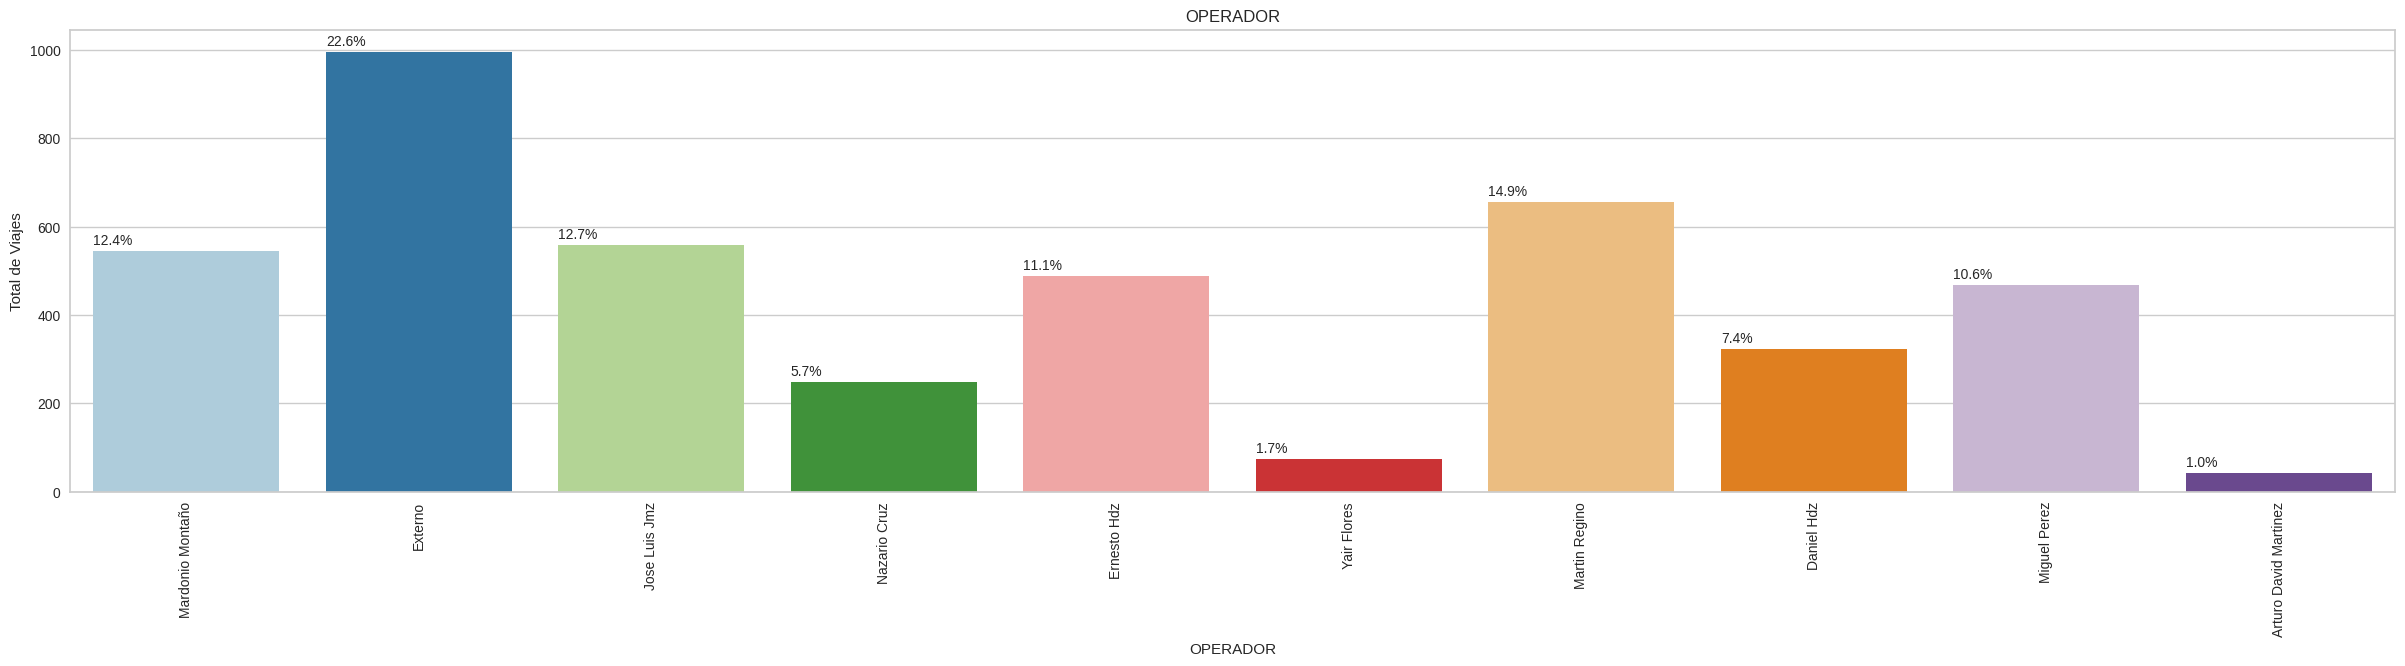

In [77]:
# Visualizamos la distribución de las variables antes del balance
perc_on_bar(pd.DataFrame(y_driver_train, columns=['OPERADOR']), 'OPERADOR', size =(30,6))

In [78]:
ros_driver = RandomOverSampler(random_state=42)
x_train_drv_res, y_train_drv_res = ros_driver.fit_resample(x_driver_train, y_driver_train)

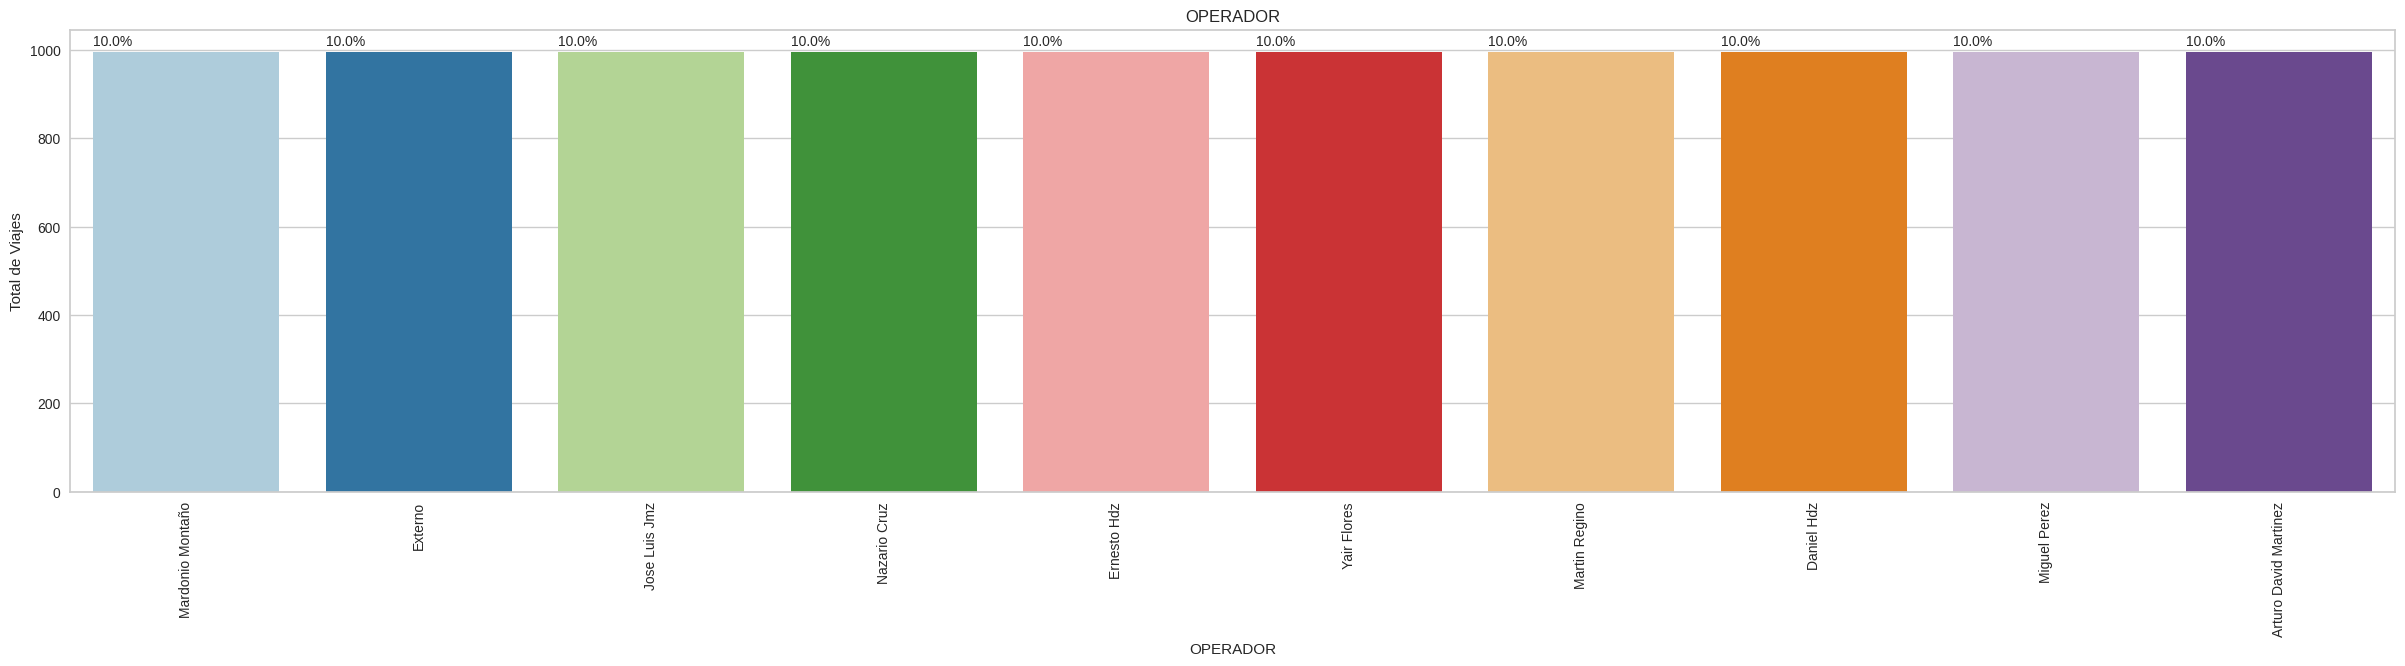

In [79]:
# Visualizamos la distribución de las variables después del balance
perc_on_bar(pd.DataFrame(y_train_drv_res, columns=['OPERADOR']), 'OPERADOR',size =(30,6))

#### Vehículo

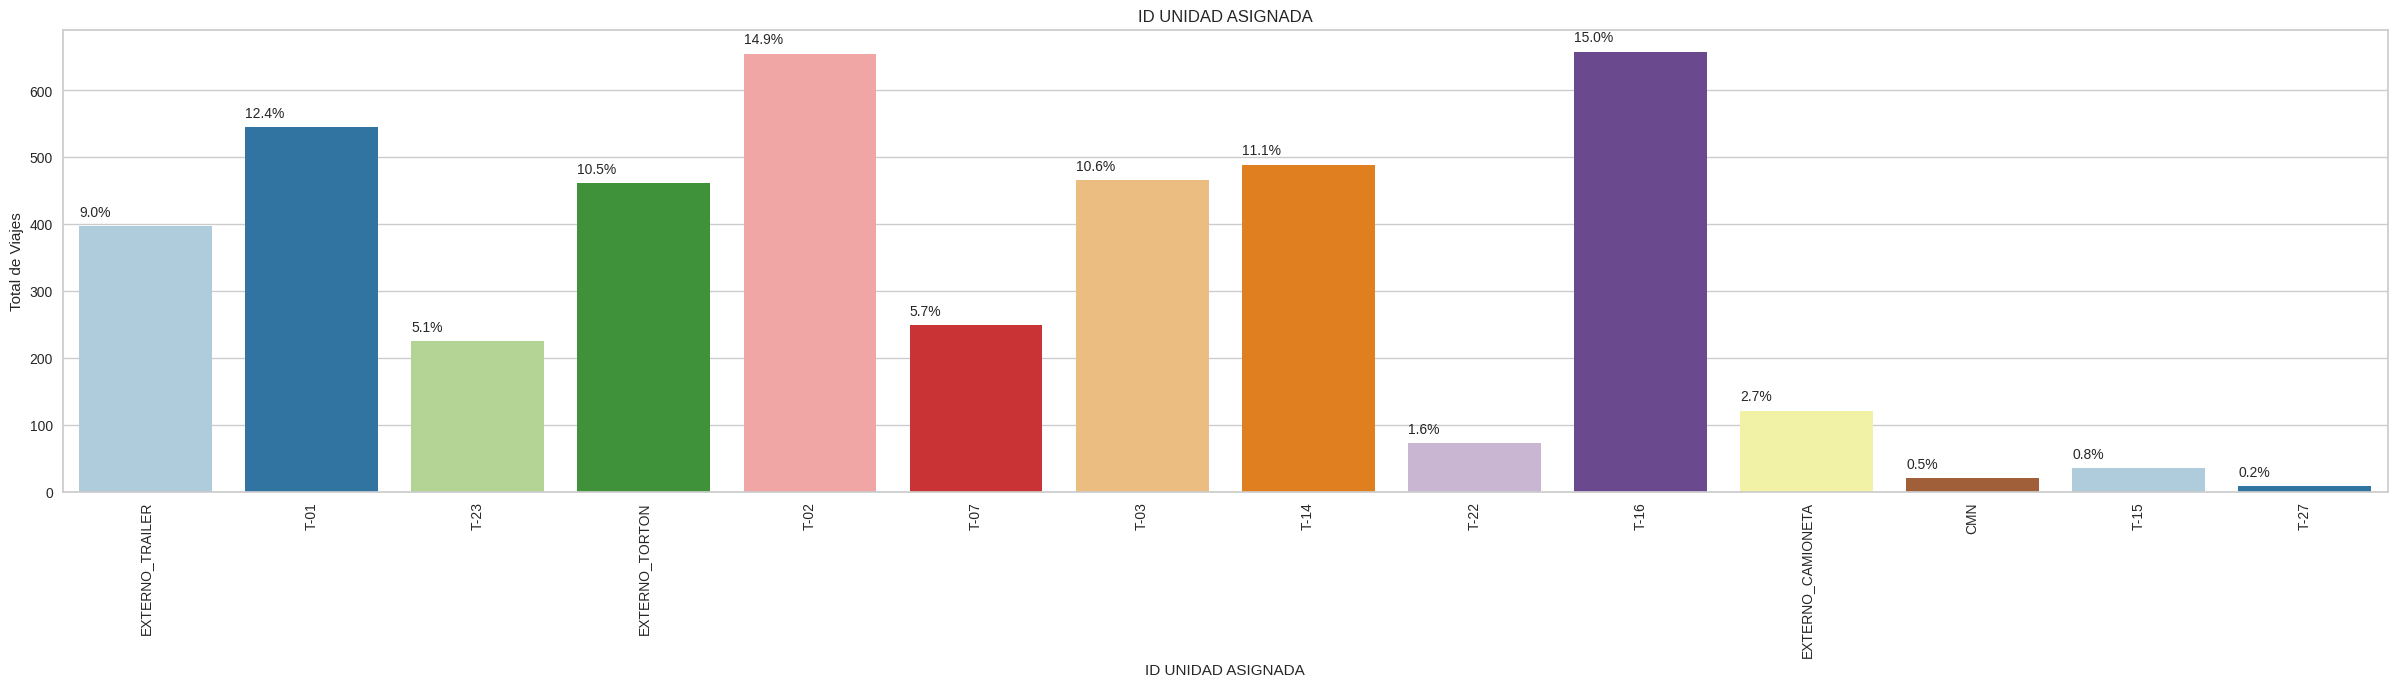

In [80]:
# Visualizamos la distribución de las variables antes del balance
perc_on_bar(pd.DataFrame(y_vehicle_train, columns=['ID UNIDAD ASIGNADA']), 'ID UNIDAD ASIGNADA', size =(30,6))

In [81]:
ros_vehicle = RandomOverSampler(random_state=42)
x_train_veh_res, y_train_veh_res = ros_vehicle.fit_resample(x_vehicle_train, y_vehicle_train)

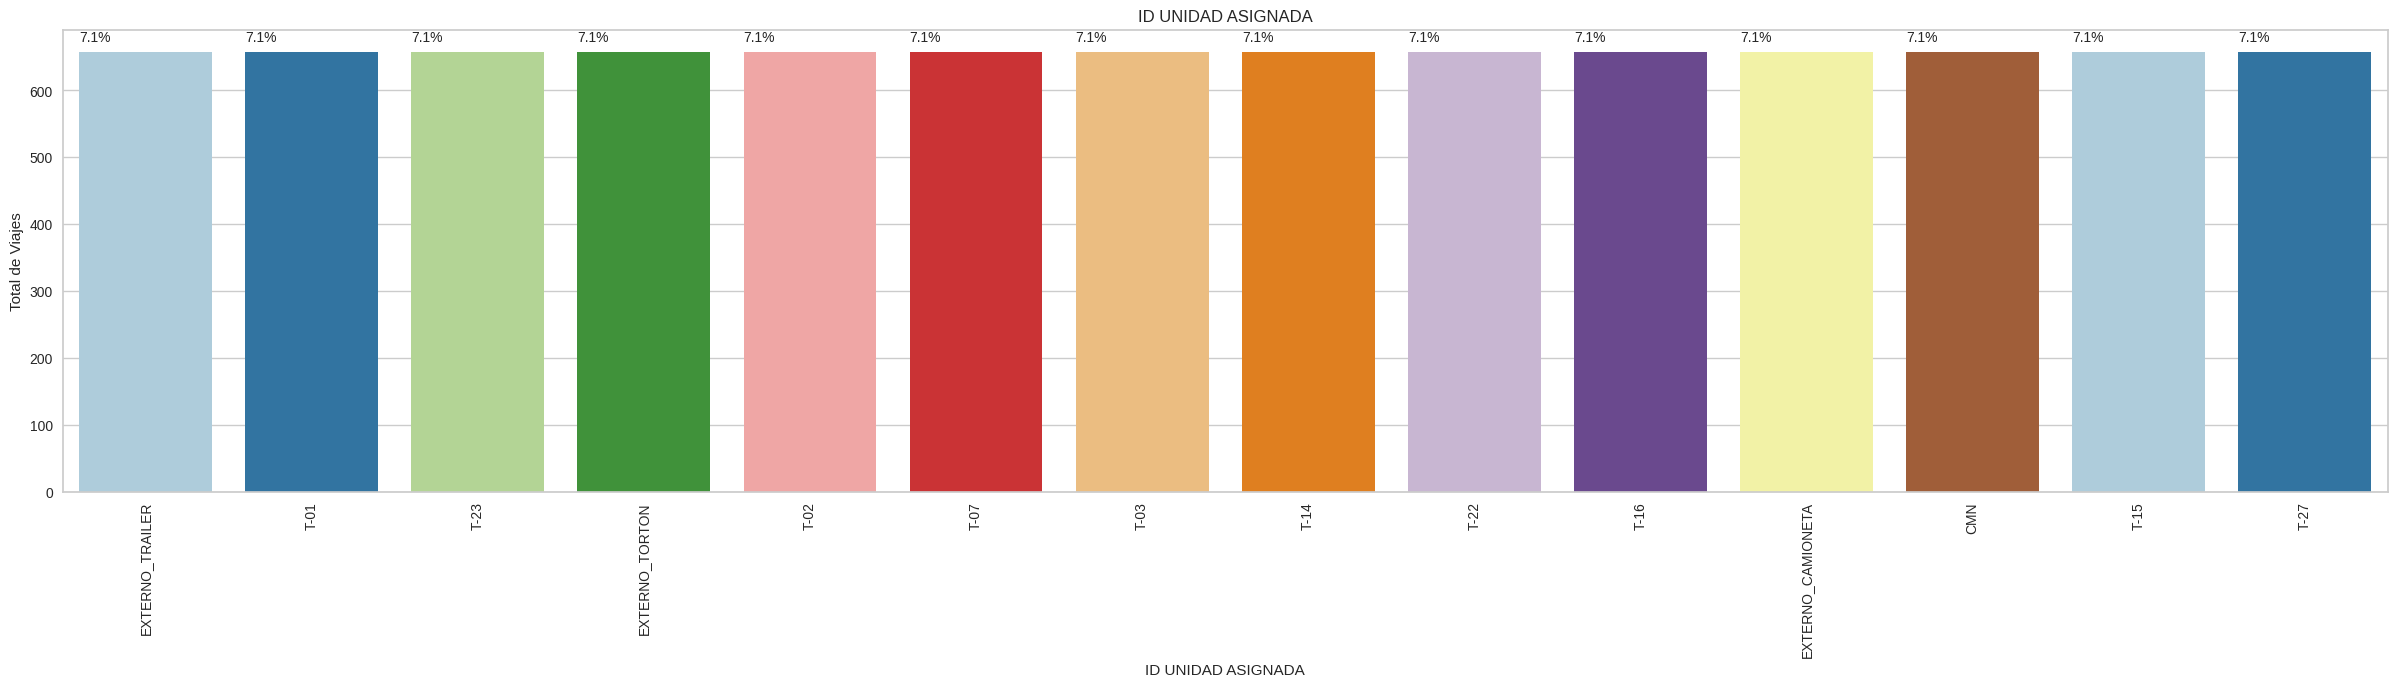

In [82]:
# Visualizamos la distribución de las variables después del balance
perc_on_bar(pd.DataFrame(y_train_veh_res, columns=['ID UNIDAD ASIGNADA']), 'ID UNIDAD ASIGNADA',size =(30,6))

Concluyendo esta etapa, podemos decir que completamos el preprocesamiento de datos necesario para prepararlos adecuadamente antes de entrenar el modelo, siguiendo la metodología CRISP-ML. En resumen se realizaron los siguientes pasos:

1. **Transformación One-Hot Encoding**: Se aplico la técnica de codificación one-hot a las variables categóricas, conviritendolas a variables binarias para facilitar su procesamiento por parte del modelo.

2. **Escalado de Características**: Se utilizó tandard Scaler para normalizar las variables numéricas asegurando que mantengan una media de 0 y una desviación estandar de 1. Esto es crucial para evitar que los features numércios dominen el modelo durante el entrenamiento.

3. **Balanceo de Datos:** Se implementó Random Over Sampler para abordar el desequilibrio de clases en la variable de salida, con el objetivo de mejorar la capacidad predictiva del modelo y garantizar que aprenda de manera equilibrada de cada valor de la variable objetivo.

El PCA se intentó usar para reducir la dimensionalidad del dataframe para así mejorar el rendimiento del modelo y prevenir el sobreajuste. Sin embargo, tras aplicarlo no se vió gran diferencia con respecto al data frame original, por lo que se decidió no incluir.

Estos pasos son fundamentales para asegurar la compatibilidad de los datos con los algoritmos de machine learning, mejorar el rendimiento del modelo y mitigar el riesgo de sobreajuste, contribuyendo así al éxito del proyecto de modelado.

_____
# Avance 3
## Baseline

Empezaremos con la generación de nuestro modelo base. La idea es generar un modelo híbrido, donde se unan los resultados de 2 modelos, uno para el conductor y otro para el vehículo. Esto a pesar de ser poco intuitivo, tiene una razón de ser, la separación le permite a cada modelo aprender de manera independiente las características para cada vehículo y para cada conductor; la combinación de ambas variables, obscurece las relaciones de los datos, ocultando así posibles findings que sólo aparecerían de manera independiente.

Para cada una de las variables, se planea probar de manera inicial los 2 tipos de sistemas de recomendación; de filtrado colaborativo y basado en contenido. La prueba de ambos modelos nos servirá para comparar cual de los dos tipos de modelos nos puede ayudar obtener una recomendación más robusta.

En los siguientes bloques explicaremos por qué podríamos utilizar cada uno de los sistemas de recomendación, junto con su contexto.

En fin, antes de empezar con la implementación de los modelos, quisiera entrar en detalle con respecto a las métricas disponibles para evaluar los modelos y explicar la métrica más relevante para nuestro caso.

De acuerdo a literatura, algunas de las métricas más usadas para evaluar modelos multiclase, son los siguientes:

- Precision: Esta métrica mide la proporcion de predicciones correctas. Este tipo de métrica es útil cuando los errores de clasificación tienen las mismas consecuencias.
- Recall: Esta métrica mide la proporción de casos positivos correctamente identificads. Este tipo de métrica es útil cuando los falsos negativos tienen un costo mayor que los falsos positivos.
- F1-Score: Es una métrica que proporciona un balance entre precision y recall.

Dicho esto, con base en las necesidades del problema, la métrica que más nos va a servir es F1-Score. Esto debido a que la precision es importante para asegurarnos que el vehiculo y conductor sea el adecuado. Si escogemos mal alguno de los dos, puede significar incompatibilidad, lo cual aumenta el riesgo del viaje, reduce la posibilidad de que el viaje sea exitoso e incluso puede aumentar los costos. Gracias a que el F1-Score nos da una vision más global del rendimiento del modelo, lo hace el más adecuado.

Para poder medir el rendimiento del modelo desde todos los ángulos, generaremos una función que nos permita imprimir y guardar las métricas para que más adelante las podamos comparar.



In [83]:
# Esta función evaluara el modelo
def get_metrics_score(model, train, test, train_y, test_y, flag=True):
    '''
    model : classifier to predict values of X
    train : training feature data
    test : testing feature data
    train_y : training labels
    test_y : testing labels
    flag : boolean to control print statements (default is True)
    '''
    # Defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(train)
    pred_test = model.predict(test)

    train_acc = metrics.accuracy_score(train_y, pred_train)
    test_acc = metrics.accuracy_score(test_y, pred_test)

    train_recall = metrics.recall_score(train_y, pred_train, average='weighted')
    test_recall = metrics.recall_score(test_y, pred_test, average='weighted')

    train_precision = metrics.precision_score(train_y, pred_train, average='weighted')
    test_precision = metrics.precision_score(test_y, pred_test, average='weighted')

    train_f1 = metrics.f1_score(train_y, pred_train, average='weighted')
    test_f1 = metrics.f1_score(test_y, pred_test, average='weighted')

    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_precision, test_precision, train_f1, test_f1))

    # If the flag is set to True, then only the following print statements will be displayed.
    if flag:
        print("Accuracy on training set:", train_acc)
        print("Accuracy on test set:", test_acc)
        print("Recall on training set:", train_recall)
        print("Recall on test set:", test_recall)
        print("Precision on training set:", train_precision)
        print("Precision on test set:", test_precision)
        print("F1-Score on training set:", train_f1)
        print("F1-Score on test set:", test_f1)

    return score_list

Finalmente, otra función que necesitamos añadir al repertorio, es para realizar el análisis de features. Este análisis, al igual que la matriz de correlación, nos permite ver la correlación que tienen los features con la variable objetivo. De igual manera, nos permite ver que variables son irrelevantes para el modelo. Esto nos puede ayudar a refinar aún más el modelo para obtener mejores resultados.

In [84]:
def feature_importance(model, model_name, x, y, scorer, n_repeats = 10, n_jobs =-1, random_state=78):
  # Generamos la permutación de importancia con nuestro modelo y datos
  importance_ = permutation_importance(model, x, y, scoring=scorer, n_repeats=n_repeats, n_jobs=n_jobs, random_state=random_state)
  # Guardamos estos datos en un dataframe para mostrarlo
  df_importance = pd.DataFrame({"importances_mean":importance_["importances_mean"], "importances_std":importance_["importances_std"]}, index=x.columns)
  df_importance = df_importance.sort_values("importances_mean", ascending=False)
  # Mostramos el dataframe
  display(df_importance.sort_values("importances_mean", ascending=False))
  # Mostramos la importancia de manera gráfica
  plt.figure(figsize=(20, 6))
  df_importance['importances_mean'].plot(kind='bar')
  plt.xlabel('Feature')
  plt.ylabel('Importance')
  plt.title(f'Feature Importance - {model_name}')
  plt.grid(True)
  plt.show()

Generadas estas funciones podemos empezar con la generación de los modelos.
### Filtrado Colaborativo

Si hablamos de collaborative filtering (CF) o filtrado colaborativo, es un tipo de modelo que nos permite generar recomendaciones con base en las preferencias de muchos otros usuarios con gustos similares (Figueroa, 2020).

En nuestro caso más particular, CF nos permite recomendar al usuario una combinación de conductor/vehículo con base en las preferencias que se han tenido en viajes similares.

Existen distintos tipos de filtrado:
- Usuario-Usuario: Verifica la similitud entre dos usuarios basándose en el número de artículos que ambos tienen en común en su base de datos. Este tipo de filtrado es bueno en caso de que el número de usuarios sea menor al número de artículos. (Figueroa, 2020)

- Artículo-Artículo: Este se basa en la similitud que hay entre los artículos, eso quiere decir que las recomendaciones se basarán en "si te gusta este artículo, probablemente te agrade este otro artículo". Este tipo de filtrado es bueno en caso de que el número de artículos sea menor al número de usuarios. (Figueroa, 2020)

- Usuario-Artículo: En este caso es una combinación de Usuario-Usuario y Artículo-Artículo. El truco está en que se genera lo que se llama una matriz de descomposición donde existen vectores de baja dimensión para los usuarios y para los artículos. Esto nos permite revelar si a cada usuario le gusta o no un artículo. Vale la pena mencionar que este método tiene un alto costo computacional y es poco escalable en caso de necesitar añadir un nuevo artículo o un nuevo usuario. (Figueroa, 2020)

La implementación del CF implica varios pasos:
1. Preprocesamiento de datos: Esto es parte de lo que hicimos en la sección anterior, que conlleva eliminar valores ausentes, normalizar los datos y codificar las características categóricas.

2. Selección de Neighbors: Esto se basa en diferentes técnicas para calcular la distancia entre diferentes vecinos y así poder encontrar que vecinos se asemejan más para poder generar la recomendación. Las técnicas más usadas son: distancia euclidiana o similitud de coseno.

3. Cálculo de similitud: Este cálculo nos dice qué tanto se parece nuestro usuario objetivo con cada vecino.

4. Generación de recomendaciones: Se generan recomendaciones para el usuario objetivo, con base en las preferencias de usuarios vecinos y el nivel de similitud con cada vecino.

5. Evaluación: Una vez ya entrenado el modelo de CF, se debe evaluar su performance con métricas como precision, accuracy, recall y F1-Score.

A continuación empezaremos con la implementación:



In [85]:
training_times_drv = []
training_times_veh = []

### Conductor

In [86]:
start = time.time()
# Definimos el parámetro grid para KNN
param_grid_knn = {
    'n_neighbors': range(1, 31),  # número de vecinos
    'weights': ['uniform', 'distance'],  # tipo de peso
    'metric': ['euclidean', 'manhattan', 'minkowski']  # métrica de distancia
}
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# Inicializamos el modelo base
knn_drv = KNeighborsClassifier()

# Realizamos la búsqueda aleatoria con validación cruzada
rndm_cv_knn_drv = RandomizedSearchCV(estimator=knn_drv, param_distributions=param_grid_knn, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_knn_drv.fit(x_train_drv_res, y_train_drv_res)

# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el KNN del conductor son {} con un score de cross validation de {}:".format(rndm_cv_knn_drv.best_params_, rndm_cv_knn_drv.best_score_))

# Reinicializamos el modelo, pero esta vez con los valores óptimos
knn_driver = KNeighborsClassifier(
    n_neighbors=rndm_cv_knn_drv.best_params_['n_neighbors'],
    weights=rndm_cv_knn_drv.best_params_['weights'],
    metric=rndm_cv_knn_drv.best_params_['metric']
)

# Hacemos el fitting del modelo
knn_driver.fit(x_train_drv_res, y_train_drv_res)
stop = time.time()
training_times_drv.append(["KNN Classifier", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_knn_drv = get_metrics_score(
    model=knn_driver,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el KNN del conductor son {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'} con un score de cross validation de 0.9284658397243518:
Training time: 11.682122945785522s
Accuracy on training set: 0.9939759036144579
Accuracy on test set: 0.7631917631917632
Recall on training set: 0.9939759036144579
Recall on test set: 0.7631917631917632
Precision on training set: 0.9939807350066528
Precision on test set: 0.7750610581995435
F1-Score on training set: 0.9939554182867434
F1-Score on test set: 0.7659488643284412


Evaluación general:
- Alto rendimiento en los datos de entrenamiento: el modelo muestra un muy buen rendimiento en el conjunto de entrenamiento con un score de aproximadamente de 0.994, lo que indica un ajuste muy preciso en los datos de entrenamiento.

- Overfitting: En el conjunto de prueba, las métricas bajan significativamente, teniendo un score de 0.76, lo que sugiere que el modelo podría estar sobre ajustado.

- Generalización: El desempeño fue relativamente alto en el conjunto de entrenamiento, pero valdría la pena ajustar aún más para mejorar el desempeño en el conjunto de entrenamiento. La generalización es medianamente buena pero podría mejorar.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar aún más los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Análisis de características: analizar las características utilizadas en el modelo para comprender su impacto en el rendimiento del clasificador. Esto puede ayudar en la ingeniería y selección de funciones para mejorar aún más el modelo.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como regresión logística, árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
XP OPERADOR                                         0.560            0.003
MES                                                 0.143            0.003
DIA DE LA SEMANA                                    0.128            0.002
PRECIO                                              0.049            0.001
PESO                                                0.042            0.002
PICKUP_LAT                                          0.020            0.001
DELIVERY_LAT                                        0.019            0.001
TIPO DE UNIDAD_Torton                               0.018            0.001
TIPO DE UNIDAD_Trailer                              0.017            0.001
TIPO DE ARTICULO_ELECTRONICOS                       0.015            0.001
DELIVERY_LON                                        0.014            0.001
TIPO DE ARTICULO_JUEGOS DE MESA                     0.013            0.001
distancia_km                                        0.013            0.001
PACKAGING_ENTARIMADO                                0.013            0.001
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.012            0.001
TIPO DE SERVICIO_Transporte                         0.010            0.001
TIPO DE SERVICIO_Maniobra                           0.010            0.001
PICKUP_LON                                          0.009            0.001
TIPO DE ARTICULO_DISFRACES                          0.006            0.001
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.003            0.000
TIPO DE ARTICULO_PAQUETERIA                         0.002            0.000
TIPO DE UNIDAD_Camioneta                            0.001            0.000
TIPO DE SERVICIO_Devolucion                         0.001            0.000
TIPO DE ARTICULO_MUEBLES ARMABLES                   0.001            0.000
TIPO DE SERVICIO_Estadia                            0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                   0.000            0.000

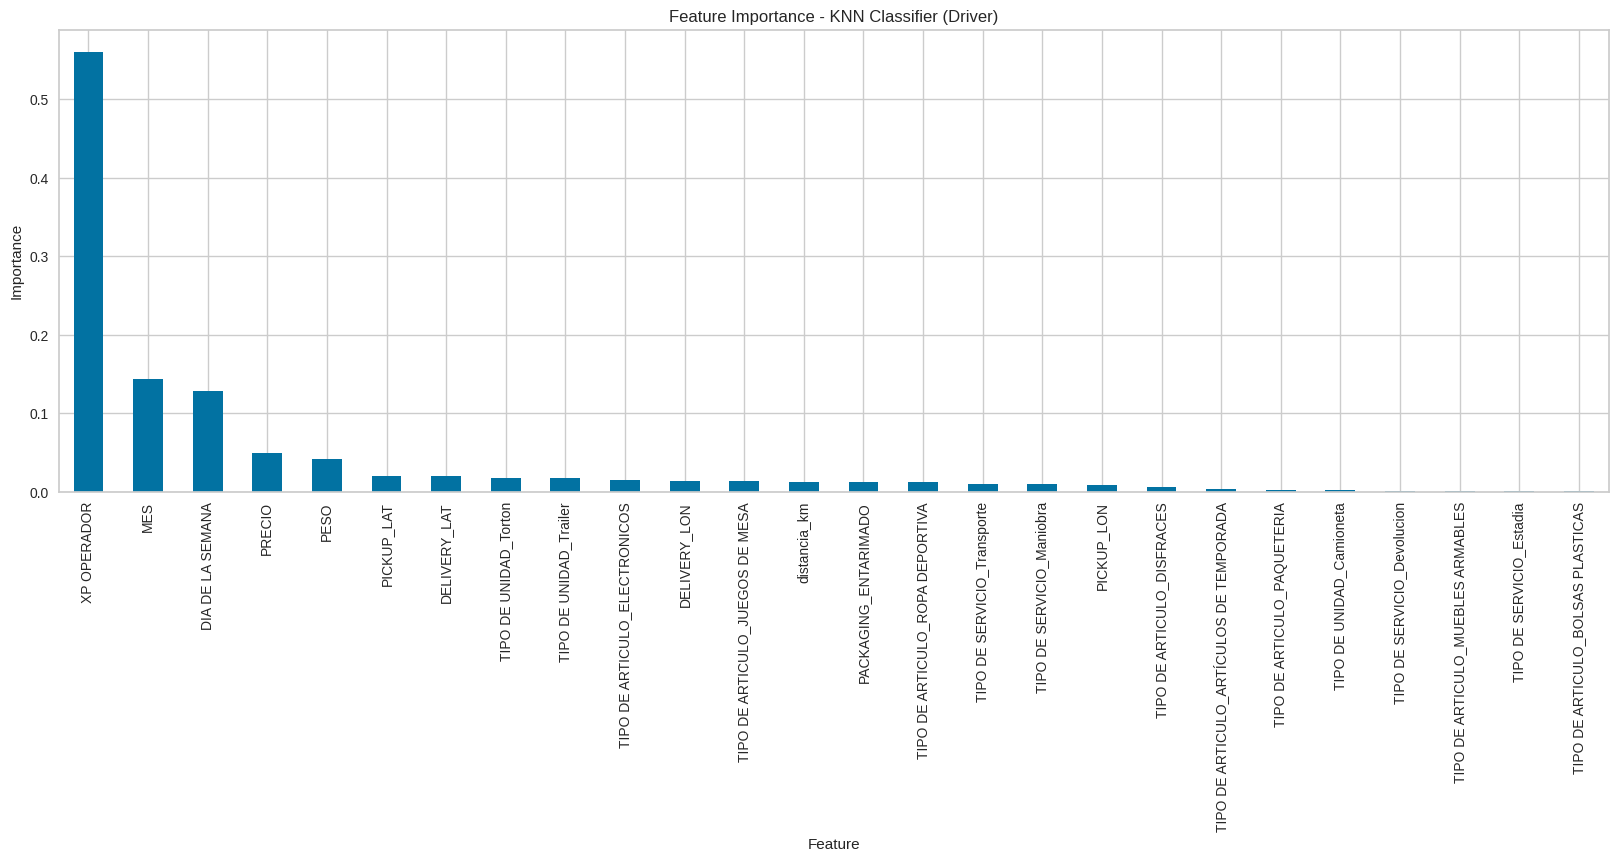

In [87]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = knn_driver,
                   model_name = "KNN Classifier (Driver)",
                   x = x_train_drv_res,
                   y = y_train_drv_res,
                   scorer = F1_scorer)

En este caso, la experiencia del operador es lo más pesado al momento de seleccionarlo, esto nos indica que este es un factor determinante.

En segundo y tercer lugar está el mes y día de la semana. Esto parece ser correcto ya que parece que hay un patrón marcado con qué choferes son asignados por día y la carga de trabajo que se tiene por mes.

En cuarto lugar tenemos el precio. Esto parece indicar que existe un patrón en el precio del viaje con respecto a chofer que se asigna. Podría suceder por una falta de estandarización de precios.

Finalmente en quinto lugar está el peso de la carga, lo que indica que el conductor va a variar con respecto a que tan pesada sea la carga, confirmando lo visto en el análisis multivariable.

### Vehículo

In [88]:
start = time.time()
# Definimos el parámetro grid para KNN
param_grid_knn = {
    'n_neighbors': range(1, 31),  # número de vecinos
    'weights': ['uniform', 'distance'],  # tipo de peso
    'metric': ['euclidean', 'manhattan', 'minkowski']  # métrica de distancia
}

# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# Inicializamos el modelo base
knn_veh = KNeighborsClassifier()

# Realizamos la búsqueda aleatoria con validación cruzada
rndm_cv_knn_veh = RandomizedSearchCV(estimator=knn_veh, param_distributions=param_grid_knn, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_knn_veh.fit(x_train_veh_res, y_train_veh_res)

# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el KNN del vehiculo son {} con un score de cross validation de {}:".format(rndm_cv_knn_veh.best_params_, rndm_cv_knn_veh.best_score_))

# Reinicializamos el modelo, pero esta vez con los valores óptimos
knn_vehicle = KNeighborsClassifier(
    n_neighbors=rndm_cv_knn_veh.best_params_['n_neighbors'],
    weights=rndm_cv_knn_veh.best_params_['weights'],
    metric=rndm_cv_knn_veh.best_params_['metric']
)

# Hacemos el fitting del modelo
knn_vehicle.fit(x_train_veh_res, y_train_veh_res)
stop = time.time()
training_times_veh.append(["KNN Classifier", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_knn_veh = get_metrics_score(
    model=knn_vehicle,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el KNN del vehiculo son {'weights': 'distance', 'n_neighbors': 24, 'metric': 'manhattan'} con un score de cross validation de 0.9951234871868759:
Training time: 10.76219892501831s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.972972972972973
Recall on training set: 0.9997828918801563
Recall on test set: 0.972972972972973
Precision on training set: 0.9997835497835499
Precision on test set: 0.9753326702433558
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9735745834712726


Evaluación general:
- Rendimiento Alto y buena generalización: Podemos observar que el modelo funciona extremadamente bien tanto para los datos de entrenamiento, como los datos de prueba. Existe un muy bajo overfitting y muy buena generalización, esto basado en la mínima diferencia entre los resultados de ambos datasets.

Próximos pasos:
- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como regresión logística, árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
XP OPERADOR                                         0.104            0.002
OPERADOR_Externo                                    0.038            0.001
PESO                                                0.034            0.001
OPERADOR_Martin Regino                              0.020            0.000
MES                                                 0.014            0.001
OPERADOR_Yair Flores                                0.008            0.001
OPERADOR_Ernesto Hdz                                0.007            0.000
DIA DE LA SEMANA                                    0.006            0.001
OPERADOR_Nazario Cruz                               0.005            0.000
OPERADOR_Daniel Hdz                                 0.005            0.000
TIPO DE UNIDAD_Torton                               0.005            0.001
OPERADOR_Mardonio Montaño                           0.004            0.000
OPERADOR_Miguel Perez                               0.004            0.000
PRECIO                                              0.004            0.000
TIPO DE UNIDAD_Camioneta                            0.003            0.000
TIPO DE UNIDAD_Trailer                              0.003            0.000
TIPO DE ARTICULO_ELECTRONICOS                       0.003            0.000
DELIVERY_LON                                        0.003            0.000
OPERADOR_Jose Luis Jmz                              0.002            0.000
distancia_km                                        0.002            0.000
DELIVERY_LAT                                        0.002            0.000
PICKUP_LON                                          0.002            0.000
TIPO DE ARTICULO_JUEGOS DE MESA                     0.002            0.000
PICKUP_LAT                                          0.002            0.000
OPERADOR_Arturo David Martinez                      0.001            0.000
TIPO DE ARTICULO_DISFRACES                          0.001            0.000
TIPO DE SERVICIO_Transporte                         0.001            0.000
TIPO DE SERVICIO_Maniobra                           0.001            0.000
PACKAGING_ENTARIMADO                                0.001            0.000
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.001            0.000
TIPO DE ARTICULO_PAQUETERIA                         0.000            0.000
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                   0.000            0.000
TIPO DE SERVICIO_Devolucion                         0.000            0.000
TIPO DE ARTICULO_MUEBLES ARMABLES                   0.000            0.000
TIPO DE SERVICIO_Estadia                            0.000            0.000

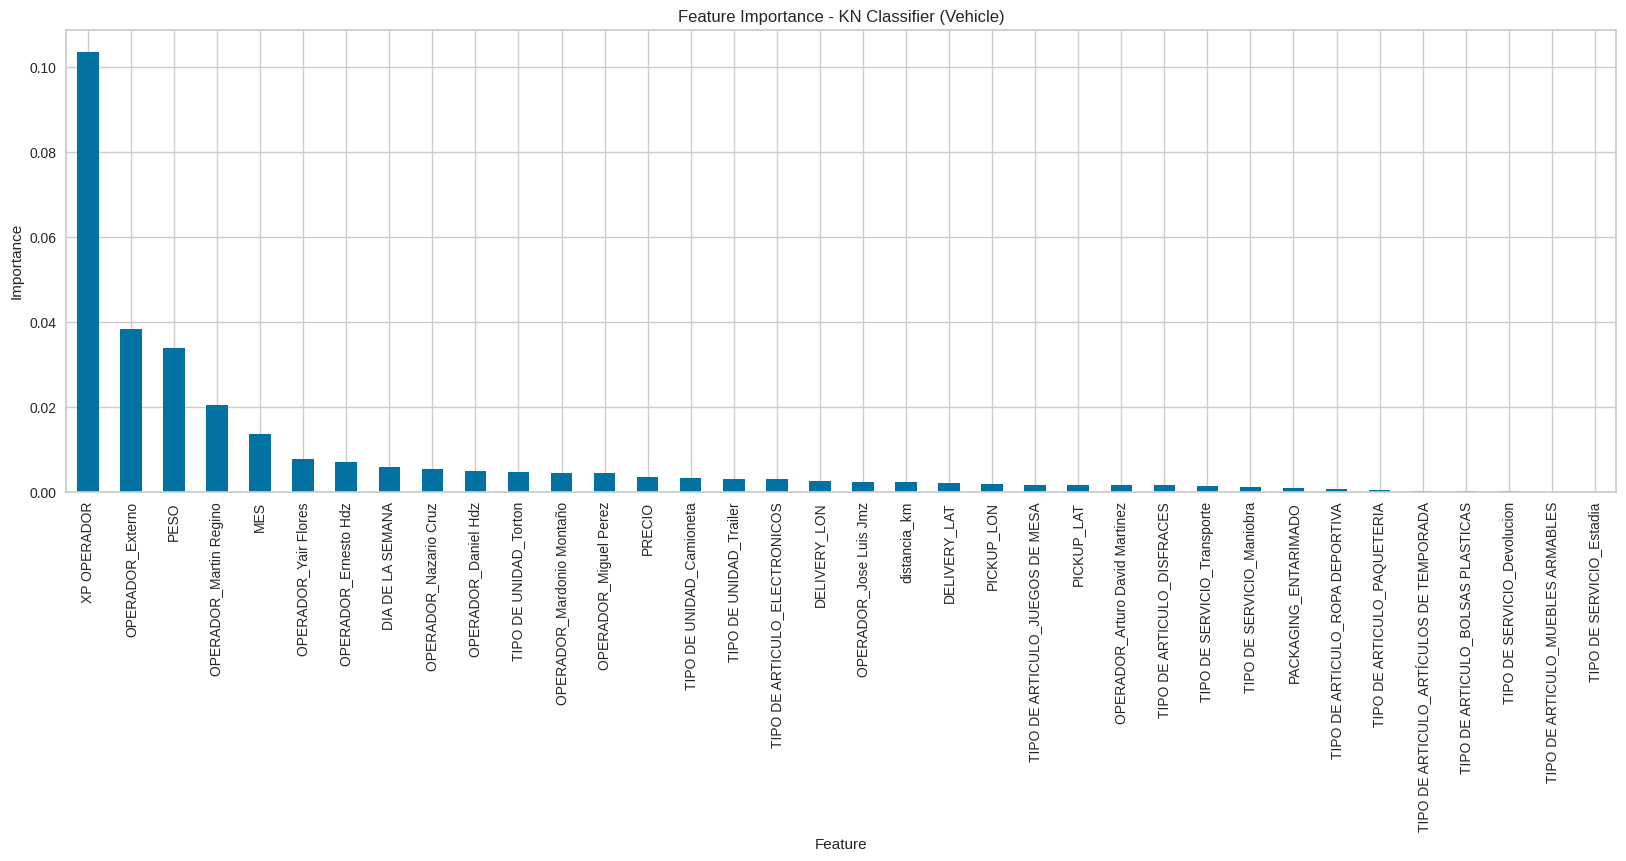

In [89]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = knn_vehicle,
                   model_name = "KN Classifier (Vehicle)",
                   x = x_train_veh_res,
                   y = y_train_veh_res,
                   scorer = F1_scorer)

Podemos ver que una vez más el factor principal es la experiencia del operador. Esto sumado a que aquí afecta ya directamente el operador seleccionado, soportando la teoría de que cada operador tiene ya asignado ciertos vehículos. Otros 2 factores interesantes son el peso y el mes. Esto es necesario ya que el el vehículo debe ser capaz de soportar el peso de la carga y el mes nos indica la carga de trabajo que se tiene en ciertas temporadas del año.

### Content-Based Filtering (CBF)
Este tipo de filtrado a diferencia del filtrado bas (CBF), este se basa prinicipalmente en la similitud de elementos para sugerir nuevos a los usuarios. En nuestro caso, la recomendación de vehículo/conductor será basado en la similitud de las características del viaje en especifico, del vehículo y del usuario, tomando en cuenta el historial de viajes.

La manera en que funcionaría sería:
1. Representación de cada artículo: Cada vehículo y viaje se debe representar como un vector que pueda capturar sus atributos relevantes.

2. Cálculo de similitud: Se calcula la similitud entre los vaijes utilizando métricas como la correlación o distancia.

3. Recomendaciones: Para cada viaje, se identifican los pares de vehículo/conductor con base en la viajes similares al viaje en cuestión.

Para la implementación del CBF utilizaremos Logistic Regression o LR como el algoritmo de clasificación para predecir la probabilidad de que un vehículo/conductor sea recomendado para un viaje en especifico.

Las razones para esto es por su simplicidad, interpretabilidad y su eficiencia.

Dicho esto, empezaremos con su implementación:

## Conductor

In [90]:
start = time.time()
# Definimos el parámetro grid para Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'none'],
    'max_iter': [100, 200, 300]
}

# Definimos el F1 scorer
F1_scorer = metrics.make_scorer(F1_scorer, average='macro')

# Inicializamos el modelo base
lr_drv = LogisticRegression(random_state=1)

# Realizamos la búsqueda aleatoria con validación cruzada
rndm_cv_lr_drv = RandomizedSearchCV(estimator=lr_drv, param_distributions=param_grid_lr, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_lr_drv.fit(x_train_drv_res, y_train_drv_res)

# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Logistic Regression del conductor son {} con un score de cross validation de {}:".format(rndm_cv_lr_drv.best_params_, rndm_cv_lr_drv.best_score_))

# Reinicializamos el modelo, pero esta vez con los valores óptimos
lr_driver= LogisticRegression(
    C=rndm_cv_lr_drv.best_params_['C'],
    solver=rndm_cv_lr_drv.best_params_['solver'],
    penalty=rndm_cv_lr_drv.best_params_['penalty'],
    max_iter=rndm_cv_lr_drv.best_params_['max_iter'],
    random_state=1
)

# Hacemos el fitting del modelo
lr_driver.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Logistic Regression", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_lr_drv = get_metrics_score(
    model=lr_driver,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el Logistic Regression del conductor son {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 0.1} con un score de cross validation de nan:
Training time: 127.90518641471863s
Accuracy on training set: 0.8528112449799197
Accuracy on test set: 0.7734877734877735
Recall on training set: 0.8528112449799197
Recall on test set: 0.7734877734877735
Precision on training set: 0.8507362823657686
Precision on test set: 0.8335878927751137
F1-Score on training set: 0.8448064437471365
F1-Score on test set: 0.7711385047101906


Evaluación general:
- Rendimiento decente: Los resultados indican que el modelo tiene un rendimiento mediano en ambos conjuntos, aunque ligeramente menor el conjunto de pruebas al de entrenamiento, este modelo no muestra tanto overfitting como el pasado.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Análisis de características: analizar las características utilizadas en el modelo para comprender su impacto en el rendimiento del clasificador. Esto puede ayudar en la ingeniería y selección de funciones para mejorar aún más el modelo.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
XP OPERADOR                                         0.652            0.003
PESO                                                0.212            0.004
TIPO DE UNIDAD_Torton                               0.085            0.004
TIPO DE UNIDAD_Trailer                              0.062            0.004
MES                                                 0.043            0.002
distancia_km                                        0.017            0.001
TIPO DE ARTICULO_ELECTRONICOS                       0.016            0.001
PACKAGING_ENTARIMADO                                0.013            0.001
TIPO DE ARTICULO_JUEGOS DE MESA                     0.009            0.001
PICKUP_LAT                                          0.008            0.001
DELIVERY_LON                                        0.007            0.001
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.007            0.001
DIA DE LA SEMANA                                    0.006            0.001
TIPO DE ARTICULO_DISFRACES                          0.005            0.001
TIPO DE SERVICIO_Transporte                         0.005            0.001
DELIVERY_LAT                                        0.005            0.001
PICKUP_LON                                          0.004            0.001
TIPO DE SERVICIO_Maniobra                           0.002            0.001
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.002            0.001
TIPO DE ARTICULO_MUEBLES ARMABLES                   0.002            0.000
PRECIO                                              0.001            0.001
TIPO DE UNIDAD_Camioneta                            0.001            0.001
TIPO DE SERVICIO_Estadia                            0.001            0.000
TIPO DE ARTICULO_PAQUETERIA                         0.000            0.000
TIPO DE SERVICIO_Devolucion                         0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                  -0.000            0.000

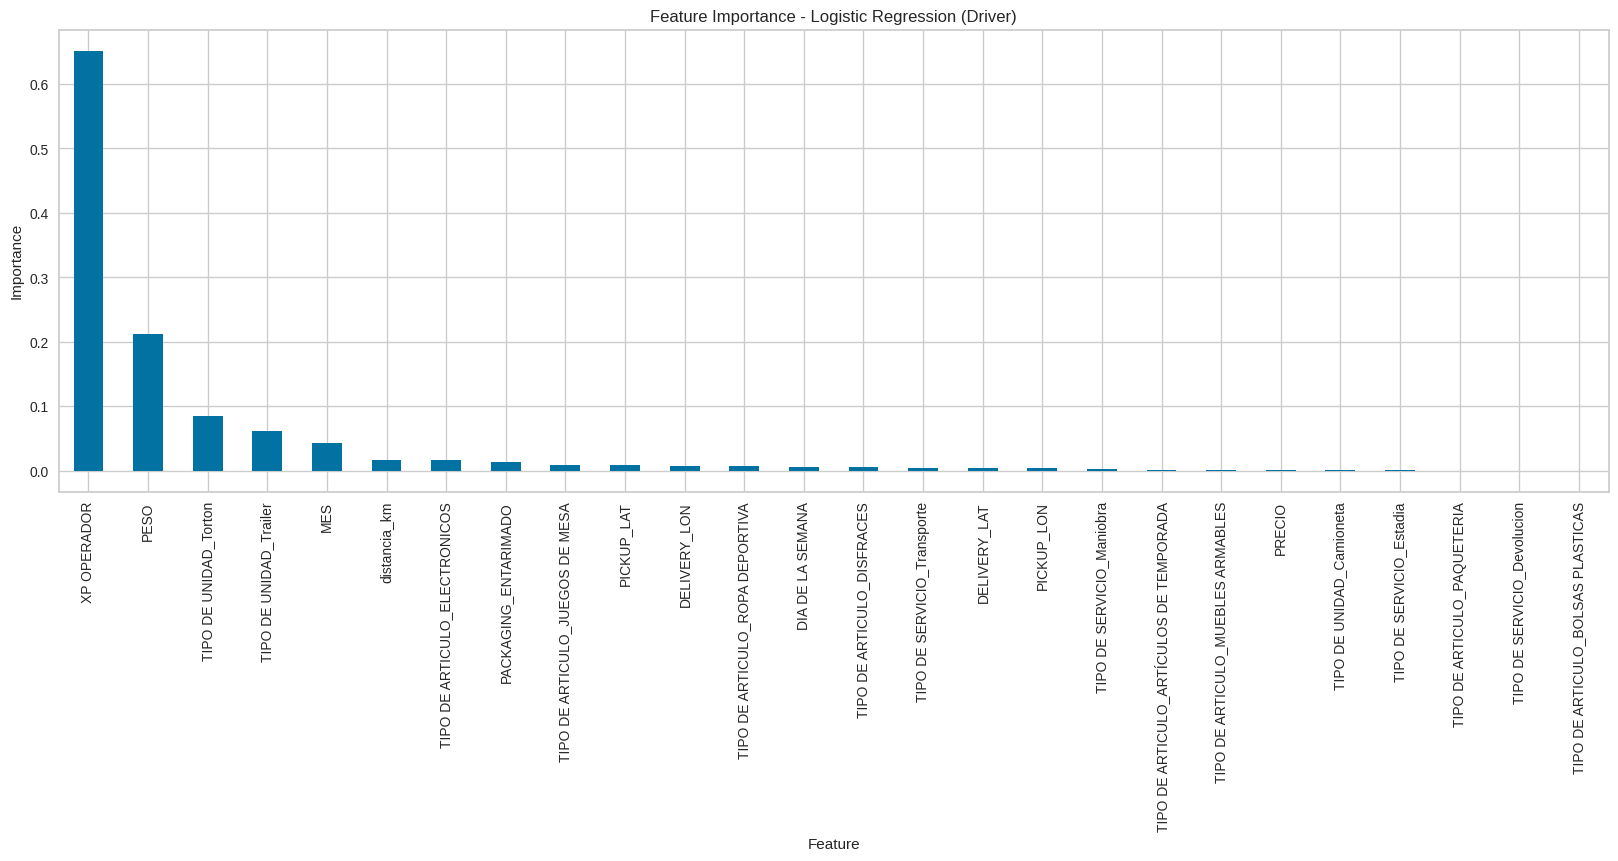

In [91]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = lr_driver,
                   model_name = "Logistic Regression (Driver)",
                   x = x_train_drv_res,
                   y = y_train_drv_res,
                   scorer = F1_scorer)

Una vez más la experiencia del operador es el jugador principal al momento de elegir conductor, en segundo lugar el peso. Esto parece ser correcto, ya que ambas variables están conectadas al siempre darle viajes con cargas más pesadas a choferes con mayor experiencia.

En este caso, si depende el tipo de unidad solicitada para asignar al chofer. Esto es correcto ya que ciertos choferes solo manejan ciertos tipos de cargas.

## Vehículo

In [92]:
start = time.time()
# Definimos el parámetro grid para Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'none'],
    'max_iter': [100, 200, 300]
}

# Definimos el F1 scorer
F1_scorer = metrics.make_scorer(F1_scorer, average='macro')

# Inicializamos el modelo base
lr_veh = LogisticRegression(random_state=1)

# Realizamos la búsqueda aleatoria con validación cruzada
rndm_cv_lr_veh = RandomizedSearchCV(estimator=lr_veh, param_distributions=param_grid_lr, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_lr_veh.fit(x_train_veh_res, y_train_veh_res)

# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Logistic Regression del vehiculo son {} con un score de cross validation de {}:".format(rndm_cv_lr_veh.best_params_, rndm_cv_lr_veh.best_score_))

# Reinicializamos el modelo, pero esta vez con los valores óptimos
lr_vehicle= LogisticRegression(
    C=rndm_cv_lr_veh.best_params_['C'],
    solver=rndm_cv_lr_veh.best_params_['solver'],
    penalty=rndm_cv_lr_veh.best_params_['penalty'],
    max_iter=rndm_cv_lr_veh.best_params_['max_iter'],
    random_state=1
)

# Hacemos el fitting del modelo
lr_vehicle.fit(x_train_veh_res, y_train_veh_res)
stop = time.time()
training_times_veh.append(["Logistic Regression", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_lr_veh = get_metrics_score(
    model=lr_vehicle,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el Logistic Regression del vehiculo son {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 0.1} con un score de cross validation de nan:
Training time: 96.41188073158264s
Accuracy on training set: 0.9823056882327399
Accuracy on test set: 0.9897039897039897
Recall on training set: 0.9823056882327399
Recall on test set: 0.9897039897039897
Precision on training set: 0.9834331957901888
Precision on test set: 0.9948811216416851
F1-Score on training set: 0.9822317089829136
F1-Score on test set: 0.9909868019395964


Evaluación general:
- Alto rendimiento: el modelo muestra un muy buen rendimiento en todas las métricas tanto con los datos de training, como los de test. Las métricas tienen un valor alto, lo que indica que el modelo es bueno tanto para aprender de los datos de training como para generalizar ante datos nuevos.

- Overfitting mínimo: ya que tenemos un score relativamente alto en la parte de entrenamiento y ligeramente más alto en comparación con el conjunto de test, sugieren un pequeño overfitting.

- Generalización: el modelo generaliza bien con datos nunca antes vistos, esto lo podemos notar en la ligera caída entre las métricas del conjunto de training contra las de test.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Análisis de características: analizar las características utilizadas en el modelo para comprender su impacto en el rendimiento del clasificador. Esto puede ayudar en la ingeniería y selección de funciones para mejorar aún más el modelo.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
XP OPERADOR                                         0.183            0.002
PESO                                                0.169            0.002
OPERADOR_Yair Flores                                0.083            0.001
OPERADOR_Ernesto Hdz                                0.069            0.001
OPERADOR_Externo                                    0.059            0.001
OPERADOR_Daniel Hdz                                 0.041            0.001
OPERADOR_Nazario Cruz                               0.033            0.000
OPERADOR_Martin Regino                              0.029            0.001
TIPO DE ARTICULO_ELECTRONICOS                       0.029            0.001
TIPO DE UNIDAD_Torton                               0.012            0.000
OPERADOR_Miguel Perez                               0.012            0.000
MES                                                 0.007            0.001
PICKUP_LAT                                          0.007            0.001
TIPO DE UNIDAD_Camioneta                            0.004            0.000
PRECIO                                              0.004            0.001
OPERADOR_Mardonio Montaño                           0.003            0.000
TIPO DE ARTICULO_DISFRACES                          0.003            0.000
PICKUP_LON                                          0.003            0.001
TIPO DE SERVICIO_Transporte                         0.003            0.000
DELIVERY_LON                                        0.003            0.001
distancia_km                                        0.001            0.000
PACKAGING_ENTARIMADO                                0.001            0.001
DELIVERY_LAT                                        0.001            0.000
TIPO DE SERVICIO_Devolucion                         0.001            0.000
TIPO DE ARTICULO_JUEGOS DE MESA                     0.001            0.000
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.001            0.000
OPERADOR_Arturo David Martinez                      0.001            0.000
DIA DE LA SEMANA                                    0.001            0.000
OPERADOR_Jose Luis Jmz                              0.000            0.000
TIPO DE UNIDAD_Trailer                              0.000            0.000
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.000            0.000
TIPO DE SERVICIO_Estadia                            0.000            0.000
TIPO DE ARTICULO_MUEBLES ARMABLES                   0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                   0.000            0.000
TIPO DE ARTICULO_PAQUETERIA                        -0.000            0.000
TIPO DE SERVICIO_Maniobra                          -0.001            0.000

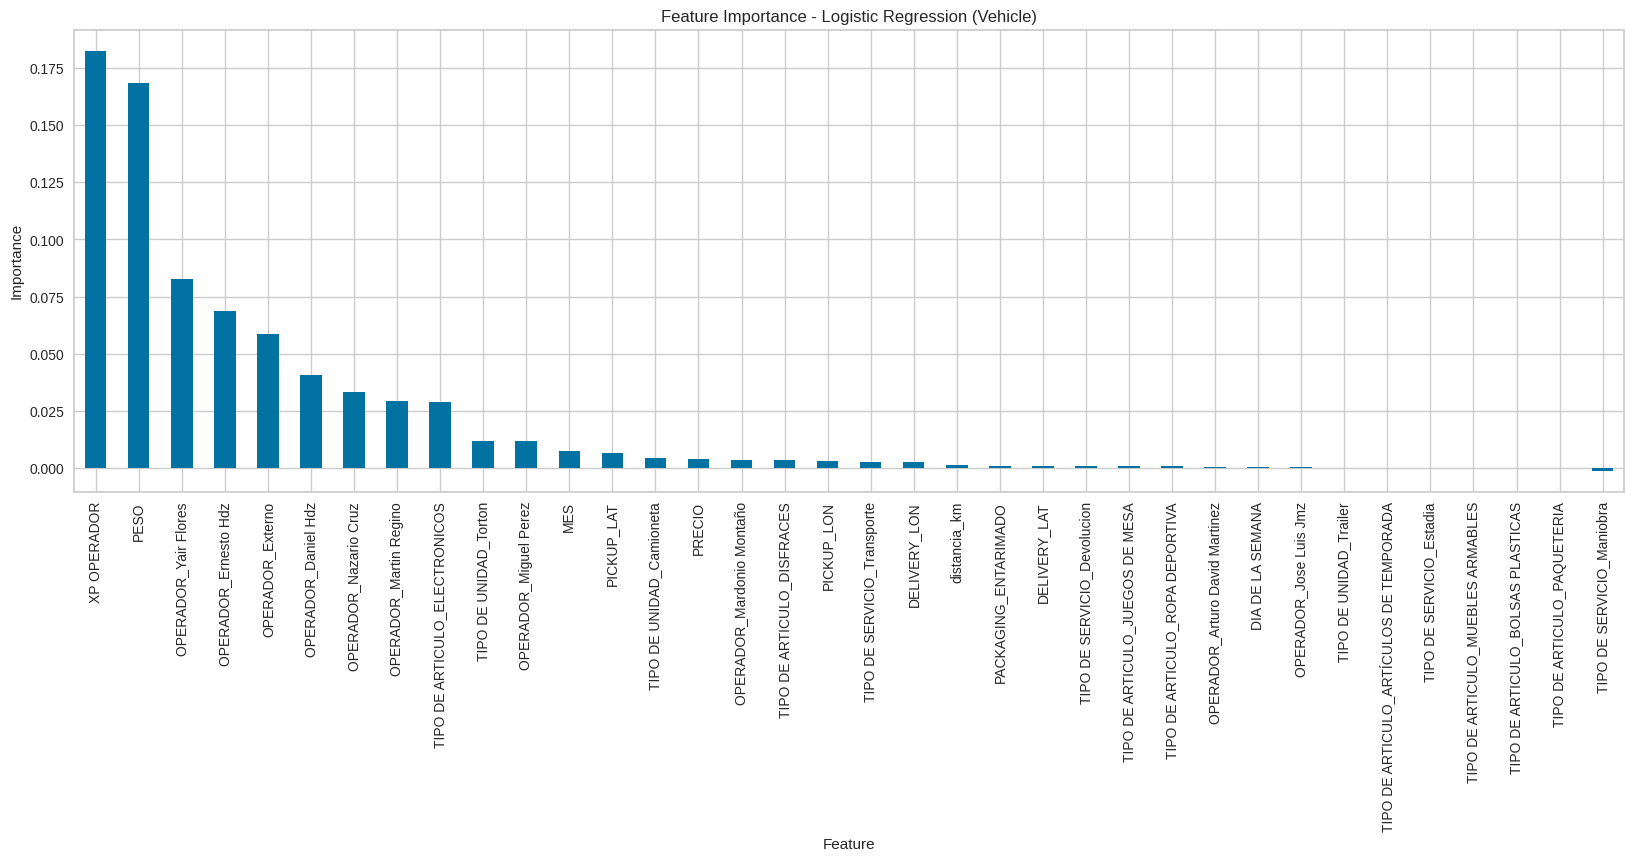

In [93]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = lr_vehicle,
                   model_name = "Logistic Regression (Vehicle)",
                   x = x_train_veh_res,
                   y = y_train_veh_res,
                   scorer = F1_scorer)

La distribución de peso en este modelo parece ser muy similar al modelo anterior, siendo la experiencia de usuario el factor principal, junto con el peso de la carga. Aquí lo único que cambia es el orden de los operadores y el peso que tiene cada uno en el modelo.

## Conclusiones
Podemos observar que para ambas variables los modelos tiene un nivel altamente aceptable, sobre todo para la selección de vehículo. Creo que todavía el de la selección de chofer se podría mejorar aún más. Pareciera que faltan variables importantes en nuestra base de datos para hacer más determinística la predicción. En fin, buscaremos con nuevos modelos para poder mejorar los resultados en ambos casos.

Por los resultados podemos ver que el modelo de Logistic Regression tiene un mejor resultado y reduce el overfitting. Haciéndolo nuestro modelo base para la implementación.


_________
# Avance 4 - Modelos Alternativos

Para esta sección probaremos 6 modelos distintos a los ya propuestos para hacer un benchmark de posibles soluciones. Al final se hará una comparativa para seleccionar el modelo con mejor performance para nuestra aplicación.

## Modelos alternativos junto con su búsqueda de hiperparámetros

## Modelo 1: Decision Tree
Decision Tree o árboles de decision son un algoritmo que se utiliza en distintas tareas de clasifiación gracias a su simplicidad, intepretabilidad y efectividad. Si lo vemos en general, este se construye de manera recursiva a partir de un conjunto de datos de entrenamiento. Como su nombre lo indica, este parece un árbol, cada nodo representa una prueba sobre un feature y las ramas representan posibles resultados. Al final, en los nodos finales se asignan instancias de datos a una clase predicha.

Este podría ser un buen modelo para clasificar los vehículos y conductores.
#### Parámetros de Búsqueda

Para encontrar los mejores valores, utilizamos una matriz de posibles valores para que con herramientas como GridSearch o Random Search podamos encontrar la mejor combinación. En este caso los posibles factores son los siguientes:
1. Max Depth: Controla que tan profundo puede crecer el arbol. Entre más grande el árbol puede capturar más ruido y hacer overfitting.
2. Min Samples Leaf: Nos determina el número mínimo de samples que pueden estar en el útlimo nodo. Esto ayuda a prevenir overfitting.
3. Max Leaf Nodes: Setea el número máximo de hojas que cada nodo puede tener.
4. Min Impurity Decrease: Define la mejora mínima en la métrica cualitativa del corte, requerido para crear un nuevo corte en el arbol. Ayuda a prevenir cortes que no generan mejoría en el modelo.

In [94]:
# Parameter grid to pass in RandomSearchCV
param_grid_dt = {'max_depth': np.arange(2,30),
                'min_samples_leaf': [1, 2, 5, 7, 10],
                'max_leaf_nodes' : [2, 3, 5, 10,15],
                'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
                }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [95]:
start = time.time()
# Inicializamos el modelo base
dt_drv = DecisionTreeClassifier(max_depth=3, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_dt_drv = RandomizedSearchCV(estimator=dt_drv, param_distributions=param_grid_dt, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_dt_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el decision tree del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_dt_drv.best_params_,rndm_cv_dt_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
dt_drv_tuned = DecisionTreeClassifier(
    max_depth=rndm_cv_dt_drv.best_params_['max_depth'],
    max_leaf_nodes=rndm_cv_dt_drv.best_params_['max_leaf_nodes'],
    random_state=1,
    min_impurity_decrease=rndm_cv_dt_drv.best_params_['min_impurity_decrease'],
    min_samples_leaf=rndm_cv_dt_drv.best_params_['min_samples_leaf']
)

# Hacemos el fitting del modelo
dt_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Decision Tree", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_dt_drv = get_metrics_score(model = dt_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el decision tree del conductor son {'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 18} con un score de cross validation de 0.8971780813726831:
Training time: 1.8382813930511475s
Accuracy on training set: 0.9089357429718875
Accuracy on test set: 0.8494208494208494
Recall on training set: 0.9089357429718875
Recall on test set: 0.8494208494208494
Precision on training set: 0.9066985995852375
Precision on test set: 0.9109515218457261
F1-Score on training set: 0.9041538948173978
F1-Score on test set: 0.8623143343444698


#### Overall Insights:

Con el ajuste de los hiperparámetros del decision tree se logró un score bastante bueno en la validación cruzada de 0.897. El rendimiento del modelo en ambos conjuntos muestran un buen equilibrio, indicando que el modelo no está sobreajustado y generaliza bien.

Estos resultados mejoran mucho a comparación con los modelos anteriores.

### Vehículo

In [96]:
start = time.time()
# Inicializamos el modelo base
dt_veh = DecisionTreeClassifier(max_depth=3, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_dt_veh = RandomizedSearchCV(estimator=dt_drv, param_distributions=param_grid_dt, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_dt_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el decision tree del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_dt_veh.best_params_,rndm_cv_dt_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
dt_veh_tuned = DecisionTreeClassifier(
    max_depth=rndm_cv_dt_veh.best_params_['max_depth'],
    max_leaf_nodes=rndm_cv_dt_veh.best_params_['max_leaf_nodes'],
    random_state=1,
    min_impurity_decrease=rndm_cv_dt_veh.best_params_['min_impurity_decrease'],
    min_samples_leaf=rndm_cv_dt_veh.best_params_['min_samples_leaf']
)

# Hacemos el fitting del modelo
dt_veh_tuned.fit(x_train_veh_res, y_train_veh_res)
stop = time.time()
training_times_veh.append(["Decision Tree", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_dt_veh = get_metrics_score(model = dt_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el decision tree del vehiculo son {'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 18} con un score de cross validation de 0.9753269946183905:
Training time: 1.9312636852264404s
Accuracy on training set: 0.9756838905775076
Accuracy on test set: 0.9948519948519948
Recall on training set: 0.9756838905775076
Recall on test set: 0.9948519948519948
Precision on training set: 0.9761244023376057
Precision on test set: 0.9962609225767121
F1-Score on training set: 0.9756372408519416
F1-Score on test set: 0.9953667953667953


### Overall Insights:
El rendimiento de este modelo es muy bueno. Teniendo un score en validación cruzada de 0.97532699. El rendimiento del modelo nos indica que el modelo generaliza extremadamente bien y está bien ajustado. Los resultados de F1'Score en ambos conjuntos sugieren que el modelo tiene una gran capacidad de discriminación entre las clases.



## Modelo 2 - Bagging Classifier
Bagging Classifier es un método de machine learning que utiliza múltiples árboles de decisión para mejorar robustez y precisión  de la clasificación multivariable.

La idea detrás de esto es entrenar múltiples árboles de decisión de manera independiente, utilizando subconjuntos aleatores del conjunto de entrenamiento. Cada árbol se construye y luego se combinan los resultados.

#### Parámetros de Búsqueda
1. Max Samples: Nos dice la porción de samples que se puede extraer del training set para entrenar de manera individual cada decision tree
2. Recommendation: Este parametro controla la proporción aleatoria de los features que se consideraran para separar cada nodo
3. Max Features: Es el número de decision trees utilizado

In [97]:
param_grid_bag = {'max_samples': [0.7,0.8,0.9,1],
                  'max_features': [0.7,0.8,0.9,1],
                  'n_estimators' : [10,20,30,40,50],
                 }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [98]:
start = time.time()
# Inicializamos el modelo base
bag_drv = BaggingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_bag_drv = RandomizedSearchCV(estimator=bag_drv, param_distributions=param_grid_bag, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_bag_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Bagging del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_bag_drv.best_params_,rndm_cv_bag_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
bag_drv_tuned = BaggingClassifier(
    max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
    max_features=rndm_cv_bag_drv.best_params_['max_features'],
    random_state=1,
    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators']
)

# Hacemos el fitting del modelo
bag_drv_tuned.fit(x_train_drv_res, y_train_drv_res)
stop = time.time()
training_times_drv.append(["Bagging", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_bag_drv = get_metrics_score(model = bag_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Bagging del conductor son {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.9} con un score de cross validation de 0.9649551945886357:
Training time: 11.022372484207153s
Accuracy on training set: 0.9937751004016064
Accuracy on test set: 0.915057915057915
Recall on training set: 0.9937751004016064
Recall on test set: 0.915057915057915
Precision on training set: 0.9938089770236136
Precision on test set: 0.917731210473146
F1-Score on training set: 0.9937474867124855
F1-Score on test set: 0.9159972303465073


### Overall insights
El modelo de bagging ha mostrado un excelente rendimiento en ambos datasets. La alta precisión y alto F1-score el conjunto de prueba inidcan que el modelo generaliza bien a nuevos datos y mantiene un equilibrio entre precisión y recall. La ligera diferencia en los resultados de ambos conjuntos sugieren que el modelo no está sobreajustado.

### Vehículo

In [99]:
start = time.time()
# Inicializamos el modelo base
bag_veh = BaggingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_bag_veh = RandomizedSearchCV(estimator=bag_veh, param_distributions=param_grid_bag, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_bag_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Bagging del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_bag_veh.best_params_,rndm_cv_bag_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
bag_veh_tuned = BaggingClassifier(
    max_samples=rndm_cv_bag_veh.best_params_['max_samples'],
    max_features=rndm_cv_bag_veh.best_params_['max_features'],
    random_state=1,
    n_estimators=rndm_cv_bag_veh.best_params_['n_estimators']
)

# Hacemos el fitting del modelo
bag_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Bagging", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_bag_veh = get_metrics_score(model = bag_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Bagging del vehiculo son {'n_estimators': 30, 'max_samples': 0.8, 'max_features': 0.8} con un score de cross validation de 0.9993490554791504:
Training time: 9.667665004730225s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.9987129987129987
Recall on training set: 0.9997828918801563
Recall on test set: 0.9987129987129987
Precision on training set: 0.9997835497835499
Precision on test set: 0.999034749034749
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9987892322387096


### Overall Insights:
El modelo de bagging está mostrando ser extremadamente preciso y fiable, casi alcanzando la prefección en todos los scores en ambos conjuntos de datos. La ligera diferencia en los resultados de ambos datasets indica que el modelo generaliza muy bien y que no tiene un sobreajuste.

## Modelo 3 - Random Forest Classifier
Random Forest es un algoritmo de ML que combina múltiples árboles de decisión para mejorar la precisión y robustez de la clasificación.

A diferencia de Bagging, en cada nodo del árbol se introducen elementos aleatorios durante el proceso de entrenamiento. Esto generalmente provoca un mayor nivel de precisión, además de ser más robusto ante el overfitting.

### Parámetros de Búsqueda
- N Estimators: Este parámetro settea el número de decision trees dentro del random forest
- Min Samples Leaf: Este parámetro determina el mínimo de hojas permitida en el último nodo del árbol.
- Max Features: Número de features que se escogen de manera random del training set que son considerados para el split de cada nodo en cada decision tree
- Max samples: Este parámetro controla la proporción de los samples que se extrae de cada training set para entrenar cada decision tree

In [100]:
param_grid_rf = {"n_estimators": [100,150,250],
              "min_samples_leaf": np.arange(1, 6),
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
              "max_samples": np.arange(0.2, 0.6, 0.1)}
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [101]:
start = time.time()
# Inicializamos el modelo base
rf_drv = RandomForestClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_rf_drv = RandomizedSearchCV(estimator=rf_drv, param_distributions=param_grid_rf, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_rf_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el random forest del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_rf_drv.best_params_,rndm_cv_rf_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
rf_drv_tuned = RandomForestClassifier(
    n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
    min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
    random_state=1,
    max_features=rndm_cv_rf_drv.best_params_['max_features'],
    max_samples=rndm_cv_rf_drv.best_params_['max_samples']
)

# Hacemos el fitting del modelo
rf_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Random Forest", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_rf_drv = get_metrics_score(model = rf_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el random forest del conductor son {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} con un score de cross validation de 0.9591097699830421:
Training time: 16.071303367614746s
Accuracy on training set: 0.9904618473895582
Accuracy on test set: 0.9099099099099099
Recall on training set: 0.9904618473895582
Recall on test set: 0.9099099099099099
Precision on training set: 0.9906142610134856
Precision on test set: 0.9181218145439042
F1-Score on training set: 0.9903886651435013
F1-Score on test set: 0.9120696996962206


### Overall insights
Podemos observar que de igual manera, este modelo tiene un nivel alto de rendimiento y de generalización, esto debido al alto nivel de rendimiento mostrado en los resultados. Podemos observar que tiene un nivel bajo de overfitting pero aún así existe. Esto debido a la diferencia entre los datos de entrenamiento y los datos de prueba.

### Vehículo

In [102]:
start = time.time()

# Inicializamos el modelo base
rf_veh = RandomForestClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_rf_veh = RandomizedSearchCV(estimator=rf_veh, param_distributions=param_grid_rf, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_rf_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el random forest del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_rf_veh.best_params_,rndm_cv_rf_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
rf_veh_tuned = RandomForestClassifier(
    n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
    min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
    random_state=1,
    max_features=rndm_cv_rf_veh.best_params_['max_features'],
    max_samples=rndm_cv_rf_veh.best_params_['max_samples']
)

# Hacemos el fitting del modelo
rf_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Random Forest", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_rf_veh = get_metrics_score(model = rf_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el random forest del vehiculo son {'n_estimators': 250, 'min_samples_leaf': 2, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} con un score de cross validation de 0.9995653820402477:
Training time: 13.36804723739624s
Accuracy on training set: 0.9995657837603127
Accuracy on test set: 1.0
Recall on training set: 0.9995657837603127
Recall on test set: 1.0
Precision on training set: 0.9995670995670995
Precision on test set: 1.0
F1-Score on training set: 0.9995654512961777
F1-Score on test set: 1.0


### Overall Insights:
El rendimiento de este modelo fue prácticamente perfecto en ambos datasets. Hasta el momento este modelo es el que muestra resultados prometedores. El modelo generaliza bien y no tiene overfitting.

## Modelo 4 - AdaBoost Tree
Adaboost o Adaptive Boosting es un modelo ed ML que combina multiples decision trees para construir un clasificador robusto y preciso. A diferencia de otros métodos, este usa un mecanismo llamado ponderación adaptativa que le da un peso mayor a arboles que tienen un mejor rendimiento en subconjuntos específicos. Esto en general ayuda a la precisión del modelo.

### Parámetros de Búsqueda
- n estimators: este fator es el número de etapas de boosting o iteraciones que se usan en adaboost. En cada etapa un nuevo arbol de decisiones debil es añadido.
- learning rate: Este parametro controla el impacto de cada nuevo arbol añadido al modelo
- base estimator: especigica los parámetros usados en cada weak learner de cada etapa de boosting

In [103]:
param_grid_adab = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor


In [104]:
start = time.time()
# Inicializamos el modelo base
adab_drv = AdaBoostClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_adab_drv = RandomizedSearchCV(estimator=adab_drv, param_distributions=param_grid_adab, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_adab_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Adaboost del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_adab_drv.best_params_,rndm_cv_adab_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
adab_drv_tuned = AdaBoostClassifier(
    n_estimators=rndm_cv_adab_drv.best_params_['n_estimators'],
    learning_rate=rndm_cv_adab_drv.best_params_['learning_rate'],
    random_state=1,
    base_estimator=rndm_cv_adab_drv.best_params_['base_estimator']
)

# Hacemos el fitting del modelo
adab_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Adaboost", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_adab_drv = get_metrics_score(model = adab_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Adaboost del conductor son {'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} con un score de cross validation de 0.8789764955671149:
Training time: 49.47183012962341s
Accuracy on training set: 0.892570281124498
Accuracy on test set: 0.8082368082368082
Recall on training set: 0.892570281124498
Recall on test set: 0.8082368082368082
Precision on training set: 0.9078399251438468
Precision on test set: 0.9143624547351256
F1-Score on training set: 0.877244341918215
F1-Score on test set: 0.7886679003495435


### Overall Insight:
Los resultados de este modelo muestran resultados medianamente buenos. A pesar de que el modelo esta hyper tuneado pareciera que los resultados no son los mejores. Este modelo muestra un nivel regular de overfitting dada la diferencia de los scores en ambos datasets. Probablemente se necesite seguir ajustando el modelo con más opciones de parámetros.

### Vehículo

In [105]:
start = time.time()
# Inicializamos el modelo base
adab_veh = AdaBoostClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_adab_veh = RandomizedSearchCV(estimator=adab_veh, param_distributions=param_grid_adab, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_adab_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Adaboost del vehículo son {} con un score de cross validation de {}:" .format(rndm_cv_adab_veh.best_params_,rndm_cv_adab_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
adab_veh_tuned = AdaBoostClassifier(
    n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
    learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
    random_state=1,
    base_estimator=rndm_cv_adab_veh.best_params_['base_estimator']
)

# Hacemos el fitting del modelo
adab_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Adaboost", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_adab_veh = get_metrics_score(model = adab_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Adaboost del vehículo son {'n_estimators': 90, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} con un score de cross validation de 0.9993491097541284:
Training time: 52.185494899749756s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.9987129987129987
Recall on training set: 0.9997828918801563
Recall on test set: 0.9987129987129987
Precision on training set: 0.9997835497835499
Precision on test set: 0.999034749034749
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9987892322387096


### Overall Insight:
Este modelo muestra buenos resultados, siendo otro de los modelos con scores bastante altos. La diferencia en los resultados de ambos datasets es prácticamente nula, mostrando una buena generalización con datos no vistos y un buen ajuste.

## Modelo 5 - Gradient Boost

Gradient Boost es un modelo que al igual que los anteriores combina multiples arboles de decisión debiles para construir un clasificador robusto y preciso. La diferencia con este método es que usa un enfoque secuencial para construir el modelo. En cada iteración, se agrega un nuevo arbol al ensamble, optimizando la selección de características y dirección de división, minimizando el error.

### Parámetros de Búsqueda
- Init: Este parámetro especifica el modelo inicial usado para la primera iteración
- N Estimators: Nos dice el número de etapas de boosting o iteraciones que se usarán.
- Learning Rate: Nos dice el impacto que tendra cada nuevo árbol añadido
- Subsample: Nos permite controlar la porción de samples que se extraerán del training set original para entrenar cada decision tree.
- Max Features: Control a la porción de columnas que se seleccionarán random del training set original para considerar en el split de cada nodo en cada decision tree.

In [106]:
param_grid_gb = {"init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
                  "n_estimators": np.arange(75,150,25),
                  "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
                  "subsample":[0.5,0.7,1],
                  "max_features":[0.5,0.7,1],
                }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [107]:
start = time.time()
# Inicializamos el modelo base
gb_drv = GradientBoostingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_gb_drv = RandomizedSearchCV(estimator=gb_drv, param_distributions=param_grid_gb, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_gb_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Gradient Boost del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_gb_drv.best_params_,rndm_cv_gb_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
gb_drv_tuned = GradientBoostingClassifier(
    init=rndm_cv_gb_drv.best_params_['init'],
    n_estimators=rndm_cv_gb_drv.best_params_['n_estimators'],
    random_state=1,
    learning_rate=rndm_cv_gb_drv.best_params_['learning_rate'],
    subsample=rndm_cv_gb_drv.best_params_['subsample'],
    max_features=rndm_cv_gb_drv.best_params_['max_features']
)

# Hacemos el fitting del modelo
gb_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["GradientBoost", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_gb_drv = get_metrics_score(model = gb_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Gradient Boost del conductor son {'subsample': 1, 'n_estimators': 75, 'max_features': 0.7, 'learning_rate': 0.01, 'init': DecisionTreeClassifier(random_state=1)} con un score de cross validation de 0.962334084211653:
Training time: 182.91114139556885s
Accuracy on training set: 0.9939759036144579
Accuracy on test set: 0.8996138996138996
Recall on training set: 0.9939759036144579
Recall on test set: 0.8996138996138996
Precision on training set: 0.9940976361175237
Precision on test set: 0.9006808097033662
F1-Score on training set: 0.9939414705194924
F1-Score on test set: 0.9000733817809967


### Overall Insight:
Los resultados muestran un modelo bien balanceado y con buena generalización.Tiene un desempeño excelente en las métricas de precisión y F1-Score, lo que indica que el modelo es robusto y confiable. Además de que muestra un alto nivel de cross validation sugiere que el modelo tiene una capacidad de predicción alta.

### Vehículo

In [108]:
start = time.time()
# Inicializamos el modelo base
gb_veh = GradientBoostingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_gb_veh = RandomizedSearchCV(estimator=gb_veh, param_distributions=param_grid_gb, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_gb_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Gradient Boost del vehículo son {} con un score de cross validation de {}:" .format(rndm_cv_gb_veh.best_params_,rndm_cv_gb_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
gb_veh_tuned = GradientBoostingClassifier(
    init=rndm_cv_gb_veh.best_params_['init'],
    n_estimators=rndm_cv_gb_veh.best_params_['n_estimators'],
    random_state=1,
    learning_rate=rndm_cv_gb_veh.best_params_['learning_rate'],
    subsample=rndm_cv_gb_veh.best_params_['subsample'],
    max_features=rndm_cv_gb_veh.best_params_['max_features']
)

# Hacemos el fitting del modelo
gb_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["GradientBoost", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_gb_veh = get_metrics_score(model = gb_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Gradient Boost del vehículo son {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} con un score de cross validation de 0.999566147191383:
Training time: 252.30373740196228s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.9987129987129987
Recall on training set: 0.9997828918801563
Recall on test set: 0.9987129987129987
Precision on training set: 0.9997835497835499
Precision on test set: 0.9987239987239988
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9987000653806892


### Overall Results:
Este es un muy buen modelo, con resultados altos en las métricas, convirtiendose en un excelente candidato para el modelo final. Podemos ver que la diferencia de los resultados es mínima, mostrando un nivel nulo de overfitting. Además de un cross validation score bastante elevado, mostrando un nivel alto de predicción.

## Modelo 6 - MLP
MUltilayer perceptron o MLP, son redes neuronales artificiales multicapa supervisada. A diferencia de las redes neuronales simples, estos cuentan con una arquitectura compleja que incluye múltiples capas ocultas entre la capa de entrada y la capa de salida.

La manera en que funciona que es que los MLPs procesan información a través de un flujo de señales entre capas compuestas por neuronas artificiales. Cada neurona aplica una función de activación no lineal a la suma ponderada de sus entradas, generando una salida que se propaga a la siguiente capa. Este proceso iterativo le permite a la red aprender patrones complejos en los datos de entrenamiento y realizar predicciones.

### Parámetros de Búsqueda
- Hidden Layers sizes: captura la arquitectura deseada para las capas ocultas en el MLP. Es una tupla de números que nos dan el número de neuronas en cada capa.
- Activation: Nos especifica la función de activación que se le da a la suma ponderada de inputs de cada neurona. Esta función le da su no linearidad a la red.
- Solver: Este parámetro especifica el algoritmo usado para entrenar el MLP. Este minimza la loss function ajustando los pesos de la red.
- Alpha: Est afunción controla el nivel del termino de regularización L1. Este penaliza al modelo por tener pesos grandes y reduce la cantidad de componentes diferentes a cero, ayudando a prevenir el overfitting.
- Learning Rate: Controla el step size que se de por el optimizador durante el entrenamiento para actuzalizar los pesos en la red.

In [109]:
from sklearn.neural_network import MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}


F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [110]:
start = time.time()

# Inicializamos el modelo base
mlp_drv = MLPClassifier(max_iter=1000, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_mlp_drv = RandomizedSearchCV(estimator=mlp_drv, param_distributions=param_grid_mlp, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_mlp_drv.fit(x_train_drv_res, y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el MLP del conductor son {} con un score de cross validation de {}:".format(rndm_cv_mlp_drv.best_params_, rndm_cv_mlp_drv.best_score_))
# reinicializamos el modelo, pero esta vez con los valores óptimos
mlp_drv_tuned = MLPClassifier(
    hidden_layer_sizes=rndm_cv_mlp_drv.best_params_['hidden_layer_sizes'],
    activation=rndm_cv_mlp_drv.best_params_['activation'],
    solver=rndm_cv_mlp_drv.best_params_['solver'],
    alpha=rndm_cv_mlp_drv.best_params_['alpha'],
    learning_rate=rndm_cv_mlp_drv.best_params_['learning_rate'],
    max_iter=1000,
    random_state=1
)

# Hacemos el fitting del modelo
mlp_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Multi-Layer Perceptron", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_mlp_drv = get_metrics_score(
    model=mlp_drv_tuned,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el MLP del conductor son {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'} con un score de cross validation de 0.9568313513013283:
Training time: 664.6615490913391s
Accuracy on training set: 0.9805220883534137
Accuracy on test set: 0.8867438867438867
Recall on training set: 0.9805220883534137
Recall on test set: 0.8867438867438867
Precision on training set: 0.9805108777607819
Precision on test set: 0.8934897119954484
F1-Score on training set: 0.9802829364219273
F1-Score on test set: 0.8897485561305354


### Overall Insight:
Este es uno de los resultados más altos para este conjunto de datos. Muestra un nivel bueno de precision y de F1-Score para ambos datasets. Sin embargo, existe una diferencia baja-mediana en los resultados de los datasets de pruebas y entrenamiento, mostrando que existe un nivel bajo-mediano de overfitting.

### Vehículo

In [111]:
start = time.time()
# Inicializamos el modelo base
mlp_veh = MLPClassifier(max_iter=1000, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_mlp_veh = RandomizedSearchCV(estimator=mlp_veh, param_distributions=param_grid_mlp, n_jobs=-1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_mlp_veh.fit(x_train_veh_res, y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el MLP del vehiculo son {} con un score de cross validation de {}:".format(rndm_cv_mlp_veh.best_params_, rndm_cv_mlp_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
mlp_veh_tuned = MLPClassifier(
    hidden_layer_sizes=rndm_cv_mlp_veh.best_params_['hidden_layer_sizes'],
    activation=rndm_cv_mlp_veh.best_params_['activation'],
    solver=rndm_cv_mlp_veh.best_params_['solver'],
    alpha=rndm_cv_mlp_veh.best_params_['alpha'],
    learning_rate=rndm_cv_mlp_veh.best_params_['learning_rate'],
    max_iter=1000,
    random_state=1
)

# Hacemos el fitting del modelo
mlp_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Multi-Layer Perceptron", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_mlp_veh = get_metrics_score(
    model=mlp_veh_tuned,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Los mejores parámetros para el MLP del vehiculo son {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'relu'} con un score de cross validation de 0.9993491097779913:
Training time: 346.4466471672058s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.9948519948519948
Recall on training set: 0.9997828918801563
Recall on test set: 0.9948519948519948
Precision on training set: 0.9997835497835499
Precision on test set: 0.9952173723360165
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9948872043486853


### Overall Results:
Este es un modelo prácticamente perfecto, con un nivel de F1-Score en datos de prueba de el 99%, siendo uno de los competidores más altos para ser seleccionado como el modelo principal de la aplicación. El modelo generaliza bastante bien y tiene un nivel muy alto de predicción.

## Comparación de Modelos

Ahora con la información de todos los modelos, podemos hacer la selección de los dos mejores tanto para la predicción de conductor, como el del vehículo.

### Conductor

In [112]:
# Definimos la lista de modelos
models = [knn_driver, lr_driver, dt_drv_tuned, bag_drv_tuned, rf_drv_tuned, adab_drv_tuned, gb_drv_tuned, mlp_drv_tuned]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
i=0
for model in models:
    j = get_metrics_score(model=model,
                          train=x_train_drv_res,
                          test=x_driver_test,
                          train_y=y_train_drv_res,
                          test_y=y_driver_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
  {
      "Model": [
          "KN Classifier",
          "Logistic Regression",
          "Decision Tree",
          "Bagging",
          "Random Forest",
          "Adaboost",
          "Gradient Boost",
          "MLP"
      ],
      "Train_Accuracy": acc_train,
      "Test_Accuracy": acc_test,
      "Train_Recall": recall_train,
      "Test_Recall": recall_test,
      "Train_Precision": precision_train,
      "Test_Precision": precision_test,
      "Train_F1_Score": f1_train,
      "Test_F1_Score": f1_test,
  }
)

# Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0        KN Classifier           0.994          0.763         0.994   
1  Logistic Regression           0.853          0.773         0.853   
2        Decision Tree           0.909          0.849         0.909   
3              Bagging           0.994          0.915         0.994   
4        Random Forest           0.990          0.910         0.990   
5             Adaboost           0.893          0.808         0.893   
6       Gradient Boost           0.994          0.900         0.994   
7                  MLP           0.981          0.887         0.981   

   Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  Test_F1_Score  
0        0.763            0.994           0.775           0.994          0.766  
1        0.773            0.851           0.834           0.845          0.771  
2        0.849            0.907           0.911           0.904          0.862  
3        0.915            0.994           0.918           0.994          0.916  
4        0.910            0.991           0.918           0.990          0.912  
5        0.808            0.908           0.914           0.877          0.789  
6        0.900            0.994           0.901           0.994          0.900  
7        0.887            0.981           0.893           0.980          0.890

## Conclusiones Generales de los modelos
1. Modelos con alto rendimiento en entrenamiento y prueba:
  - Bagging, Random Forest, Gradient Boost y MLP: Todos estos modelos muestran un rendimiento alto en ambos conjuntos
2. Modelos con buen balance entre rendimiento y generalización:
  - Logistic Regression y Adaboost: Estos modelos muestran métricas de prueba altos y cercanos a su conjunto de entrenamiento, mostrando un rendimiento robusto y buen balanceo
3. Recomendaciones
  - Ya que nuestro enfoque es el de F1 Score, los dos modelos a elegir son los de bagging y random forest
  - Ya que sólo podemos elegir uno de ellos, nos quedaremos con bagging gracias a su alto rendimiento en cuanto accuracy y precision

### Vehículo

In [113]:
# Definimos la lista de modelos
models = [knn_vehicle,lr_vehicle,dt_veh_tuned,bag_veh_tuned,rf_veh_tuned,adab_veh_tuned,gb_veh_tuned,mlp_veh_tuned]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

for model in models:

    j = get_metrics_score(model=model,
                          train=x_train_veh_res,
                          test=x_vehicle_test,
                          train_y=y_train_veh_res,
                          test_y=y_vehicle_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
    {
        "Model": [
            "KN Classifier",
            "Logistic Regression",
            "Decision Tree",
            "Bagging",
            "Random Forest",
            "Adaboost",
            "Gradient Boost",
            "MLP"
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
        "Train_F1_Score": f1_train,
        "Test_F1_Score": f1_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0        KN Classifier           1.000          0.973         1.000   
1  Logistic Regression           0.982          0.990         0.982   
2        Decision Tree           0.976          0.995         0.976   
3              Bagging           1.000          0.999         1.000   
4        Random Forest           1.000          1.000         1.000   
5             Adaboost           1.000          0.999         1.000   
6       Gradient Boost           1.000          0.999         1.000   
7                  MLP           1.000          0.995         1.000   

   Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  Test_F1_Score  
0        0.973            1.000           0.975           1.000          0.974  
1        0.990            0.983           0.995           0.982          0.991  
2        0.995            0.976           0.996           0.976          0.995  
3        0.999            1.000           0.999           1.000          0.999  
4        1.000            1.000           1.000           1.000          1.000  
5        0.999            1.000           0.999           1.000          0.999  
6        0.999            1.000           0.999           1.000          0.999  
7        0.995            1.000           0.995           1.000          0.995

## Conclusiones Generales
1. Modelos con mejor F1 Score:
  - Bagging y Random Forest: Estos modelos presentan el mejor F1 Score en su conjunto de prueba, lo que indica que maneja de mejor manera la variabilidad de prueba en dato no vistos. Sin embargo, sus resultados en el conjunto de prueba sigue siendo bajo.
2. Modelos con rendimiento inferior:
  - Logistic Regression, Decision Tree y Adaboost: Estos modelos muestran resultados significativamente más bajos en el conjunto de prueba, lo que sugiere que no son tan efectivos en manejar la complejidad y variabilidad de los datos.
3. Recomendaciones:
  - Dado que su mejor F1 Score en el conjunto de prueba, Bagging debería ser el modelo elegido. El siguiente paso sería hacer validación cruzada adicional para confirmar la robustez del modelo.
  - Random Forest como alternativa: Este es nuestro segundo modelo, ya que tiene un desempeño similar a bagging pero con mejor interpretabilidad y estabilidad.

_________
# AVANCE 5 - MODELO FINAL

## Ensambles

Las técnics de ensamble son un enfoque que combina múltiples modelos de machine learning con la finalidad de:
1. Obtener un mejor rendimiento y reducir el error: Al combinar las predicciones de diversos modelos se puede reducir el error general. Esto debido a que cada modelo va a cometer errores en diferentes puntos del espacio de datos y al combinar las predicciones, se puede compensar estos errores.

2. Mejorar la robustez: El combinar los resultados hace que nuestro modelo final sea capaz de manejar de mejor manera el ruido en los datos y valores atípicos que puedan llegar a presentarse. Esto debido a que el conjunto de modelos, una vez mas puede tener distintos puntos de comparación, haciendo menor la afectación que se tiene en la predicción a comparación de sólo tener un punto de vista presentado por un único modelo.

3. Mejor intrepretabilidad: Al analizar las predicciones de diversos modelos, se puede entender un poco mejorar el cómo se toman las decisiones, afinando así la identificación de variables y características principales .

Existen diversas técnicas de ensamble. Las más comunes son:
1. Bagging: Entrena diversos modelos en diferentes subconjuntos de entrenamiento para que al final se promedien las predicciones para obtener una predicción final.

2. Boosting: En este caso los modelos se entrenan en secuencia, permitiendo que cada modelo corrija el error del modelo anterior. En este caso la predicción final se basa en la ponderación de sus predicciones en función del rendimiento.

3. Stacking: Se entrena un modelo de meta-aprendizaje en las predicciones de varios modelos base. El modelo de meta-aprendizaje aprende a combinar las predicciones de una manera óptima para el problema en cuestión.

Finalmente existen 2 tipos de conjuntos de modelo; homogeneo o heterogeneo. Los conjuntos homogeneos están formados por modelos del mismo tipo, mientras que los modelos heterogeneos se forman con modelos de diferentes tipos.

A continuación se generarán 4 ensambles para el conjunto de datos para la selección de conductor y otros 4 para el conjunto de datos del vehículo.

### Ensamble 1 Conductor - Homogéneo con Stacking: Random Forest, Bagging, Decision Tree

En este modelo utilizaremos modelos que sean de la misma familia para que sea homogeneo en ensamble. En este caso los modelos que mejor se comportaron y que son de la misma familia son random forest, bagging y decision tree. Todos estos son modelos que se basan en uno o varios arboles de decision. Por lo que los hace homogeneos. Para este modelo será tipo stacking.


In [114]:
start = time.time()
# Definimos los modelos base
base_mod_homo_drv_1 = [
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_drv.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_drv.best_params_['max_samples'])),
    ('Bag_Hyper', BaggingClassifier(max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
                                    max_features=rndm_cv_bag_drv.best_params_['max_features'],
                                    random_state=1,
                                    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators'])),
    ('DT_Hyper', DecisionTreeClassifier(max_depth=rndm_cv_dt_drv.best_params_['max_depth'],
                                    max_leaf_nodes=rndm_cv_dt_drv.best_params_['max_leaf_nodes'],
                                    random_state=1,
                                    min_impurity_decrease=rndm_cv_dt_drv.best_params_['min_impurity_decrease'],
                                    min_samples_leaf=rndm_cv_dt_drv.best_params_['min_samples_leaf']))
]

# Definimos el metamodelo y el stacking classifier
meta_mod_homo_drv_1 = GradientBoostingClassifier()
stack_homo_drv_1 = StackingClassifier(estimators=base_mod_homo_drv_1,
                                          final_estimator=meta_mod_homo_drv_1)


stack_homo_drv_1.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Stacking Homogeneous 1", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_stack_homo_drv_1 = get_metrics_score(
    model=stack_homo_drv_1,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)


Training time: 28.34012770652771s
Accuracy on training set: 0.9889558232931727
Accuracy on test set: 0.9047619047619048
Recall on training set: 0.9889558232931727
Recall on test set: 0.9047619047619048
Precision on training set: 0.9889800393743435
Precision on test set: 0.8976456976456977
F1-Score on training set: 0.9888965040477934
F1-Score on test set: 0.9008937864314275


Los resultados se muestran muy cercanos a los resultados individuales de los modelos, lo que inidica que probablemente podemos utilizar modelos simples, reduciendo el costo computacional.

En general el modelo genearliza bien y tiene un nive muy bajo de sobreajuste. Es un modelo con un rendimiento bastante bueno.

### Ensamble 2 Conductor - Heterogéneo con Stacking: Random Forest, Bagging, MLP

En este caso, ya que es heterogeneo el tipo de modelo, se utilizaron los mejores modelos, siendo estos Random Forest, Bagging y Multi-layer perceptron. Estos modelos tuvieron resultados individuales muy buenos de manera individual, esperamos un resultado mejor para ahora que serán un ensamble.

In [115]:
start = time.time()
base_mod_homo_drv_2 = [
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_drv.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_drv.best_params_['max_samples'])),
    ('Bag_Hyper', BaggingClassifier(max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
                                    max_features=rndm_cv_bag_drv.best_params_['max_features'],
                                    random_state=1,
                                    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators'])),
    ('MLP_Hyper', MLPClassifier(hidden_layer_sizes=rndm_cv_mlp_drv.best_params_['hidden_layer_sizes'],
                                activation=rndm_cv_mlp_drv.best_params_['activation'],
                                solver=rndm_cv_mlp_drv.best_params_['solver'],
                                alpha=rndm_cv_mlp_drv.best_params_['alpha'],
                                learning_rate=rndm_cv_mlp_drv.best_params_['learning_rate'],
                                max_iter=1000,
                                random_state=1)),
]

# Definimos el metamodelo y el stacking classifier
meta_mod_homo_drv_2 = GradientBoostingClassifier()
stack_hete_drv_2 = StackingClassifier(estimators=base_mod_homo_drv_2,
                                          final_estimator=meta_mod_homo_drv_2)


stack_hete_drv_2.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Stacking Heterogeneous 2", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_stack_hete_drv_2 = get_metrics_score(
    model=stack_hete_drv_2,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)


Training time: 247.52628087997437s
Accuracy on training set: 0.9897590361445783
Accuracy on test set: 0.9073359073359073
Recall on training set: 0.9897590361445783
Recall on test set: 0.9073359073359073
Precision on training set: 0.9899220570462621
Precision on test set: 0.9000739003583954
F1-Score on training set: 0.9896927972759483
F1-Score on test set: 0.9035817324869476


Una vez más, este ensamble no muestra una mejoría significativa con respecto a los modelos individuales. A pesar de que el modelo muestra buena generalización y buen valor predicitivo, este eleva el costo computacional al menos 10 veces, haciendolo un candidato no apto.

### Ensamble 3 Conductor - Homogéneo con Blending: Random Forest, Bagging, Decision Tree

A diferencia de los modelos anteriores, este utiliza el método blending, incorporando el voting classifier, que con base en la predicción hecha y el peso que se le de, este entrará a la ponderación final del modelo. En este caso, el peso que se le dió a cada modelo es el equivalente a su F1-Score obtenido de manera individual.

Este modelo utiliza los mismos modelos que el ensamble 1 para que sea de tipo homogeneo.

In [116]:
start = time.time()
# Definimos el voting classifier con pesos basados en el F1-Score (consider normalizing or tuning)
weights = [0.912, 0.915997, 0.8623]
blend_homo_drv_3 = VotingClassifier(estimators=[
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_drv.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_drv.best_params_['max_samples'])),
    ('Bag_Hyper', BaggingClassifier(max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
                                    max_features=rndm_cv_bag_drv.best_params_['max_features'],
                                    random_state=1,
                                    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators'])),
    ('DT_Hyper', DecisionTreeClassifier(max_depth=rndm_cv_dt_drv.best_params_['max_depth'],
                                    max_leaf_nodes=rndm_cv_dt_drv.best_params_['max_leaf_nodes'],
                                    random_state=1,
                                    min_impurity_decrease=rndm_cv_dt_drv.best_params_['min_impurity_decrease'],
                                    min_samples_leaf=rndm_cv_dt_drv.best_params_['min_samples_leaf']))
], voting='soft', weights=weights)

# Entrenamos el clasificador
blend_homo_drv_3.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Blending Homogeneous 3", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_blend_homo_drv_3 = get_metrics_score(
    model=blend_homo_drv_3,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)

Training time: 2.187744617462158s
Accuracy on training set: 0.9876506024096385
Accuracy on test set: 0.9137709137709138
Recall on training set: 0.9876506024096385
Recall on test set: 0.9137709137709138
Precision on training set: 0.9880617358148185
Precision on test set: 0.9243892285604728
F1-Score on training set: 0.9875310963288282
F1-Score on test set: 0.9160308663332303


Este modelo se equipara al modelo individual con mayor puntaje en el F1-Score en el set de pruebas y el costo computacional no es tan elevado. Esto lo hace un posible candidato para convertirse en el modelo elegido.

En general el modelo generaliza bien, tiene un nive muy bajo de overfitting y tiene una capacidad predictiva alta.

### Ensamble 4 Conductor - Heterogéneo con Blending: Random Forest, Bagging, MLP

In [117]:
start = time.time()
# Definimos el voting classifier con pesos basados en el F1-Score (consider normalizing or tuning)
weights = [0.912, 0.915997, 0.8897]
blend_homo_drv_4 = VotingClassifier(estimators=[
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_drv.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_drv.best_params_['max_samples'])),
    ('Bag_Hyper', BaggingClassifier(max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
                                    max_features=rndm_cv_bag_drv.best_params_['max_features'],
                                    random_state=1,
                                    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators'])),
    ('MLP_Hyper', MLPClassifier(hidden_layer_sizes=rndm_cv_mlp_drv.best_params_['hidden_layer_sizes'],
                                activation=rndm_cv_mlp_drv.best_params_['activation'],
                                solver=rndm_cv_mlp_drv.best_params_['solver'],
                                alpha=rndm_cv_mlp_drv.best_params_['alpha'],
                                learning_rate=rndm_cv_mlp_drv.best_params_['learning_rate'],
                                max_iter=1000,
                                random_state=1))
], voting='soft', weights=weights)

# Train the ensemble classifier
blend_homo_drv_4.fit(x_train_drv_res, y_train_drv_res)

stop = time.time()
training_times_drv.append(["Blending Heterogeneous 4", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_blend_homo_drv_4 = get_metrics_score(
    model=blend_homo_drv_4,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)

Training time: 32.117177963256836s
Accuracy on training set: 0.9911646586345382
Accuracy on test set: 0.915057915057915
Recall on training set: 0.9911646586345382
Recall on test set: 0.915057915057915
Precision on training set: 0.9912476710225944
Precision on test set: 0.9170785801694741
F1-Score on training set: 0.991104184805903
F1-Score on test set: 0.9155882306209104


Este resultado es ligeramente inferior al pasado y a los modelos individuales, haciendolo un candidato no viable. El modelo tiene muy buen puntaje en cada uno de los factores, haciendolo un modelo robusto y fuerte. Sin embargo, la complejidad del modelo impide que sea el seleccionado.

=======================

### Ensamble 1 Vehículo - Homogéneo con Stacking: Random Forest, Adaboost, Decision Tree

En este caso, volvemos a hacer los pasos que realizamos para los modelos del conductor, pero esta vez para los resultados de los modelos del vehiculo. En este caso para los modelos homogeneos utilizaremos los modelos de random fores, adaboost y decision tree ya que todos se basan en distintas variantes del modelo de decision tree. Este modelo es en el fashion de stacking.

In [157]:
start = time.time()
# Definimos los modelos base
base_mod_homo_veh_1 = [
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_veh.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_veh.best_params_['max_samples'])),
    ('AB_Hyper', AdaBoostClassifier(n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
                                      learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
                                      random_state=1,
                                      base_estimator=rndm_cv_adab_veh.best_params_['base_estimator'])),
    ('DT_Hyper', DecisionTreeClassifier(max_depth=rndm_cv_dt_veh.best_params_['max_depth'],
                                        max_leaf_nodes=rndm_cv_dt_veh.best_params_['max_leaf_nodes'],
                                        random_state=1,
                                        min_impurity_decrease=rndm_cv_dt_veh.best_params_['min_impurity_decrease'],
                                        min_samples_leaf=rndm_cv_dt_veh.best_params_['min_samples_leaf']))
]

# Definimos el metamodelo y el stacking classifier
meta_mod_homo_veh_1 = GradientBoostingClassifier()
stack_homo_veh_1 = StackingClassifier(estimators=base_mod_homo_veh_1,
                                          final_estimator=meta_mod_homo_veh_1)

stack_homo_veh_1.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Stacking Homogeneous 1", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_stack_homo_veh_1 = get_metrics_score(
    model=stack_homo_veh_1,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)


Training time: 57.447826623916626s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 1.0
Recall on training set: 0.9997828918801563
Recall on test set: 1.0
Precision on training set: 0.9997835497835499
Precision on test set: 1.0
F1-Score on training set: 0.999782891378709
F1-Score on test set: 1.0


Los resultados son altamente prometedores ya que nos da prácticamente un 100% en todas las métricas, evaluando al modelo como perfecto. Esto es peculiar pero no imposible. La generalización es impecable y tambien la discriminación de las clases. Sin embargo, el costo computacional es elevado, por lo que habrá que evaluar eso al momento de elegir.

### Ensamble 2 Vehículo - Heterogéneo con Stacking: Random Forest, Adaboost, MLP

En el caso de los modelos heterogeneos utilizarmos los modelos de random forest, adaboost y multi-layer perceptron. Estos modelos mostraron grandes resultados de manera individual. Este modelo será en el fashion de stacking.

In [119]:
start = time.time()
base_mod_homo_veh_2 = [
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_veh.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_veh.best_params_['max_samples'])),
    ('AB_Hyper', AdaBoostClassifier(n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
                                      learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
                                      random_state=1,
                                      base_estimator=rndm_cv_adab_veh.best_params_['base_estimator'])),
    ('MLP_Hyper', MLPClassifier(hidden_layer_sizes=rndm_cv_mlp_veh.best_params_['hidden_layer_sizes'],
                                activation=rndm_cv_mlp_veh.best_params_['activation'],
                                solver=rndm_cv_mlp_veh.best_params_['solver'],
                                alpha=rndm_cv_mlp_veh.best_params_['alpha'],
                                learning_rate=rndm_cv_mlp_veh.best_params_['learning_rate'],
                                max_iter=1000,
                                random_state=1))]

# Definimos el metamodelo y el stacking classifier
meta_mod_homo_veh_2 = GradientBoostingClassifier()
stack_hete_veh_2 = StackingClassifier(estimators=base_mod_homo_veh_2,
                                          final_estimator=meta_mod_homo_veh_2)


stack_hete_veh_2.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Stacking Heterogeneous 2", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_stack_hete_veh_2 = get_metrics_score(
    model=stack_hete_veh_2,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)


Training time: 130.20160460472107s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 0.9987129987129987
Recall on training set: 0.9997828918801563
Recall on test set: 0.9987129987129987
Precision on training set: 0.9997835497835499
Precision on test set: 0.9987239987239988
F1-Score on training set: 0.999782891378709
F1-Score on test set: 0.9987000653806892


Los resultados son ligeramente inferiores y con un costo computacional alto, esto lo hace un modelo no apto para convertirse en el modelo final. A pesar de ser un gran modelo y con una generalización y predicción muy buenas.

### Ensamble 3 Vehículo - Homogéneo con Blending: Random Forest, Adaboost, Decision Tree

El siguiente modelo será un modelo en el fashion de blending y será homogeneo. Esperamos que el resultado sea tan prometedor como en los modelos del conductor.

In [120]:
start = time.time()
# Definimos el voting classifier con pesos basados en el F1-Score (consider normalizing or tuning)
weights = [0.99957, 0.999, 0.995367]
blend_homo_veh_3 = VotingClassifier(estimators=[
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_veh.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_veh.best_params_['max_samples'])),
    ('AB_Hyper', AdaBoostClassifier(n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
                                      learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
                                      random_state=1,
                                      base_estimator=rndm_cv_adab_veh.best_params_['base_estimator'])),
    ('DT_Hyper', DecisionTreeClassifier(max_depth=rndm_cv_dt_veh.best_params_['max_depth'],
                                        max_leaf_nodes=rndm_cv_dt_veh.best_params_['max_leaf_nodes'],
                                        random_state=1,
                                        min_impurity_decrease=rndm_cv_dt_veh.best_params_['min_impurity_decrease'],
                                        min_samples_leaf=rndm_cv_dt_veh.best_params_['min_samples_leaf']))
], voting='soft', weights=weights)

# Train the ensemble classifier
blend_homo_veh_3.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Blending Homogenous 3", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_blend_homo_veh_3 = get_metrics_score(
    model=blend_homo_veh_3,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Training time: 2.462461233139038s
Accuracy on training set: 0.9995657837603127
Accuracy on test set: 1.0
Recall on training set: 0.9995657837603127
Recall on test set: 1.0
Precision on training set: 0.9995670995670995
Precision on test set: 1.0
F1-Score on training set: 0.9995654512961777
F1-Score on test set: 1.0


De igual manera los resultados son muy buenos, con un costo computacional bajo, siendo uno de los candidatos para el modelo final. Este modelo tiene un score perfecto en los datos de prueba, demostrando su capacidad de predicción y generalización.

### Ensamble 4 Vehículo [Heterogeneo/Blending] - Bagging + GradientBoost

In [121]:
start = time.time()
# Definimos el voting classifier con pesos basados en el F1-Score (consider normalizing or tuning)
weights = [0.99957, 0.999, 0.99489]
blend_hete_veh_4 = VotingClassifier(estimators=[
    ('RF_Hyper', RandomForestClassifier(n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
                                        min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
                                        random_state=1,
                                        max_features=rndm_cv_rf_veh.best_params_['max_features'],
                                        max_samples=rndm_cv_rf_veh.best_params_['max_samples'])),
    ('AB_Hyper', AdaBoostClassifier(n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
                                      learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
                                      random_state=1,
                                      base_estimator=rndm_cv_adab_veh.best_params_['base_estimator'])),
    ('MLP_Hyper', MLPClassifier(hidden_layer_sizes=rndm_cv_mlp_veh.best_params_['hidden_layer_sizes'],
                                activation=rndm_cv_mlp_veh.best_params_['activation'],
                                solver=rndm_cv_mlp_veh.best_params_['solver'],
                                alpha=rndm_cv_mlp_veh.best_params_['alpha'],
                                learning_rate=rndm_cv_mlp_veh.best_params_['learning_rate'],
                                max_iter=1000,
                                random_state=1))
], voting='soft', weights=weights)

# Train the ensemble classifier
blend_hete_veh_4.fit(x_train_veh_res, y_train_veh_res)

stop = time.time()
training_times_veh.append(["Blending Heterogeneous 4", (stop - start)])
print(f"Training time: {stop - start}s")

# Evaluamos el modelo
scores_blend_hete_veh_4 = get_metrics_score(
    model=blend_hete_veh_4,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Training time: 10.240500450134277s
Accuracy on training set: 0.9997828918801563
Accuracy on test set: 1.0
Recall on training set: 0.9997828918801563
Recall on test set: 1.0
Precision on training set: 0.9997835497835499
Precision on test set: 1.0
F1-Score on training set: 0.999782891378709
F1-Score on test set: 1.0


Por último tenemos este modelo, que igualmente tiene un puntaje muy alto y con bajo costo computacional. Pareciera ser un candidato bueno para ser el modelo final. Tiene un nivel de generalización y predicción muy bueno. Prácticamente sus scores son perfectos.

## Comparativa y Selección del Modelo
Para la selección de los modelos finales se tomarán en cuenta 2 factores muy relevantes. Su puntaje tanto con datos de entrenamiento y de prueba, como su costo computacional. Con base en eso se elegirá el mejor modelo.


### Modelos Conductor

In [122]:
# Definimos la lista de modelos
models = [knn_driver, lr_driver, dt_drv_tuned, bag_drv_tuned, rf_drv_tuned, adab_drv_tuned, gb_drv_tuned, mlp_drv_tuned, stack_homo_drv_1, stack_hete_drv_2, blend_homo_drv_3, blend_homo_drv_4]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
i=0
for model in models:
    j = get_metrics_score(model=model,
                          train=x_train_drv_res,
                          test=x_driver_test,
                          train_y=y_train_drv_res,
                          test_y=y_driver_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
  {
      "Model": [
          "KN Classifier",
          "Logistic Regression",
          "Decision Tree",
          "Bagging",
          "Random Forest",
          "Adaboost",
          "Gradient Boost",
          "MLP",
          "Stacking Homogeneus 1",
          "Stacking Heterogeneus 2",
          "Blending Homogeneus 3",
          "Blending Heterogeneus 4"
      ],
      "Train_Accuracy": acc_train,
      "Test_Accuracy": acc_test,
      "Train_Recall": recall_train,
      "Test_Recall": recall_test,
      "Train_Precision": precision_train,
      "Test_Precision": precision_test,
      "Train_F1_Score": f1_train,
      "Test_F1_Score": f1_test,
  }
)

# Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0             KN Classifier           0.994          0.763         0.994   
1       Logistic Regression           0.853          0.773         0.853   
2             Decision Tree           0.909          0.849         0.909   
3                   Bagging           0.994          0.915         0.994   
4             Random Forest           0.990          0.910         0.990   
5                  Adaboost           0.893          0.808         0.893   
6            Gradient Boost           0.994          0.900         0.994   
7                       MLP           0.981          0.887         0.981   
8     Stacking Homogeneus 1           0.989          0.905         0.989   
9   Stacking Heterogeneus 2           0.990          0.907         0.990   
10    Blending Homogeneus 3           0.988          0.914         0.988   
11  Blending Heterogeneus 4           0.991          0.915         0.991   

    Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  \
0         0.763            0.994           0.775           0.994   
1         0.773            0.851           0.834           0.845   
2         0.849            0.907           0.911           0.904   
3         0.915            0.994           0.918           0.994   
4         0.910            0.991           0.918           0.990   
5         0.808            0.908           0.914           0.877   
6         0.900            0.994           0.901           0.994   
7         0.887            0.981           0.893           0.980   
8         0.905            0.989           0.898           0.989   
9         0.907            0.990           0.900           0.990   
10        0.914            0.988           0.924           0.988   
11        0.915            0.991           0.917           0.991   

    Test_F1_Score  
0           0.766  
1           0.771  
2           0.862  
3           0.916  
4           0.912  
5           0.789  
6           0.900  
7           0.890  
8           0.901  
9           0.904  
10          0.916  
11          0.916

In [123]:
df_training_drv = pd.DataFrame(training_times_drv, columns = ['Model', 'Training Times (s)'])
df_training_drv

Model  Training Times (s)
0             KNN Classifier              11.682
1        Logistic Regression             127.905
2              Decision Tree               1.838
3                    Bagging              11.022
4              Random Forest              16.071
5                   Adaboost              49.472
6              GradientBoost             182.911
7     Multi-Layer Perceptron             664.662
8     Stacking Homogeneous 1              28.340
9   Stacking Heterogeneous 2             247.526
10    Blending Homogeneous 3               2.188
11  Blending Heterogeneous 4              32.117

Dados los resultados obtenidos pareciera que el modelo de blending homogeneous 3 es el modelo con un F1-Score mayor, con un 91.6% y un costo computacional menor, siendo entrenado en su totalidad en 2.187 segundos.

Este será nuestro modelo final para el conductor.

### Modelos Vehículo

In [124]:
# Definimos la lista de modelos
models = [knn_vehicle,lr_vehicle,dt_veh_tuned,bag_veh_tuned,rf_veh_tuned,adab_veh_tuned,gb_veh_tuned,mlp_veh_tuned, stack_homo_veh_1, stack_hete_veh_2, blend_homo_veh_3, blend_hete_veh_4]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

for model in models:

    j = get_metrics_score(model=model,
                          train=x_train_veh_res,
                          test=x_vehicle_test,
                          train_y=y_train_veh_res,
                          test_y=y_vehicle_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
    {
        "Model": [
            "KN Classifier",
            "Logistic Regression",
            "Decision Tree",
            "Bagging",
            "Random Forest",
            "Adaboost",
            "Gradient Boost",
            "MLP",
            "Stacking Homogeneus 1",
            "Stacking Heterogeneus 2",
            "Blending Homogeneus 3",
            "Blending Heterogeneus 4"
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
        "Train_F1_Score": f1_train,
        "Test_F1_Score": f1_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0             KN Classifier           1.000          0.973         1.000   
1       Logistic Regression           0.982          0.990         0.982   
2             Decision Tree           0.976          0.995         0.976   
3                   Bagging           1.000          0.999         1.000   
4             Random Forest           1.000          1.000         1.000   
5                  Adaboost           1.000          0.999         1.000   
6            Gradient Boost           1.000          0.999         1.000   
7                       MLP           1.000          0.995         1.000   
8     Stacking Homogeneus 1           1.000          1.000         1.000   
9   Stacking Heterogeneus 2           1.000          0.999         1.000   
10    Blending Homogeneus 3           1.000          1.000         1.000   
11  Blending Heterogeneus 4           1.000          1.000         1.000   

    Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  \
0         0.973            1.000           0.975           1.000   
1         0.990            0.983           0.995           0.982   
2         0.995            0.976           0.996           0.976   
3         0.999            1.000           0.999           1.000   
4         1.000            1.000           1.000           1.000   
5         0.999            1.000           0.999           1.000   
6         0.999            1.000           0.999           1.000   
7         0.995            1.000           0.995           1.000   
8         1.000            1.000           1.000           1.000   
9         0.999            1.000           0.999           1.000   
10        1.000            1.000           1.000           1.000   
11        1.000            1.000           1.000           1.000   

    Test_F1_Score  
0           0.974  
1           0.991  
2           0.995  
3           0.999  
4           1.000  
5           0.999  
6           0.999  
7           0.995  
8           1.000  
9           0.999  
10          1.000  
11          1.000

from matplotlib import pyplot as plt
comparison_frame['Train_Accuracy'].plot(kind='hist', bins=20, title='Train_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Test_Accuracy'].plot(kind='hist', bins=20, title='Test_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Train_Recall'].plot(kind='hist', bins=20, title='Train_Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Test_Recall'].plot(kind='hist', bins=20, title='Test_Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame.plot(kind='scatter', x='Train_Accuracy', y='Test_Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame.plot(kind='scatter', x='Test_Accuracy', y='Train_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame.plot(kind='scatter', x='Train_Recall', y='Test_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame.plot(kind='scatter', x='Test_Recall', y='Train_Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Train_Accuracy'].plot(kind='line', figsize=(8, 4), title='Train_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Test_Accuracy'].plot(kind='line', figsize=(8, 4), title='Test_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Train_Recall'].plot(kind='line', figsize=(8, 4), title='Train_Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_frame['Test_Recall'].plot(kind='line', figsize=(8, 4), title='Test_Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

In [125]:
df_training_veh = pd.DataFrame(training_times_veh, columns = ['Model', 'Training Times (s)'])
df_training_veh

Model  Training Times (s)
0             KNN Classifier              10.762
1        Logistic Regression              96.412
2              Decision Tree               1.931
3                    Bagging               9.668
4              Random Forest              13.368
5                   Adaboost              52.185
6              GradientBoost             252.304
7     Multi-Layer Perceptron             346.447
8     Stacking Homogeneous 1               0.000
9   Stacking Heterogeneous 2             130.202
10     Blending Homogenous 3               2.462
11  Blending Heterogeneous 4              10.241

En este caso, de igual manera el modelo con mejor puntaje y menor costo computacional es el de blending homogeneous 3. Este cuenta con un puntaje del 100% tanto en el dataset de entrenamiento, como en el dataset de prueba. Y el modelo fue entrenado en su totalidad en 2.46 segundos. Esto lo hace un modelo robusto, con buena generalización y con buen poder predictivo.

## Gráficos Modelo Seleccionado
### Modelos Finales

Inicializaremos los modelos finales y generaremos las predicciones para poder graficar sus resultados. En este caso utilizaremos 4 resultados:
1. Matriz de confusión: Nos permite ver de manera gráfica de cual fue el valor predicho por el modelo y cual fue el valor que se asignó. Esto nos permite ver cual valor es el que mayor nivel de error tiene.

2. Curva Receiver Operating Characteristic (ROC): Es una herramienta para evaluar el rendimiento del modelo ya que permite visualizar la capacidad del modelo de discrimiar las clases. Este nos muestra 3 elementos:
  * La curva ideal: Esta curva está completamente pegada a la esquina superior izquierda, tocando los bordes izquierdo y superior. Entre más cercana este la curva real de tocar este punto significa que el modelo es más capaz de discriminar las clases.
  * La curva real: nos indica que tan cerca está de tocar la curva ideal.
  * Area bajo la curva: este valor indica el rendimiento general del modelo. Entre más cercano esté a 1, más se acerca el modelo a la clasificación perfecta.

3. Importancia de Características: Esto al igual que las que se usaron en las secciones pasadas, nos permite visualizar el peso de cada variable en la selección de la clase en la predicción.

4. Reporte de clasificación: Esta gráfica nos permite visualizar los scores (F1, Precision y Recall) de cada valor de la variable de salida. Esto nos permite ver su comportamiento en el modelo final.

In [158]:
# Seleccionamos el modelo final para el conductor
final_model_driver = blend_homo_drv_3

# Predecimos los valores del set de entrenamiento
y_pred_drv = final_model_driver.predict(x_driver_test)

# Seleccionamos el modelo final para el vehiculo
final_model_vehicle = blend_homo_veh_3

# Predecimos los valores del set de entrenamiento
y_pred_veh = final_model_vehicle.predict(x_vehicle_test)

### Matriz de confusión

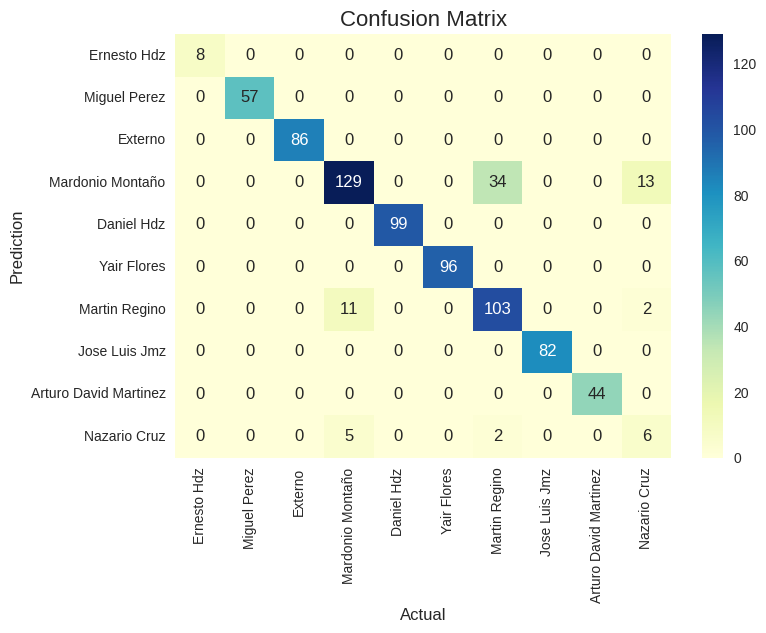

In [159]:
cm = confusion_matrix(y_driver_test, y_pred_drv)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(y_driver_test["OPERADOR"].unique()), yticklabels=list(y_driver_test["OPERADOR"].unique()))
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

En este caso podemos ver que el conductor que la predicción con más errores fue la de Mardonio Montaño, siendo que los conductores que debía haber seleccionado era Martin Regino y Nazario Cruz.

En general podemos ver que el modelo se comporta bien en casi todos los valores, ya que la mayor parte de las predicciones se encuentran en la diagnonal de en medio, siginficando que fueron asignadas de manera correcta.

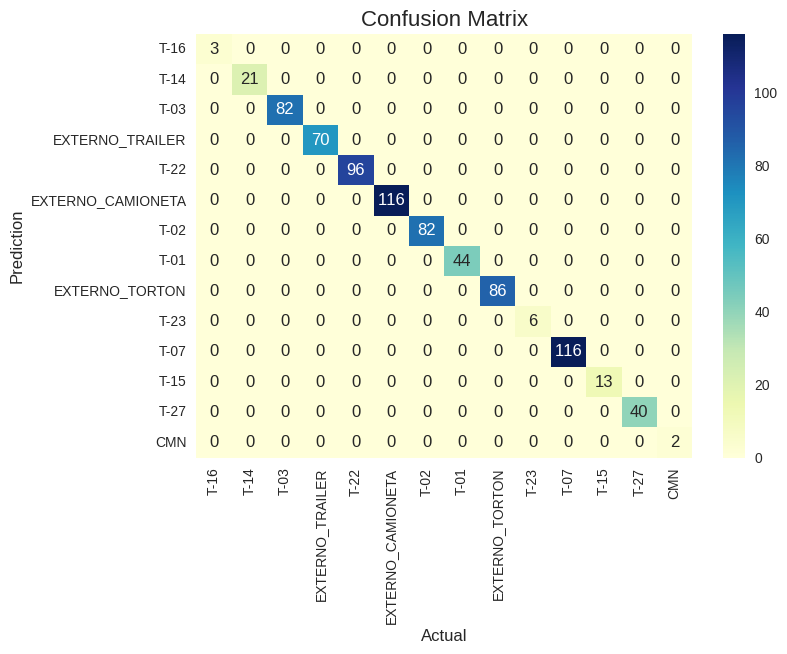

In [160]:
cm = confusion_matrix(y_vehicle_test, y_pred_veh)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(y_vehicle_test["ID UNIDAD ASIGNADA"].unique()), yticklabels=list(y_vehicle_test["ID UNIDAD ASIGNADA"].unique()))
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

En este caso podemos ver que la clasificación fue prácticamente perfecta, sin ningún valor fuera de la diagonal de en medio. Mostrando que todas las variables fueron clasisificadas correctamente.

### Curva ROC

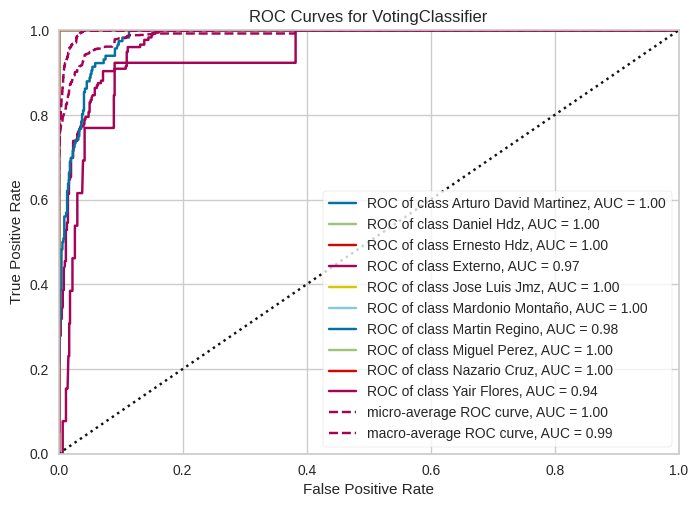

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [161]:
roc_drv = ROCAUC(final_model_driver)
roc_drv.fit(x_train_drv_res, y_train_drv_res)
roc_drv.score(x_driver_test, y_driver_test)
roc_drv.show()

En este caso, podemos ver que el modelo con el que más batalló fue con Yair Flores, teniendo un AUC de 94%. Este es un puntaje bastante bueno. En este tipo de gráficas el threshold generalmente, por rule of thumb, debe ser por arriba del 75% para considerar que los resultados son buenos. En este caso todos los valores fueron por arriba del 93% siendo un muy buen resultado.

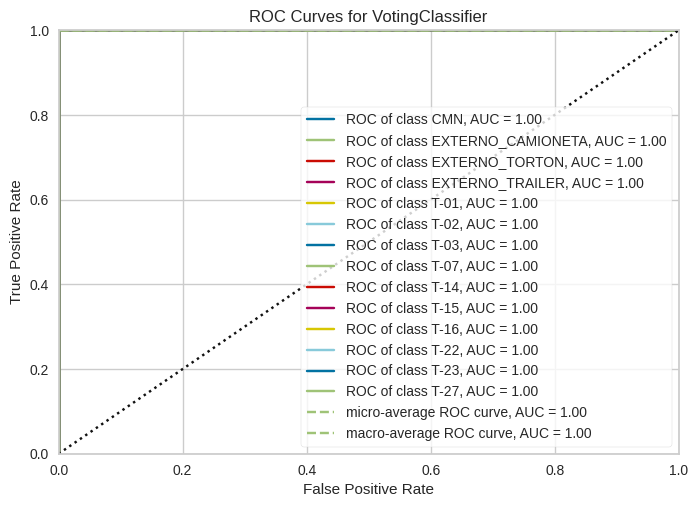

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [162]:
roc_veh = ROCAUC(final_model_vehicle)
roc_veh.fit(x_train_veh_res, y_train_veh_res)
roc_veh.score(x_vehicle_test, y_vehicle_test)
roc_veh.show()

En esta gráfica ninguna linea se aprecia ya que todas están identicas a la curva ideal. Siendo que todas las AUC son del 100%. Mostrando una vez más que el modelo tiene un resultado perfecto.

### Gráfico de importancia de características

importances_mean  importances_std
XP OPERADOR                                         0.826            0.004
TIPO DE UNIDAD_Torton                               0.108            0.003
MES                                                 0.063            0.001
PESO                                                0.058            0.003
PRECIO                                              0.032            0.001
DIA DE LA SEMANA                                    0.028            0.001
PACKAGING_ENTARIMADO                                0.019            0.001
DELIVERY_LON                                        0.018            0.001
DELIVERY_LAT                                        0.013            0.000
distancia_km                                        0.011            0.000
TIPO DE ARTICULO_DISFRACES                          0.008            0.001
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.005            0.000
PICKUP_LAT                                          0.003            0.000
TIPO DE ARTICULO_JUEGOS DE MESA                     0.003            0.000
PICKUP_LON                                          0.002            0.000
TIPO DE ARTICULO_ELECTRONICOS                       0.002            0.000
TIPO DE SERVICIO_Transporte                         0.001            0.000
TIPO DE SERVICIO_Maniobra                           0.001            0.000
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.000            0.000
TIPO DE SERVICIO_Estadia                            0.000            0.000
TIPO DE SERVICIO_Devolucion                         0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                   0.000            0.000
TIPO DE ARTICULO_PAQUETERIA                         0.000            0.000
TIPO DE ARTICULO_MUEBLES ARMABLES                  -0.000            0.000
TIPO DE UNIDAD_Camioneta                           -0.000            0.000
TIPO DE UNIDAD_Trailer                             -0.001            0.000

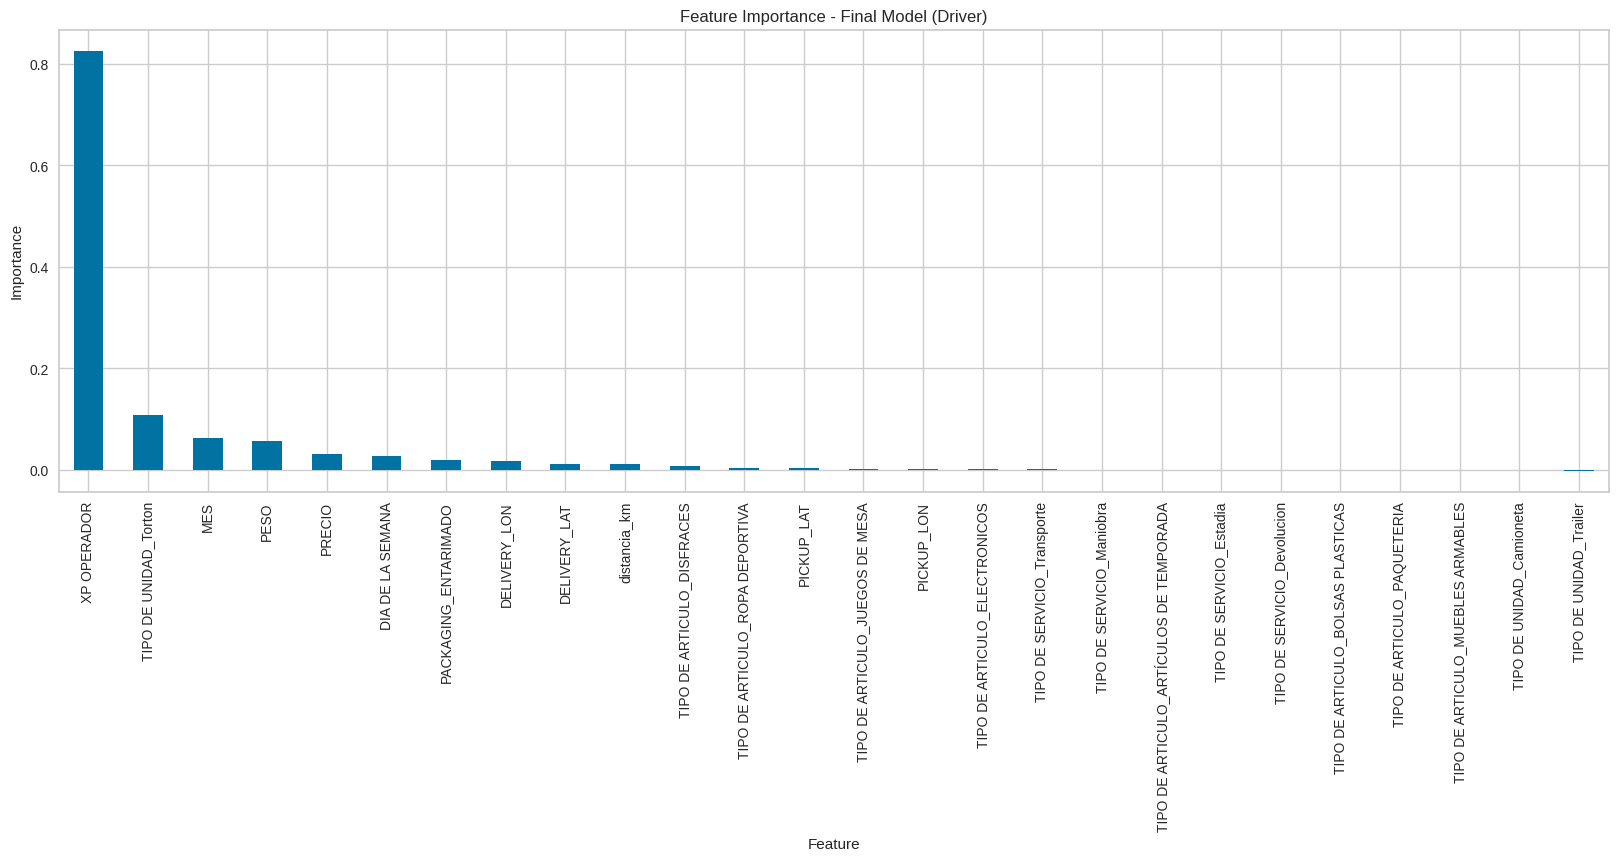

In [163]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = final_model_driver,
                   model_name = "Final Model (Driver)",
                   x = x_train_drv_res,
                   y = y_train_drv_res,
                   scorer = F1_scorer)

Confirmando con los resultados obtenidos en el avance 3 y 4, las variables con más peso en el modelo son:

1. Experiencia del Operador: Siendo la variable principal para escoger que conductor es el adecuado para el viaje
2. Tipo de unidad Torton: Indica que solo algunos conductores manejan los distintos tipos de vehículo.
3. Mes: Reafirma lo visto en el análisis exploratorio, mostrando que dependiendo el mes, la carga de trabajo varía.
4. Peso: Sólo algunos conductores son capaces de manejar con un cierto nivel de tonelaje en la carga
5. Precio: Como vimos en el EDA, el precio del viaje varia mucho de chofer a chofer

importances_mean  importances_std
XP OPERADOR                                         0.137            0.002
OPERADOR_Martin Regino                              0.097            0.002
OPERADOR_Ernesto Hdz                                0.093            0.001
OPERADOR_Yair Flores                                0.090            0.002
TIPO DE UNIDAD_Trailer                              0.080            0.002
OPERADOR_Arturo David Martinez                      0.075            0.002
OPERADOR_Externo                                    0.066            0.002
TIPO DE UNIDAD_Camioneta                            0.051            0.001
OPERADOR_Mardonio Montaño                           0.050            0.001
PICKUP_LAT                                          0.029            0.001
PESO                                                0.020            0.001
TIPO DE ARTICULO_ELECTRONICOS                       0.012            0.001
PICKUP_LON                                          0.006            0.001
DELIVERY_LAT                                        0.005            0.001
TIPO DE UNIDAD_Torton                               0.001            0.000
TIPO DE ARTICULO_DISFRACES                          0.001            0.000
DELIVERY_LON                                        0.001            0.000
distancia_km                                        0.001            0.000
DIA DE LA SEMANA                                    0.001            0.000
OPERADOR_Daniel Hdz                                 0.001            0.000
OPERADOR_Miguel Perez                               0.000            0.000
OPERADOR_Jose Luis Jmz                              0.000            0.000
MES                                                 0.000            0.000
TIPO DE ARTICULO_ROPA DEPORTIVA                     0.000            0.000
PRECIO                                              0.000            0.000
OPERADOR_Nazario Cruz                               0.000            0.000
TIPO DE SERVICIO_Transporte                         0.000            0.000
TIPO DE SERVICIO_Devolucion                         0.000            0.000
TIPO DE ARTICULO_ARTÍCULOS DE TEMPORADA             0.000            0.000
TIPO DE SERVICIO_Estadia                            0.000            0.000
TIPO DE SERVICIO_Maniobra                           0.000            0.000
TIPO DE ARTICULO_BOLSAS PLASTICAS                   0.000            0.000
TIPO DE ARTICULO_JUEGOS DE MESA                     0.000            0.000
TIPO DE ARTICULO_MUEBLES ARMABLES                   0.000            0.000
TIPO DE ARTICULO_PAQUETERIA                         0.000            0.000
PACKAGING_ENTARIMADO                                0.000            0.000

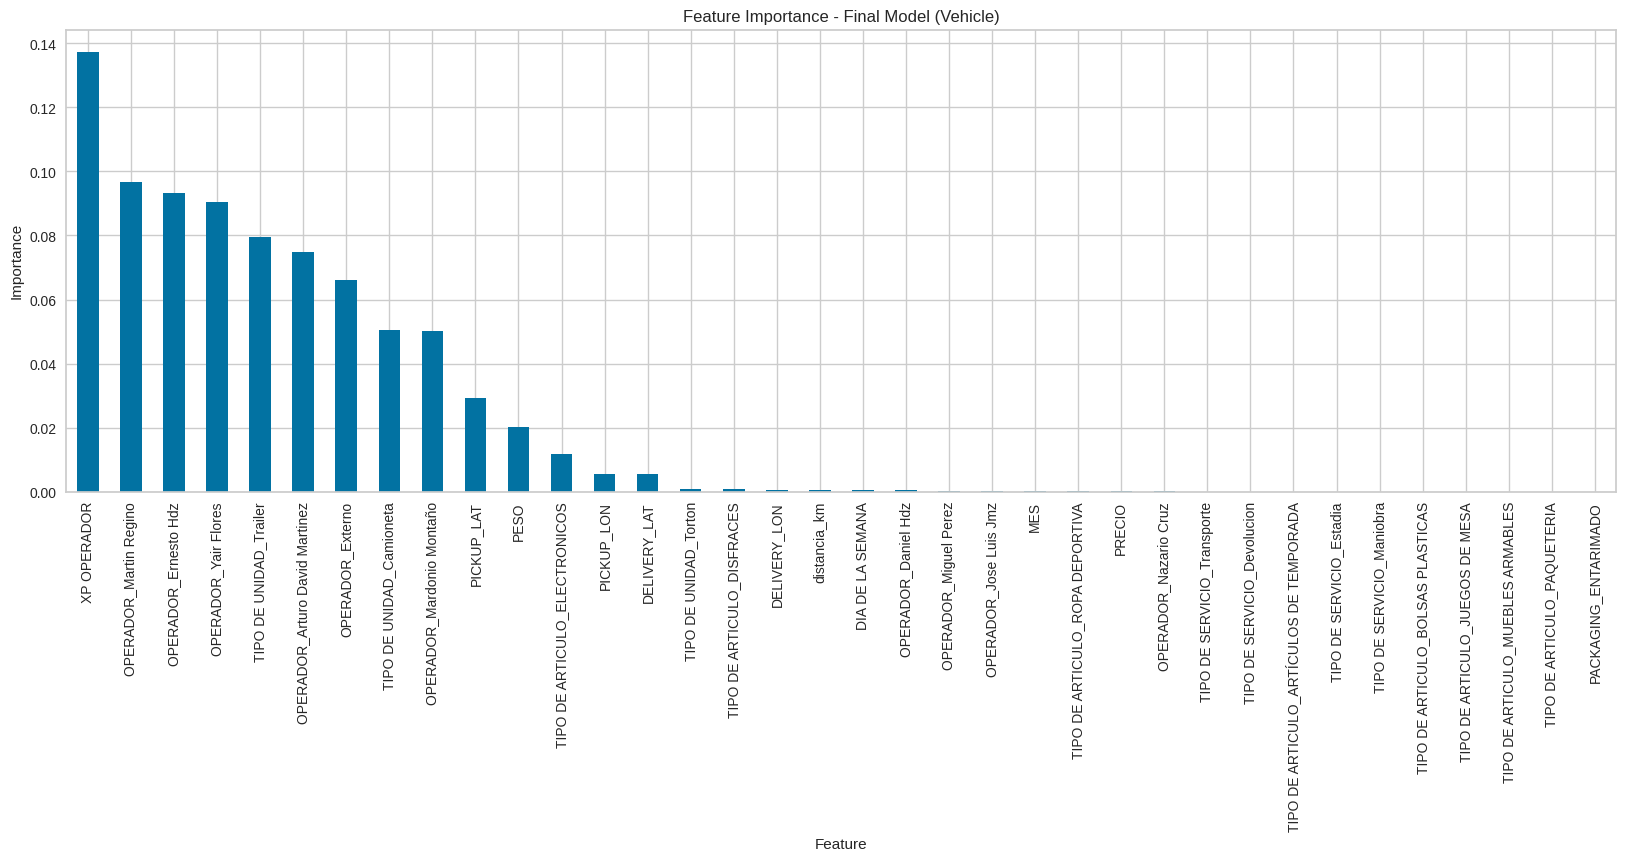

In [164]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = final_model_vehicle,
                   model_name = "Final Model (Vehicle)",
                   x = x_train_veh_res,
                   y = y_train_veh_res,
                   scorer = F1_scorer)

En este caso, los resultados están cargados dados los viajes con los que se entrenó. Me explico:
1. Experiencia del Operador: Como en el modelo del conductor, dependiendo la experiencia del conductor, podemos ver que influye mucho la experiencia del conductor para ser seleccionado para el viaje o no.
2. Para las variables 2, 3 y 4: Estas variables son con base en los operadores. Cada uno de estos operadores son los que con mayor frecuencia son seleccionados para viajes. Cada uno para un tipo de vehículo en particular. Esto hace sentido ya que dependiendo el conductor, prácticamente podemos saber qué tipo de vehículo será asignado.

3. Tipo de Unidad Trailer: Esto confirma lo visto en las variables 2, 3 y 4

### Classification Report

<Axes: >

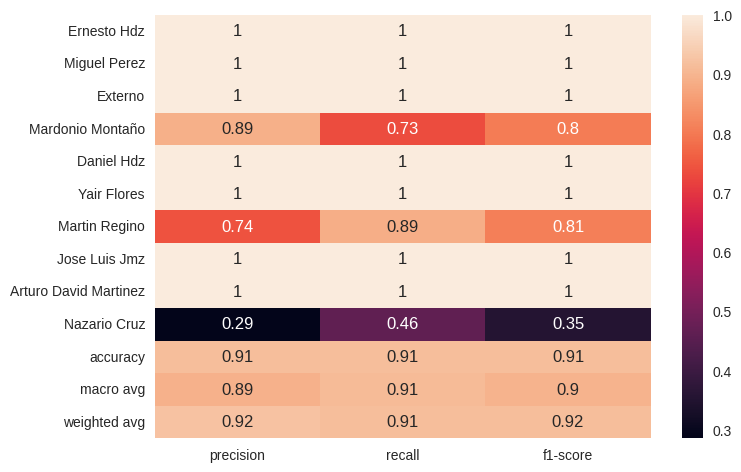

In [165]:
cr_driver = classification_report(y_driver_test, y_pred_drv, target_names=list(y_driver_test["OPERADOR"].unique()), output_dict=True)

sns.heatmap(pd.DataFrame(cr_driver).iloc[:-1, :].T, annot=True)

En este caso, podemos ver que el conductor con menor nivel de puntaje es Nazario Cruz. Probablemente sea el conductor con menor número de viajes registrados. Sus scores son muy bajos, mostrando que al menos para este conductor no son confiables los resultados. Es probable que para futuras mejoras, se registren otras características u otros viajes para robustecer su score.

<Axes: >

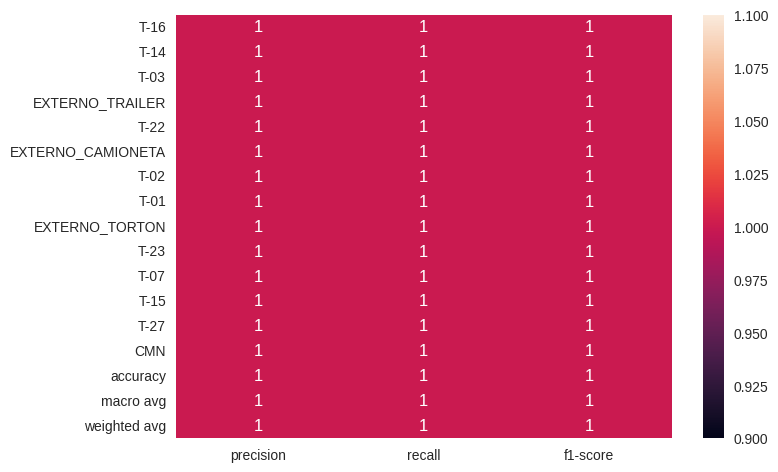

In [166]:
cr_vehicle = classification_report(y_vehicle_test, y_pred_veh, target_names=list(y_vehicle_test["ID UNIDAD ASIGNADA"].unique()), output_dict=True)

sns.heatmap(pd.DataFrame(cr_vehicle).iloc[:-1, :].T, annot=True)

Prácticamente perfectos los scores de cada uno de los vehículos. Comprobando una vez más la robustez del modelo y su capacidad de predicción.

# Referencias
- Ambika. (2023, September 13). Principal Component Analysis (PCA) in Machine Learning. Medium. https://medium.com/aimonks/principal-component-analysis-pca-in-machine-learning-407224cb4527
- Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2011a, June 9). Smote: Synthetic minority over-sampling technique. arXiv.org. https://arxiv.org/abs/1106.1813
- Khoong, W. H. (2023, January 21). Why scaling your data is important. Medium. https://medium.com/codex/why-scaling-your-data-is-important-1aff95ca97a2
- Kristianto, N. G. (2023, June 18). Decoding the power of encoding in machine learning. Medium. https://medium.com/@nicholasgabrielkr/decoding-the-power-of-encoding-in-machine-learning-39572e9cc6a3
- López, V., Fernández, A., García, S., Palade, V., & Herrera, F. (2013). An insight into classification with imbalanced data: Empirical results and current trends on using data intrinsic characteristics. Information Sciences, 250, 113–141. https://doi.org/10.1016/j.ins.2013.07.007
- Santiago, D. (2023, June 5). Balancing imbalanced data: Undersampling and oversampling techniques in Python. Medium. https://medium.com/@daniele.santiago/balancing-imbalanced-data-undersampling-and-oversampling-techniques-in-python-7c5378282290
- Elkhattam, A. (2020, December 7). Building a Content-based Recommender using a Cosine-Similarity Algorithm. Medium. https://a-elkhattam.medium.com/imdb-movie-recommendation-chatbot-942f84dfa0dc
- Figueroa, A. (2020, March 19). Recommendation systems: How suggestion algorithms work. Rootstrap. https://www.rootstrap.com/blog/the-magic-behind-recommendation-systems
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.
- Rokach, L., & Maimon, O. (2011). Data mining with decision trees: Theory and applications. Springer Science & Business Media.
- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
- Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning.
- Scikit-learn developers. (2024). BaggingClassifier — scikit-learn 1.5.0 documentation. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32. https://link.springer.com/article/10.1023/A:1010933404324
- Data Science Wizards. (2023, September 14). Understanding the Adaboost algorithm. Medium. https://medium.com/@curryrowan/adaboost-explained-92408a6713da
- Haykin, S. (1999). Neural networks: A comprehensive foundation (2nd ed.). Prentice Hall.
- Scikit-learn. (n.d.). Ensemble methods. Retrieved from https://scikit-learn.org/stable/modules/ensemble.html
- Corporate Finance Institute. (n.d.). Ensemble methods. Retrieved from https://corporatefinanceinstitute.com/resources/data-science/ensemble-methods/#:~:text=Ensemble%20methods%20are%20techniques%20that,ensemble%20methods%20in%20machine%20learning
- Analytics Vidhya. (2018, June 21). Comprehensive guide for ensemble models. Retrieved from https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
